In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:

# !ln -s /content/gdrive/My\ Drive/ /mydrive
# !ls /mydrive

In [3]:
# !cp -r  /mydrive/glove /content/glove/

In [1]:
import re
import os
import time
import numpy as np
import pandas as pd 
import unicodedata
import tensorflow as tf
import tensorflow.keras as krs
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import csv

BUFFER_SIZE = 20000
BATCH_SIZE = 64
embedding_dim = 50

In [2]:
# !pip freeze > requirements.txt

In [3]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/kaggle.json

In [4]:
# !kaggle datasets download -d shashichander009/inshorts-news-data

In [5]:
# !unzip /content/inshorts-news-data.zip

In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 891 kB/s            


In [3]:
data_unprocessed_news = pd.read_excel("../input/inshorts-news-data/Inshorts Cleaned Data.xlsx")
data_unprocessed_news.head()

Headline  \
0  4 ex-bank officials booked for cheating bank o...   
1     Supreme Court to go paperless in 6 months: CJI   
2  At least 3 killed, 30 injured in blast in Sylh...   
3  Why has Reliance been barred from trading in f...   
4  Was stopped from entering my own studio at Tim...   

                                               Short                 Source   \
0  The CBI on Saturday booked four former officia...  The New Indian Express   
1  Chief Justice JS Khehar has said the Supreme C...                 Outlook   
2  At least three people were killed, including a...         Hindustan Times   
3  Mukesh Ambani-led Reliance Industries (RIL) wa...                Livemint   
4  TV news anchor Arnab Goswami has said he was t...                 YouTube   

      Time  Publish Date  
0  09:25:00   2017-03-26  
1  22:18:00   2017-03-25  
2  23:39:00   2017-03-25  
3  23:08:00   2017-03-25  
4  23:24:00   2017-03-25

In [4]:
from sklearn.utils import shuffle
data_unprocessed_news = shuffle(data_unprocessed_news,random_state=42)
data_unprocessed_news.head()

Headline  \
2098   Gangster-turned-politician Mukhtar Ansari wins...   
8760   Indira Gandhi only woman to have presented the...   
42126       Sandler brings doppelgänger to film premiere   
28632       Aadhaar cannot be mandatory, SC reminds govt   
36240       Robots create architecture with carbon fibre   

                                                   Short   Source      Time   \
2098   Gangster-turned-politician Mukhtar Ansari has ...   loading  18:58:00   
8760   Indira Gandhi has been the only woman till dat...  Livemint  16:59:00   
42126  Actor Adam Sandler brought his 23-year-old dop...  Mashable  18:26:00   
28632  The Supreme Court recently reminded the Centre...   Twitter  19:31:00   
36240  Researchers at the University of Stuttgart hav...   YouTube  21:46:00   

      Publish Date  
2098    2017-03-11  
8760    2017-01-27  
42126   2016-05-22  
28632   2016-09-26  
36240   2016-08-03

In [5]:
summaries, longreview = pd.DataFrame(), pd.DataFrame()
summaries['short'] = data_unprocessed_news['Headline']#[:data_to_use]
longreview['long'] = data_unprocessed_news['Short']#[:data_to_use]
(summaries.shape,longreview.shape)

((55104, 1), (55104, 1))

In [6]:
summaries.head()

short
2098   Gangster-turned-politician Mukhtar Ansari wins...
8760   Indira Gandhi only woman to have presented the...
42126       Sandler brings doppelgänger to film premiere
28632       Aadhaar cannot be mandatory, SC reminds govt
36240       Robots create architecture with carbon fibre

In [7]:
longreview.head()

long
2098   Gangster-turned-politician Mukhtar Ansari has ...
8760   Indira Gandhi has been the only woman till dat...
42126  Actor Adam Sandler brought his 23-year-old dop...
28632  The Supreme Court recently reminded the Centre...
36240  Researchers at the University of Stuttgart hav...

In [8]:
def clean_words(sentence):
    sentence = str(sentence).lower()
    sentence = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') # for converting é to e and other accented chars
    sentence = re.sub(r"http\S+","",sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r"'til", "until", sentence)
    sentence = re.sub(r"\"", "", sentence)
    sentence = re.sub(r"\'", "", sentence)
    sentence = re.sub(r' s ', "",sentence)
    sentence = re.sub(r"&39", "", sentence)
    sentence = re.sub(r"&34", "", sentence) 
    sentence = re.sub(r"[\[\]\\0-9()\"$#%/@;:<>{}`+=~|.!?,-]", "", sentence)
    sentence = re.sub(r"&", "", sentence)
    sentence = re.sub(r"\\n", "", sentence)
    sentence = sentence.strip()
    return sentence

In [9]:
summaries['short'] = summaries['short'].apply(lambda x: clean_words(x))
longreview['long'] = longreview['long'].apply(lambda x: clean_words(x))

In [10]:
start_token, end_token = '<startseq>' , '<endseq>'
summaries = summaries.apply(lambda x: start_token + ' ' + x + ' ' + end_token)
summaries.head()

short
2098   <startseq> gangsterturnedpolitician mukhtar an...
8760   <startseq> indira gandhi only woman to have pr...
42126  <startseq> sandler brings doppelganger to film...
28632  <startseq> aadhaar cannot be mandatory sc remi...
36240  <startseq> robots create architecture with car...

In [11]:
val_split = 0.1
# train validation split
summaries_train = summaries[int(len(summaries)*val_split):]
summaries_val = summaries[:int(len(summaries)*val_split)]
longreview_train = longreview[int(len(summaries)*val_split):]
longreview_val = longreview[:int(len(summaries)*val_split)]

len(longreview_val),len(longreview_train)

(5510, 49594)

In [12]:
def max_length(shorts, longs, prct):
    
    length_longs = list(len(d.split()) for d in longs)
    length_shorts = list(len(d.split()) for d in shorts)

    print('percentile {} of length of news: {}'.format(prct,np.percentile(length_longs, prct)))
    print('longest sentence: ', max(length_longs))
    print()
    print('percentile {} of length of summaries: {}'.format(prct,np.percentile(length_shorts, prct)))
    print('longest sentence: ', max(length_shorts))
    print()
    return int(np.percentile(length_longs, prct)),int(np.percentile(length_shorts, prct))

In [13]:
max_len_news, max_len_summary= max_length(summaries_train['short'].to_list(), longreview_train['long'].to_list(), 90)

percentile 90 of length of news: 60.0
longest sentence:  66

percentile 90 of length of summaries: 12.0
longest sentence:  16



In [14]:
def create_vocab(shorts, longs = None, minimum_repeat = 3):

    all_captions = []
    for s in shorts:
        all_captions.append(s)

    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= minimum_repeat]
    
    vocab = list(set(vocab))
    return vocab

In [15]:
vocab_dec = create_vocab(summaries_train['short'].to_list(), minimum_repeat=5) # here we just use the words in vocabulary of summaries

for v in vocab_dec:
    if len(v) == 1 and v!='a' and v!='i':
        vocab_dec.remove(v) 
        
vocab_dec = sorted(vocab_dec)[1:] 
vocab_dec[:10]

['<endseq>',
 '<startseq>',
 'a',
 'aa',
 'aadhaar',
 'aadhaarbased',
 'aadmi',
 'aam',
 'aamir',
 'aamirs']

In [16]:
vocab_enc = create_vocab(longreview_train['long'].to_list(), minimum_repeat=3) 

for v in vocab_enc:
    if len(v) == 1 and v!='a' and v!='i':
        vocab_enc.remove(v) 
        
vocab_enc = sorted(vocab_enc)[1:] 
vocab_enc[:10]

['a',
 'a**holes',
 'aa',
 'aadat',
 'aadhaar',
 'aadhaarbased',
 'aadhaarenabled',
 'aadhaarlinked',
 'aadhaars',
 'aadhar']

In [17]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' 

document_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
summary_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)

document_tokenizer.fit_on_texts(vocab_enc)
summary_tokenizer.fit_on_texts(vocab_dec)

encoder_vocab_size = len(document_tokenizer.word_index) + 1 
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(32421, 8900)

In [18]:
ixtoword_enc = {} # index to word dic
ixtoword_dec = {} # index to word dic

wordtoix_enc = document_tokenizer.word_index 
ixtoword_enc[0] = '<PAD0>' 
ixtoword_dec[0] = '<PAD0>' 

for w in document_tokenizer.word_index:
    ixtoword_enc[document_tokenizer.word_index[w]] = w

wordtoix_dec = summary_tokenizer.word_index 

for w in summary_tokenizer.word_index:
    ixtoword_dec[summary_tokenizer.word_index[w]] = w

In [19]:
inputs = document_tokenizer.texts_to_sequences(longreview_train['long'])
targets = summary_tokenizer.texts_to_sequences(summaries_train['short'])

inputs_val = document_tokenizer.texts_to_sequences(longreview_val['long'])
targets_val = summary_tokenizer.texts_to_sequences(summaries_val['short'])

In [20]:
inputs = krs.preprocessing.sequence.pad_sequences(inputs, maxlen=max_len_news, padding='post', truncating='post')
targets = krs.preprocessing.sequence.pad_sequences(targets, maxlen=max_len_summary, padding='post', truncating='post')

inputs_val = krs.preprocessing.sequence.pad_sequences(inputs_val, maxlen=max_len_news, padding='post', truncating='post')
targets_val = krs.preprocessing.sequence.pad_sequences(targets_val, maxlen=max_len_summary, padding='post', truncating='post')

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((inputs,targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.from_tensor_slices((inputs_val,targets_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE*2)

2021-12-05 13:34:49.126016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 13:34:49.219204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 13:34:49.219924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 13:34:49.222649: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
longreview_val.reset_index(inplace=True, drop=True)
summaries_val.reset_index(inplace=True, drop=True)
longreview_train.reset_index(inplace=True, drop=True)
summaries_train.reset_index(inplace=True, drop=True)

In [23]:
import matplotlib.pyplot as plt

def hist(history):
    plt.title('Loss')

    x= [i[0] for i in history['val']]
    y=[i[1] for i in history['val']]
    plt.plot(x,y,'x-')
    
    x= [i[0] for i in history['train']]
    y=[i[1] for i in history['train']]    
    plt.plot(x,y,'o-')

    plt.legend(['validation','train'])
    plt.show()
    print('smallest val loss:', sorted(history['val'],key=lambda x: x[1])[0])

In [31]:
# test_sen = ['Hello How are you ?', 'Hello', 'How are you', 'I am fine', 'Thank You']
# test_seq = document_tokenizer.texts_to_sequences(test_sen)
# test_seq

[[12711, 13178, 1706, 32261],
 [12711],
 [13178, 1706, 32261],
 [13365, 1074, 10432],
 [29042, 32261]]

In [32]:
# test_sen = ['Hello How are you ?', 'Hello', 'How are you', 'I am fine', 'Thank You']
# test_seq = summary_tokenizer.texts_to_sequences(test_sen)
# test_seq

[[3499, 3637, 466, 8725],
 [3499],
 [3637, 466, 8725],
 [3687, 305, 2913],
 [7851, 8725]]

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [25]:
class MultiHeadAttention(krs.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # The dimensions of Q, K, V are called depth

        # the input of these 3 layers are the same: X
        self.wq = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wk = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wv = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))

        self.dense = tf.keras.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    
    # reshape the Q,K,V 
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # learn the Q,K,V matrices (the layers' weightes)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # reshape them
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # the last dens layer expect one vector so we use concat
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

In [26]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
        )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [27]:
def make_embedding_layer(vocab_len, wordtoix, embedding_dim=200, glove=True, glove_path= '../input/glove-embedding'):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) 
    else:
        
        print('Loading glove...')
        glove_dir = glove_path
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        
        print("GloVe ",embedding_dim, ' loaded!')

    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) 
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

In [28]:
embeddings_encoder = make_embedding_layer(encoder_vocab_size, wordtoix_enc, embedding_dim=embedding_dim, glove=True)
embeddings_decoder = make_embedding_layer(decoder_vocab_size, wordtoix_dec, embedding_dim=embedding_dim, glove=True)

Loading glove...
GloVe  50  loaded!
Loading glove...
GloVe  50  loaded!


In [29]:
# hyper-params
init_lr = 1e-3
lmbda_l2 = 0.1
d_out_rate = 0.1 # tested 0.4, 0.3, 0.1 values this 0.1 seems to be the best
num_layers = 4 # chaged from 4 to 5 to learn better
d_model = embedding_dim # d_model is the representation dimension or embedding dimension of a word (usually in the range 128–512)
dff = 512 # number of neurons in feed forward network
num_heads = 5 # first it was 8 i chenged it to 10 to use embd =300d

In [30]:
def point_wise_feed_forward_network(d_model, dff):
    return krs.Sequential([
        krs.layers.Dense(dff, activation='relu',kernel_regularizer=krs.regularizers.l2(l=lmbda_l2)),
        krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    ])

In [31]:
class EncoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
   
    # it has 1 layer of multi-headed attention
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [32]:
class DecoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
        self.dropout3 = krs.layers.Dropout(rate)
    
    # it has 2 layers of multi-headed attention
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [33]:
class Encoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_encoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = krs.layers.Dropout(rate)
        self.dropout_embd = krs.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x = self.dropout_embd(x, training=training) # dropout added to encoder input changed from nothing to this
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x

In [34]:
class Decoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_decoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)] # a list of decoder layers
        self.dropout = krs.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask) # enc_output is fed into it

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights

In [35]:
# class Transformer(krs.Model):
#   def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,target_vocab_size, pe_input, pe_target, rate=d_out_rate):
#     super(Transformer, self).__init__()
#     self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
#     self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
#     self.final_layer = krs.layers.Dense(target_vocab_size, kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))        

#   def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
#     enc_output = self.encoder(inp, training, enc_padding_mask)  
#     dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
#     final_output = self.final_layer(dec_output)
#     return final_output, attention_weights

In [36]:
class Transformer(krs.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                                     target_vocab_size, pe_input, pe_target, rate=d_out_rate):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = krs.layers.Dense(target_vocab_size, kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        
        
    # training argument is used in dropout inputs
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

In [37]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]


def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [38]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
        
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [39]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=max_len_news,
    pe_target=max_len_summary,
)

In [40]:
lr_schedule = krs.optimizers.schedules.ExponentialDecay(initial_learning_rate=init_lr, decay_steps=4000, decay_rate=0.95)

In [41]:
optimizer2 = Adam(lr_schedule , beta_1=0.9, beta_2=0.98, epsilon=1e-9) # changed to init
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') # added softmax changed from_logits to false

In [42]:
def loss_function(real,pred,l2=False):
  
  if l2:
    lambda_ = 0.0001
    l2_norms = [tf.nn.l2_loss(v) for v in transformer.trainable_variables]
    l2_norm = tf.reduce_sum(l2_norms)
    l2_value = lambda_ * l2_norm
    loss_ = loss_object(real, pred) + l2_value
  
  else:
    loss_ = loss_object(real,pred)
  
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  mask = tf.cast(mask,dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [43]:
checkpoint_path4 ="checkpoints4"
ckpt4 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer2)
ckpt_manager4 = tf.train.CheckpointManager(ckpt4, checkpoint_path4, max_to_keep=100)

In [44]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = krs.preprocessing.sequence.pad_sequences(input_document, maxlen=max_len_news, padding='post', truncating='post')
    
    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index[start_token]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_len_summary):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # stop prediciting if it reached end_token
        if predicted_id == summary_tokenizer.word_index[end_token]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

In [45]:
def summarize(input_document):
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  
    return summary_tokenizer.sequences_to_texts(summarized)[0]  

In [46]:
def validate():
    print('validation started ...')
    val_loss.reset_states()
    
    for (batch, (inp, tar)) in enumerate(dataset_val):    
        tar_inp = tar[:, :-1] 
        tar_real = tar[:, 1:]

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        # Operations are recorded if they are executed within this context manager
        # and at least one of their inputs is being "watched". Trainable variables are automatically watched
        predictions, _ = transformer(
            inp, tar_inp, 
            False, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    print('\n* Validation loss: {} '.format(val_loss.result()) )
    return val_loss.result()

In [47]:
@tf.function 
def train_step(inp, tar):
    tar_inp = tar[:, :-1] # <startseq> hi im moein
    tar_real = tar[:, 1:] # hi im moein <endseq>

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    # Operations are recorded if they are executed within this context manager
    # and at least one of their inputs is being "watched". Trainable variables are automatically watched
    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer2.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # mean the loss with new computed  loss of the step
    train_loss(loss)

In [48]:
history={'val':[],'train':[]}
EPOCHS = 300
not_progressing = 0
# Computes the (weighted) mean of the given loss values.
train_loss = krs.metrics.Mean(name='train_loss')
val_loss = krs.metrics.Mean(name='val_loss')

In [49]:
params = {
'lmbda_l2' : lmbda_l2,
'd_out_rate' :d_out_rate,
'num_layers' : num_layers ,
'd_model' : d_model  ,
'dff' : dff ,
'num_heads' : num_heads,
'init_lr':init_lr}
params

{'lmbda_l2': 0.1,
 'd_out_rate': 0.1,
 'num_layers': 4,
 'd_model': 50,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

In [50]:
ep = 1
best_val_loss = np.inf
i1,i2,i3,i4 = np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val))

{'lmbda_l2': 0.1, 'd_out_rate': 0.1, 'num_layers': 4, 'd_model': 50, 'dff': 512, 'num_heads': 5, 'init_lr': 0.001}
########################################


2021-12-05 13:36:20.145397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1 Batch 0 Loss 9.1012
Epoch 1 Batch 150 Loss 7.3669
Epoch 1 Batch 300 Loss 7.0377
Epoch 1 Batch 450 Loss 6.8718
Epoch 1 Batch 600 Loss 6.7520
Epoch 1 Batch 750 Loss 6.6574

<UNK> <UNK> <UNK> to <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> to <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> to <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 6.0686235427856445 

* Train Loss 6.6429

Saving checkpoint for epoch 1 at checkpoints4/ckpt-1


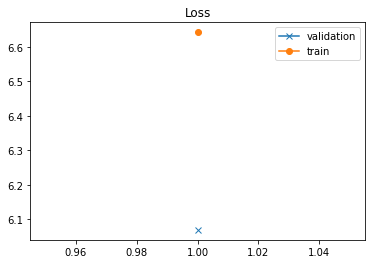

smallest val loss: (1, 6.0686235)
Current Lr:  0.0009901111

Time taken for this epoch: 38.26 secs

Epoch 2 Batch 0 Loss 6.1070
Epoch 2 Batch 150 Loss 6.1103
Epoch 2 Batch 300 Loss 6.0784
Epoch 2 Batch 450 Loss 6.0444
Epoch 2 Batch 600 Loss 6.0084
Epoch 2 Batch 750 Loss 5.9772

<UNK> <UNK> <UNK> <UNK> <UNK> in india
i <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 5.63273811340332 

* Train Loss 5.9709

Saving checkpoint for epoch 2 at checkpoints4/ckpt-2


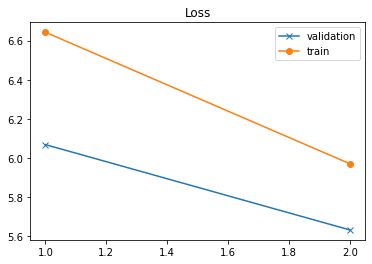

smallest val loss: (2, 5.632738)
Current Lr:  0.00098032

Time taken for this epoch: 25.40 secs

Epoch 3 Batch 0 Loss 5.7530
Epoch 3 Batch 150 Loss 5.7211
Epoch 3 Batch 300 Loss 5.7002
Epoch 3 Batch 450 Loss 5.6812
Epoch 3 Batch 600 Loss 5.6595
Epoch 3 Batch 750 Loss 5.6385

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
i <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 5.360877513885498 

* Train Loss 5.6351

Saving checkpoint for epoch 3 at checkpoints4/ckpt-3


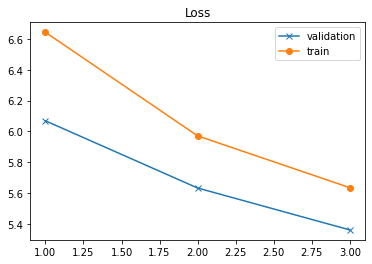

smallest val loss: (3, 5.3608775)
Current Lr:  0.00097062584

Time taken for this epoch: 24.08 secs

Epoch 4 Batch 0 Loss 5.5846
Epoch 4 Batch 150 Loss 5.4419
Epoch 4 Batch 300 Loss 5.4324
Epoch 4 Batch 450 Loss 5.4177
Epoch 4 Batch 600 Loss 5.4049
Epoch 4 Batch 750 Loss 5.3883

kohli kohli to win <UNK> <UNK>
i dont have <UNK> <UNK> <UNK> tweets user
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 5.159199237823486 

* Train Loss 5.3862

Saving checkpoint for epoch 4 at checkpoints4/ckpt-4


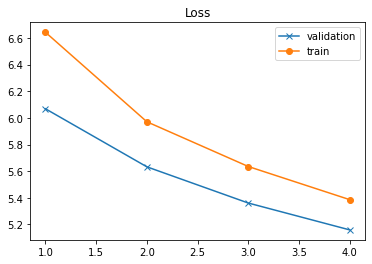

smallest val loss: (4, 5.159199)
Current Lr:  0.0009610275

Time taken for this epoch: 24.86 secs

Epoch 5 Batch 0 Loss 5.1797
Epoch 5 Batch 150 Loss 5.2146
Epoch 5 Batch 300 Loss 5.2148
Epoch 5 Batch 450 Loss 5.2066
Epoch 5 Batch 600 Loss 5.1990
Epoch 5 Batch 750 Loss 5.1922

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
pm modi to be <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 5.028077602386475 

* Train Loss 5.1898

Saving checkpoint for epoch 5 at checkpoints4/ckpt-5


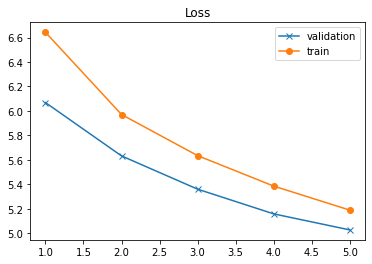

smallest val loss: (5, 5.0280776)
Current Lr:  0.00095152395

Time taken for this epoch: 24.45 secs

Epoch 6 Batch 0 Loss 5.2350
Epoch 6 Batch 150 Loss 5.0409
Epoch 6 Batch 300 Loss 5.0445
Epoch 6 Batch 450 Loss 5.0416
Epoch 6 Batch 600 Loss 5.0426
Epoch 6 Batch 750 Loss 5.0392

<UNK> <UNK> <UNK> <UNK> <UNK> in the year
<UNK> <UNK> <UNK> <UNK> <UNK> tweets user
<UNK> <UNK> to be <UNK> in <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> dies aged

validation started ...

* Validation loss: 4.941185474395752 

* Train Loss 5.0384


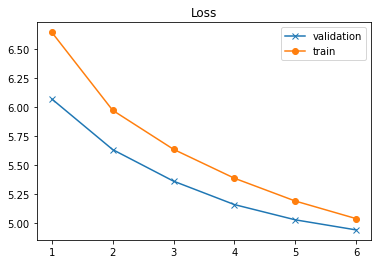

smallest val loss: (6, 4.9411855)
Current Lr:  0.00094211457

Time taken for this epoch: 24.99 secs

Epoch 7 Batch 0 Loss 4.9535
Epoch 7 Batch 150 Loss 4.9181
Epoch 7 Batch 300 Loss 4.9224
Epoch 7 Batch 450 Loss 4.9153
Epoch 7 Batch 600 Loss 4.9141
Epoch 7 Batch 750 Loss 4.9114

<UNK> <UNK> <UNK> <UNK> <UNK> in <UNK>
i am a <UNK> <UNK> <UNK> <UNK>
pm modi to get <UNK> to <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.8096489906311035 

* Train Loss 4.9111

Saving checkpoint for epoch 7 at checkpoints4/ckpt-6


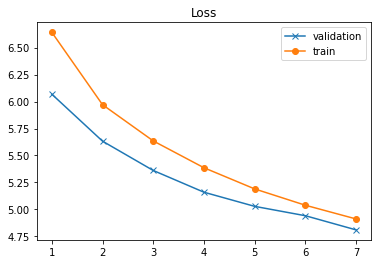

smallest val loss: (7, 4.809649)
Current Lr:  0.0009327981

Time taken for this epoch: 24.93 secs

Epoch 8 Batch 0 Loss 4.7675
Epoch 8 Batch 150 Loss 4.7932
Epoch 8 Batch 300 Loss 4.7993
Epoch 8 Batch 450 Loss 4.8044
Epoch 8 Batch 600 Loss 4.8058
Epoch 8 Batch 750 Loss 4.8056

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
i dont get married <UNK> <UNK> <UNK>
pm modi to launch <UNK> <UNK> to <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.741503715515137 

* Train Loss 4.8060


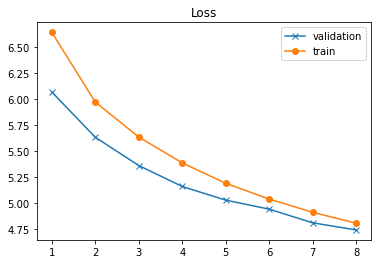

smallest val loss: (8, 4.7415037)
Current Lr:  0.00092357374

Time taken for this epoch: 24.72 secs

Epoch 9 Batch 0 Loss 4.9292
Epoch 9 Batch 150 Loss 4.6995
Epoch 9 Batch 300 Loss 4.7087
Epoch 9 Batch 450 Loss 4.7027
Epoch 9 Batch 600 Loss 4.7129
Epoch 9 Batch 750 Loss 4.7151

<UNK> <UNK> <UNK> <UNK> <UNK> in the test
i dont get my <UNK> <UNK> <UNK> <UNK>
pm modi launches <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.674746513366699 

* Train Loss 4.7149

Saving checkpoint for epoch 9 at checkpoints4/ckpt-7


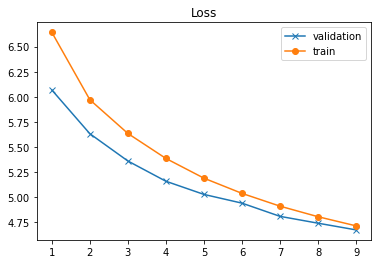

smallest val loss: (9, 4.6747465)
Current Lr:  0.0009144407

Time taken for this epoch: 24.76 secs

Epoch 10 Batch 0 Loss 4.6578
Epoch 10 Batch 150 Loss 4.6149
Epoch 10 Batch 300 Loss 4.6253
Epoch 10 Batch 450 Loss 4.6297
Epoch 10 Batch 600 Loss 4.6324
Epoch 10 Batch 750 Loss 4.6337

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
sachin <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
pm modi to get free free <UNK> to <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.608831882476807 

* Train Loss 4.6350


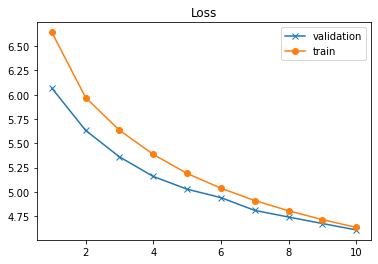

smallest val loss: (10, 4.608832)
Current Lr:  0.00090539793

Time taken for this epoch: 25.30 secs

Epoch 11 Batch 0 Loss 4.4804
Epoch 11 Batch 150 Loss 4.5366
Epoch 11 Batch 300 Loss 4.5472
Epoch 11 Batch 450 Loss 4.5530
Epoch 11 Batch 600 Loss 4.5571
Epoch 11 Batch 750 Loss 4.5635

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
i have a <UNK> <UNK> <UNK> <UNK>
pm modi to launch <UNK> railway stations
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.554672718048096 

* Train Loss 4.5638

Saving checkpoint for epoch 11 at checkpoints4/ckpt-8


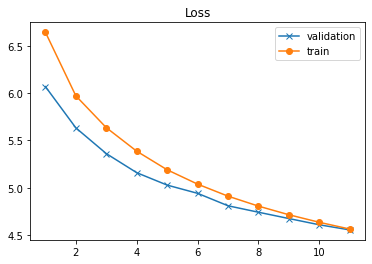

smallest val loss: (11, 4.5546727)
Current Lr:  0.00089644454

Time taken for this epoch: 24.58 secs

Epoch 12 Batch 0 Loss 4.2488
Epoch 12 Batch 150 Loss 4.4696
Epoch 12 Batch 300 Loss 4.4808
Epoch 12 Batch 450 Loss 4.4912
Epoch 12 Batch 600 Loss 4.4972
Epoch 12 Batch 750 Loss 4.5015

yrs since <UNK> scored a century in a test
sachin gandhi was a <UNK> as a <UNK>
pm modi to get <UNK> for <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.482109546661377 

* Train Loss 4.5017


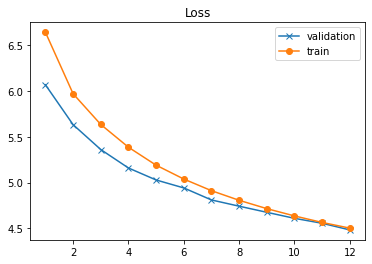

smallest val loss: (12, 4.4821095)
Current Lr:  0.00088757975

Time taken for this epoch: 24.97 secs

Epoch 13 Batch 0 Loss 4.4262
Epoch 13 Batch 150 Loss 4.4093
Epoch 13 Batch 300 Loss 4.4163
Epoch 13 Batch 450 Loss 4.4304
Epoch 13 Batch 600 Loss 4.4366
Epoch 13 Batch 750 Loss 4.4470

<UNK> <UNK> <UNK> <UNK> <UNK> in the test match
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
pm modi wishes train train for train
<UNK> <UNK> <UNK> <UNK> <UNK> in <UNK>

validation started ...

* Validation loss: 4.453369617462158 

* Train Loss 4.4483

Saving checkpoint for epoch 13 at checkpoints4/ckpt-9


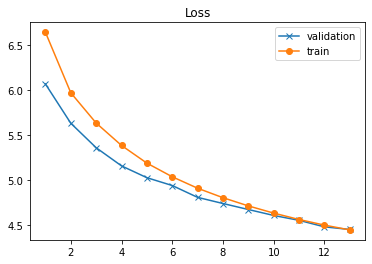

smallest val loss: (13, 4.4533696)
Current Lr:  0.00087880256

Time taken for this epoch: 25.15 secs

Epoch 14 Batch 0 Loss 4.3184
Epoch 14 Batch 150 Loss 4.3422
Epoch 14 Batch 300 Loss 4.3722
Epoch 14 Batch 450 Loss 4.3809
Epoch 14 Batch 600 Loss 4.3910
Epoch 14 Batch 750 Loss 4.4007

<UNK> <UNK> <UNK> <UNK> in test series
<UNK> trending on twitter today
pm modi wishes pm modi to <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.426337718963623 

* Train Loss 4.4017


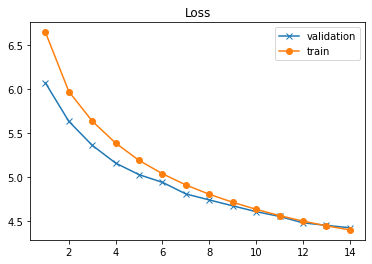

smallest val loss: (14, 4.4263377)
Current Lr:  0.0008701122

Time taken for this epoch: 24.61 secs

Epoch 15 Batch 0 Loss 4.1827
Epoch 15 Batch 150 Loss 4.3072
Epoch 15 Batch 300 Loss 4.3286
Epoch 15 Batch 450 Loss 4.3363
Epoch 15 Batch 600 Loss 4.3504
Epoch 15 Batch 750 Loss 4.3589

<UNK> <UNK> scored in the st test test
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
pm modi asks pm modi to <UNK> <UNK>
kim jongun son <UNK> <UNK> <UNK> in <UNK>

validation started ...

* Validation loss: 4.385639667510986 

* Train Loss 4.3593


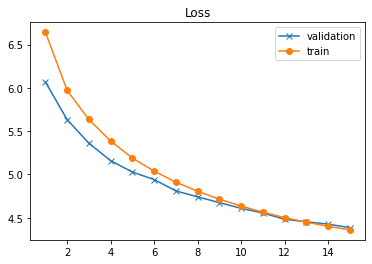

smallest val loss: (15, 4.3856397)
Current Lr:  0.00086150784

Time taken for this epoch: 24.50 secs

Epoch 16 Batch 0 Loss 4.2128
Epoch 16 Batch 150 Loss 4.2600
Epoch 16 Batch 300 Loss 4.2828
Epoch 16 Batch 450 Loss 4.3010
Epoch 16 Batch 600 Loss 4.3123
Epoch 16 Batch 750 Loss 4.3242

<UNK> <UNK> <UNK> <UNK> <UNK> in a test
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
pm modi asks pm modi to train <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.342019557952881 

* Train Loss 4.3249

Saving checkpoint for epoch 16 at checkpoints4/ckpt-10


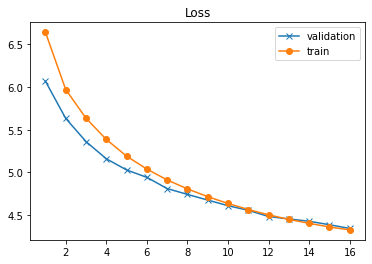

smallest val loss: (16, 4.3420196)
Current Lr:  0.00085298845

Time taken for this epoch: 25.30 secs

Epoch 17 Batch 0 Loss 4.0983
Epoch 17 Batch 150 Loss 4.2176
Epoch 17 Batch 300 Loss 4.2499
Epoch 17 Batch 450 Loss 4.2663
Epoch 17 Batch 600 Loss 4.2798
Epoch 17 Batch 750 Loss 4.2877

<UNK> <UNK> <UNK> <UNK> in the test
dhoni <UNK> <UNK> <UNK> <UNK> <UNK>
pm modi asks pm modi to <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.300939559936523 

* Train Loss 4.2895


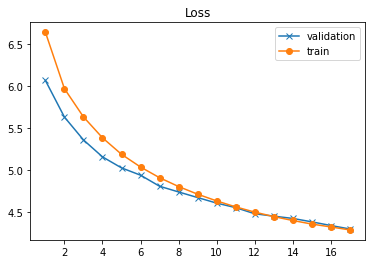

smallest val loss: (17, 4.3009396)
Current Lr:  0.0008445534

Time taken for this epoch: 24.39 secs

Epoch 18 Batch 0 Loss 4.1652
Epoch 18 Batch 150 Loss 4.1951
Epoch 18 Batch 300 Loss 4.2218
Epoch 18 Batch 450 Loss 4.2387
Epoch 18 Batch 600 Loss 4.2487
Epoch 18 Batch 750 Loss 4.2609

<UNK> <UNK> scored a <UNK> in the st test
dhoni <UNK> <UNK> <UNK> <UNK> <UNK>
pm modi asks pm to <UNK> <UNK> for <UNK>
kim <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.279407501220703 

* Train Loss 4.2624


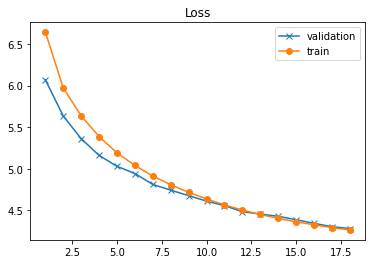

smallest val loss: (18, 4.2794075)
Current Lr:  0.00083620177

Time taken for this epoch: 25.20 secs

Epoch 19 Batch 0 Loss 4.0000
Epoch 19 Batch 150 Loss 4.1830
Epoch 19 Batch 300 Loss 4.2045
Epoch 19 Batch 450 Loss 4.2166
Epoch 19 Batch 600 Loss 4.2284
Epoch 19 Batch 750 Loss 4.2334

<UNK> <UNK> <UNK> <UNK> in the first innings
ms dhoni trending on twitter today
modi asks pm modi to train on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.28151273727417 

* Train Loss 4.2351


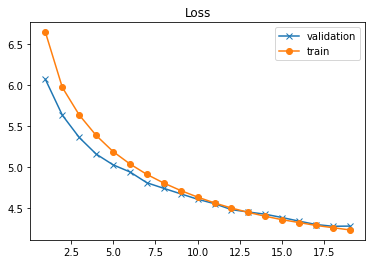

smallest val loss: (18, 4.2794075)
Current Lr:  0.0008279326

Time taken for this epoch: 24.22 secs

Epoch 20 Batch 0 Loss 4.1425
Epoch 20 Batch 150 Loss 4.1488
Epoch 20 Batch 300 Loss 4.1659
Epoch 20 Batch 450 Loss 4.1806
Epoch 20 Batch 600 Loss 4.1910
Epoch 20 Batch 750 Loss 4.2078

<UNK> st ever test runs in the year
dhoni trending on twitter today
pm modi meets pm modi for <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.247509002685547 

* Train Loss 4.2089


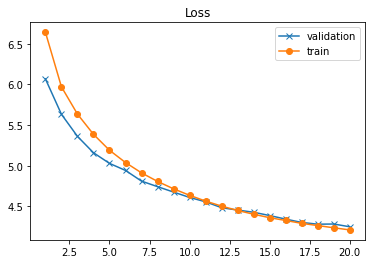

smallest val loss: (20, 4.247509)
Current Lr:  0.0008197454

Time taken for this epoch: 24.36 secs

Epoch 21 Batch 0 Loss 4.1901
Epoch 21 Batch 150 Loss 4.1232
Epoch 21 Batch 300 Loss 4.1417
Epoch 21 Batch 450 Loss 4.1624
Epoch 21 Batch 600 Loss 4.1710
Epoch 21 Batch 750 Loss 4.1835

<UNK> <UNK> <UNK> <UNK> in a test innings
dhoni trending on twitter today
pm modi thanks free for <UNK> <UNK>
kim jongnams <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.243328094482422 

* Train Loss 4.1853


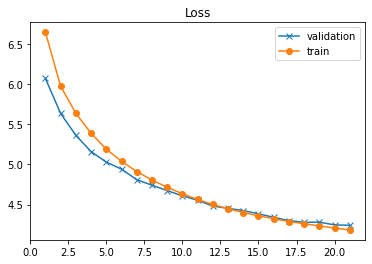

smallest val loss: (21, 4.243328)
Current Lr:  0.00081163907

Time taken for this epoch: 24.61 secs

Epoch 22 Batch 0 Loss 4.3019
Epoch 22 Batch 150 Loss 4.0965
Epoch 22 Batch 300 Loss 4.1156
Epoch 22 Batch 450 Loss 4.1383
Epoch 22 Batch 600 Loss 4.1488
Epoch 22 Batch 750 Loss 4.1613

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi asks pm modi to train <UNK> <UNK>
north korea zoo <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.223416805267334 

* Train Loss 4.1635

Saving checkpoint for epoch 22 at checkpoints4/ckpt-11


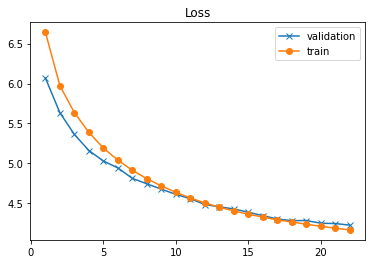

smallest val loss: (22, 4.223417)
Current Lr:  0.0008036128

Time taken for this epoch: 24.95 secs

Epoch 23 Batch 0 Loss 4.0723
Epoch 23 Batch 150 Loss 4.0914
Epoch 23 Batch 300 Loss 4.1112
Epoch 23 Batch 450 Loss 4.1205
Epoch 23 Batch 600 Loss 4.1326
Epoch 23 Batch 750 Loss 4.1415

<UNK> <UNK> <UNK> <UNK> <UNK> in st time
dhoni trending on twitter today
pm modi thanks <UNK> for <UNK> <UNK>
kim kim <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.207841873168945 

* Train Loss 4.1436


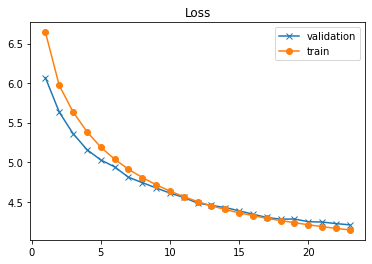

smallest val loss: (23, 4.207842)
Current Lr:  0.000795666

Time taken for this epoch: 24.13 secs

Epoch 24 Batch 0 Loss 4.0746
Epoch 24 Batch 150 Loss 4.0840
Epoch 24 Batch 300 Loss 4.0899
Epoch 24 Batch 450 Loss 4.1005
Epoch 24 Batch 600 Loss 4.1127
Epoch 24 Batch 750 Loss 4.1217

<UNK> <UNK> <UNK> <UNK> in st test
dhoni trending on twitter today
pm modi asks pm to <UNK> <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> in <UNK>

validation started ...

* Validation loss: 4.1799845695495605 

* Train Loss 4.1235


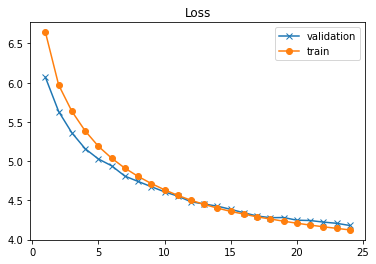

smallest val loss: (24, 4.1799846)
Current Lr:  0.0007877978

Time taken for this epoch: 24.65 secs

Epoch 25 Batch 0 Loss 4.1590
Epoch 25 Batch 150 Loss 4.0453
Epoch 25 Batch 300 Loss 4.0660
Epoch 25 Batch 450 Loss 4.0731
Epoch 25 Batch 600 Loss 4.0903
Epoch 25 Batch 750 Loss 4.1032

<UNK> <UNK> test ball was once was a ball in a ball
dhoni trending on twitter today
pm modi asks pm modi to train <UNK> for <UNK>
north korea leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.206954002380371 

* Train Loss 4.1052


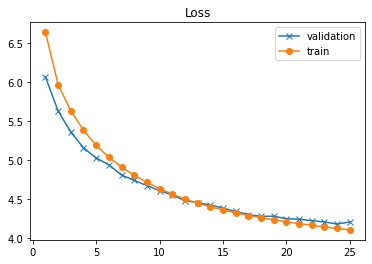

smallest val loss: (24, 4.1799846)
Current Lr:  0.00078000734

Time taken for this epoch: 25.30 secs

Epoch 26 Batch 0 Loss 3.7079
Epoch 26 Batch 150 Loss 4.0097
Epoch 26 Batch 300 Loss 4.0342
Epoch 26 Batch 450 Loss 4.0552
Epoch 26 Batch 600 Loss 4.0741
Epoch 26 Batch 750 Loss 4.0862

<UNK> becomes st to score a <UNK> in a test
dhoni trending on twitter today
pm modi asks pm modi to train in <UNK>
north korea leader <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.167567729949951 

* Train Loss 4.0871


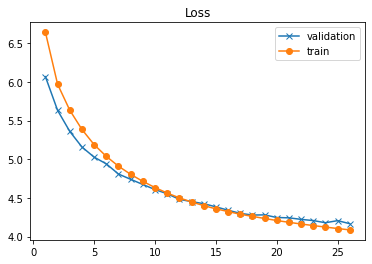

smallest val loss: (26, 4.1675677)
Current Lr:  0.00077229395

Time taken for this epoch: 24.80 secs

Epoch 27 Batch 0 Loss 3.8951
Epoch 27 Batch 150 Loss 4.0077
Epoch 27 Batch 300 Loss 4.0332
Epoch 27 Batch 450 Loss 4.0433
Epoch 27 Batch 600 Loss 4.0547
Epoch 27 Batch 750 Loss 4.0672

<UNK> st ever to score in the st test
dhoni trending on twitter today
pm modi asks pm modi to train for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on this day

validation started ...

* Validation loss: 4.133976936340332 

* Train Loss 4.0708


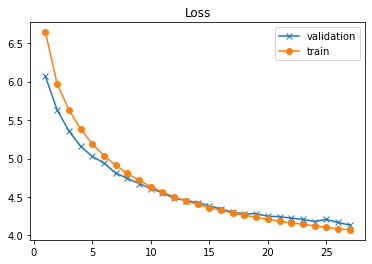

smallest val loss: (27, 4.133977)
Current Lr:  0.00076465687

Time taken for this epoch: 24.41 secs

Epoch 28 Batch 0 Loss 4.0305
Epoch 28 Batch 150 Loss 4.0014
Epoch 28 Batch 300 Loss 4.0210
Epoch 28 Batch 450 Loss 4.0327
Epoch 28 Batch 600 Loss 4.0460
Epoch 28 Batch 750 Loss 4.0574

<UNK> <UNK> <UNK> <UNK> <UNK> in st test
dhoni trending on twitter today
pm asks pm modi to send <UNK> to <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.1355061531066895 

* Train Loss 4.0580


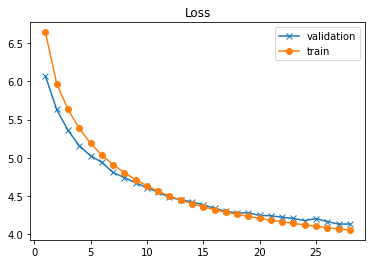

smallest val loss: (27, 4.133977)
Current Lr:  0.00075709523

Time taken for this epoch: 24.77 secs

Epoch 29 Batch 0 Loss 3.9038
Epoch 29 Batch 150 Loss 3.9704
Epoch 29 Batch 300 Loss 3.9960
Epoch 29 Batch 450 Loss 4.0148
Epoch 29 Batch 600 Loss 4.0278
Epoch 29 Batch 750 Loss 4.0390

<UNK> st ever <UNK> in a test innings
dhoni trending on twitter today
pm modi asks pm modi to take <UNK> for <UNK>
north korean woman <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.143073558807373 

* Train Loss 4.0419


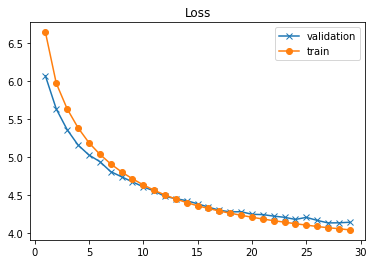

smallest val loss: (27, 4.133977)
Current Lr:  0.0007496085

Time taken for this epoch: 24.63 secs

Epoch 30 Batch 0 Loss 4.0809
Epoch 30 Batch 150 Loss 3.9471
Epoch 30 Batch 300 Loss 3.9760
Epoch 30 Batch 450 Loss 3.9972
Epoch 30 Batch 600 Loss 4.0132
Epoch 30 Batch 750 Loss 4.0243

<UNK> st <UNK> to score a ball ball in a test
ms dhoni trending on twitter today
pm modi asks pm modi to train <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.111702919006348 

* Train Loss 4.0253

Saving checkpoint for epoch 30 at checkpoints4/ckpt-12


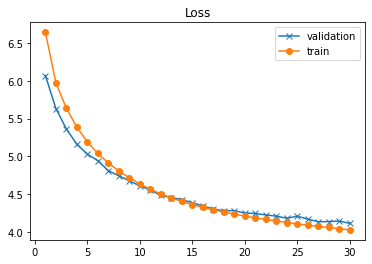

smallest val loss: (30, 4.111703)
Current Lr:  0.0007421957

Time taken for this epoch: 25.38 secs

Epoch 31 Batch 0 Loss 3.8829
Epoch 31 Batch 150 Loss 3.9402
Epoch 31 Batch 300 Loss 3.9742
Epoch 31 Batch 450 Loss 3.9792
Epoch 31 Batch 600 Loss 3.9937
Epoch 31 Batch 750 Loss 4.0083

<UNK> was st ever ball in test cricket
ms dhoni trending on twitter today
pm modi asks pm modi to teach free <UNK>
north korea leader <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.08107328414917 

* Train Loss 4.0108


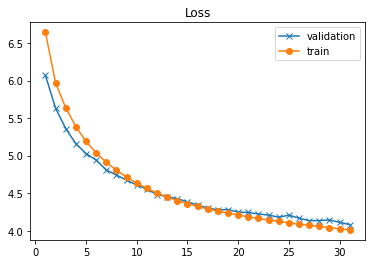

smallest val loss: (31, 4.0810733)
Current Lr:  0.00073485624

Time taken for this epoch: 24.49 secs

Epoch 32 Batch 0 Loss 3.7985
Epoch 32 Batch 150 Loss 3.9267
Epoch 32 Batch 300 Loss 3.9504
Epoch 32 Batch 450 Loss 3.9654
Epoch 32 Batch 600 Loss 3.9834
Epoch 32 Batch 750 Loss 3.9985

<UNK> st <UNK> to score ball ball in tests
ms dhoni trending on twitter today
pm modi asks pm to train <UNK> in <UNK>
<UNK> korean leader <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.072295665740967 

* Train Loss 4.0005


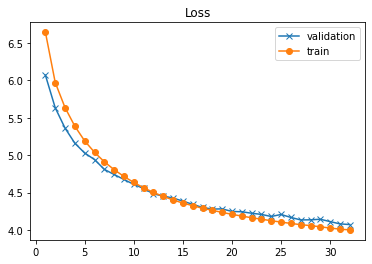

smallest val loss: (32, 4.0722957)
Current Lr:  0.00072758936

Time taken for this epoch: 24.59 secs

Epoch 33 Batch 0 Loss 3.8684
Epoch 33 Batch 150 Loss 3.9215
Epoch 33 Batch 300 Loss 3.9445
Epoch 33 Batch 450 Loss 3.9626
Epoch 33 Batch 600 Loss 3.9695
Epoch 33 Batch 750 Loss 3.9838

<UNK> st <UNK> test century was <UNK> in the first time
ms dhoni trending on twitter today
pm modi asks pm modi to train <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 4.084585189819336 

* Train Loss 3.9871


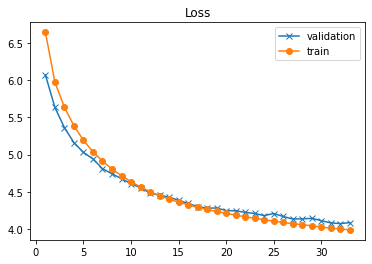

smallest val loss: (32, 4.0722957)
Current Lr:  0.00072039437

Time taken for this epoch: 24.97 secs

Epoch 34 Batch 0 Loss 3.9310
Epoch 34 Batch 150 Loss 3.9176
Epoch 34 Batch 300 Loss 3.9339
Epoch 34 Batch 450 Loss 3.9501
Epoch 34 Batch 600 Loss 3.9652
Epoch 34 Batch 750 Loss 3.9748

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm asks pm to train in schools to train on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.04499626159668 

* Train Loss 3.9782


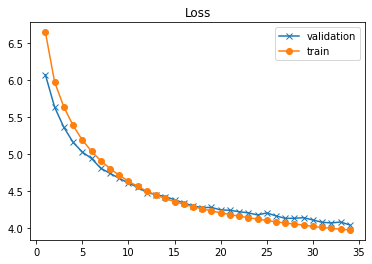

smallest val loss: (34, 4.0449963)
Current Lr:  0.0007132704

Time taken for this epoch: 24.45 secs

Epoch 35 Batch 0 Loss 3.8418
Epoch 35 Batch 150 Loss 3.9042
Epoch 35 Batch 300 Loss 3.9184
Epoch 35 Batch 450 Loss 3.9345
Epoch 35 Batch 600 Loss 3.9545
Epoch 35 Batch 750 Loss 3.9677

<UNK> <UNK> <UNK> <UNK> <UNK> in tests
dhoni trending on twitter today
pm modi asks pm to train <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.063292503356934 

* Train Loss 3.9680


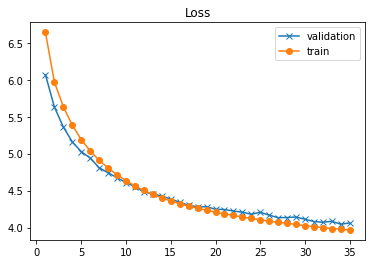

smallest val loss: (34, 4.0449963)
Current Lr:  0.000706217

Time taken for this epoch: 24.48 secs

Epoch 36 Batch 0 Loss 3.9225
Epoch 36 Batch 150 Loss 3.8917
Epoch 36 Batch 300 Loss 3.9144
Epoch 36 Batch 450 Loss 3.9290
Epoch 36 Batch 600 Loss 3.9401
Epoch 36 Batch 750 Loss 3.9534

<UNK> st ever test ball to hit the first ball
dhoni trending on twitter today
pm asks pm modi to train <UNK> for poor
kim jongun <UNK> <UNK> <UNK> <UNK> to celebrate birthday

validation started ...

* Validation loss: 4.059915542602539 

* Train Loss 3.9542


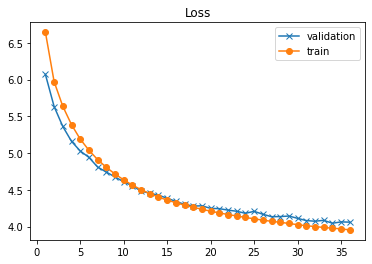

smallest val loss: (34, 4.0449963)
Current Lr:  0.00069923326

Time taken for this epoch: 24.83 secs

Epoch 37 Batch 0 Loss 3.7377
Epoch 37 Batch 150 Loss 3.8748
Epoch 37 Batch 300 Loss 3.8986
Epoch 37 Batch 450 Loss 3.9196
Epoch 37 Batch 600 Loss 3.9327
Epoch 37 Batch 750 Loss 3.9432

<UNK> was the first to score <UNK> in a test
ms dhoni trending on twitter today
pm modi asks people to teach toilet for <UNK>
north korea leader <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.0467753410339355 

* Train Loss 3.9453


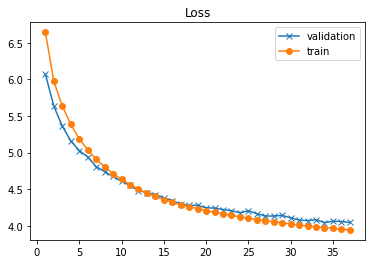

smallest val loss: (34, 4.0449963)
Current Lr:  0.0006923187

Time taken for this epoch: 24.70 secs

Epoch 38 Batch 0 Loss 4.0457
Epoch 38 Batch 150 Loss 3.8618
Epoch 38 Batch 300 Loss 3.8888
Epoch 38 Batch 450 Loss 3.9048
Epoch 38 Batch 600 Loss 3.9179
Epoch 38 Batch 750 Loss 3.9335

<UNK> st ever test ball was once was a ball
ms dhoni trending on twitter today
pm modi asks <UNK> to <UNK> schools
north korean leader <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.040249347686768 

* Train Loss 3.9349


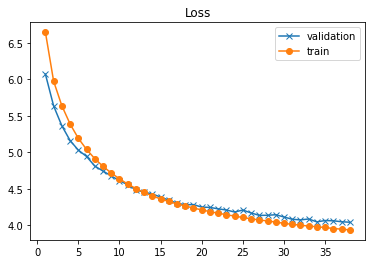

smallest val loss: (38, 4.0402493)
Current Lr:  0.00068547245

Time taken for this epoch: 24.40 secs

Epoch 39 Batch 0 Loss 3.7062
Epoch 39 Batch 150 Loss 3.8560
Epoch 39 Batch 300 Loss 3.8733
Epoch 39 Batch 450 Loss 3.8967
Epoch 39 Batch 600 Loss 3.9088
Epoch 39 Batch 750 Loss 3.9236

<UNK> was st <UNK> to be <UNK> in the first test
dhoni <UNK> <UNK> <UNK> <UNK> <UNK>
pm modi asks pm to train <UNK> for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.047067165374756 

* Train Loss 3.9258


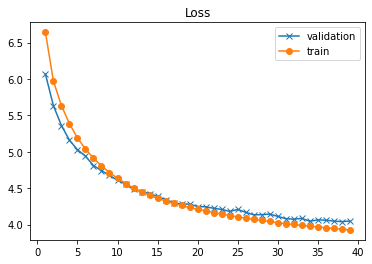

smallest val loss: (38, 4.0402493)
Current Lr:  0.00067869393

Time taken for this epoch: 24.83 secs

Epoch 40 Batch 0 Loss 3.6325
Epoch 40 Batch 150 Loss 3.8473
Epoch 40 Batch 300 Loss 3.8659
Epoch 40 Batch 450 Loss 3.8834
Epoch 40 Batch 600 Loss 3.8987
Epoch 40 Batch 750 Loss 3.9122

<UNK> first <UNK> <UNK> <UNK> in a test
dhoni <UNK> trending on twitter today
pm modi asks pm modi to train students on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.033884048461914 

* Train Loss 3.9146


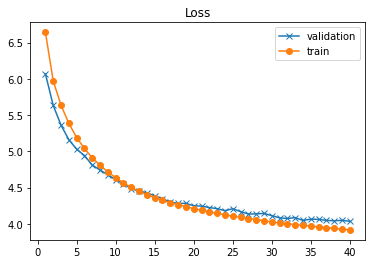

smallest val loss: (40, 4.033884)
Current Lr:  0.0006719824

Time taken for this epoch: 24.62 secs

Epoch 41 Batch 0 Loss 3.9635
Epoch 41 Batch 150 Loss 3.8287
Epoch 41 Batch 300 Loss 3.8616
Epoch 41 Batch 450 Loss 3.8765
Epoch 41 Batch 600 Loss 3.8912
Epoch 41 Batch 750 Loss 3.9051

<UNK> st <UNK> <UNK> was born on this day
dhoni trending on twitter today
pm modi asks pm modi to train <UNK> on toilet
north korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9940004348754883 

* Train Loss 3.9083

Saving checkpoint for epoch 41 at checkpoints4/ckpt-13


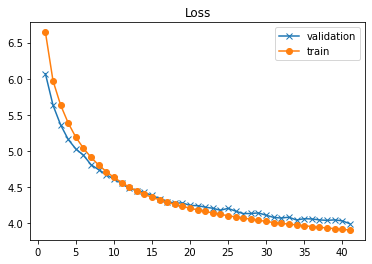

smallest val loss: (41, 3.9940004)
Current Lr:  0.0006653373

Time taken for this epoch: 24.91 secs

Epoch 42 Batch 0 Loss 3.9633
Epoch 42 Batch 150 Loss 3.8350
Epoch 42 Batch 300 Loss 3.8537
Epoch 42 Batch 450 Loss 3.8695
Epoch 42 Batch 600 Loss 3.8821
Epoch 42 Batch 750 Loss 3.8967

<UNK> st ever <UNK> ball in the first test innings
dhoni <UNK> <UNK> <UNK> on twitter today
pm asks pm to give free <UNK> for poor
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.022542476654053 

* Train Loss 3.8980


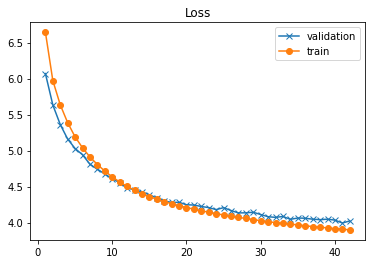

smallest val loss: (41, 3.9940004)
Current Lr:  0.0006587578

Time taken for this epoch: 24.84 secs

Epoch 43 Batch 0 Loss 3.9859
Epoch 43 Batch 150 Loss 3.8152
Epoch 43 Batch 300 Loss 3.8410
Epoch 43 Batch 450 Loss 3.8631
Epoch 43 Batch 600 Loss 3.8735
Epoch 43 Batch 750 Loss 3.8867

<UNK> first <UNK> <UNK> in the first test
ms dhoni trending on twitter today
pm asks pm to provide toilets for poor toilets
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.016910076141357 

* Train Loss 3.8902


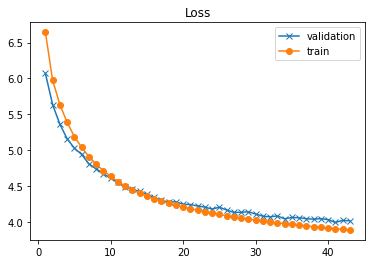

smallest val loss: (41, 3.9940004)
Current Lr:  0.0006522435

Time taken for this epoch: 24.63 secs

Epoch 44 Batch 0 Loss 3.7460
Epoch 44 Batch 150 Loss 3.8076
Epoch 44 Batch 300 Loss 3.8391
Epoch 44 Batch 450 Loss 3.8525
Epoch 44 Batch 600 Loss 3.8640
Epoch 44 Batch 750 Loss 3.8775

<UNK> st <UNK> <UNK> <UNK> <UNK> in a test
dhoni trending on twitter today
pm modi asks pm modi to teach toilets for poor
<UNK> korea leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.005580425262451 

* Train Loss 3.8795


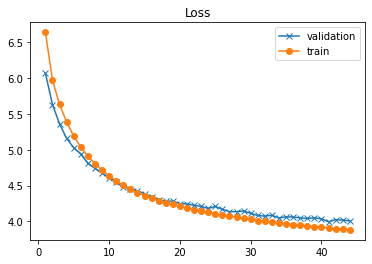

smallest val loss: (41, 3.9940004)
Current Lr:  0.00064579357

Time taken for this epoch: 24.90 secs

Epoch 45 Batch 0 Loss 3.7986
Epoch 45 Batch 150 Loss 3.7978
Epoch 45 Batch 300 Loss 3.8304
Epoch 45 Batch 450 Loss 3.8450
Epoch 45 Batch 600 Loss 3.8600
Epoch 45 Batch 750 Loss 3.8710

<UNK> st <UNK> to run runs in the first test
dhoni trending on twitter today
pm asks pm modi to give free toilets for students
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.997391700744629 

* Train Loss 3.8734


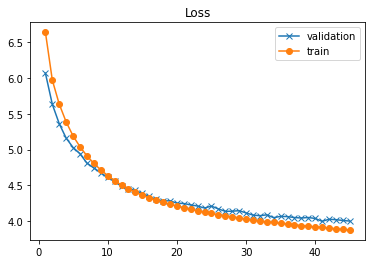

smallest val loss: (41, 3.9940004)
Current Lr:  0.0006394074

Time taken for this epoch: 24.68 secs

Epoch 46 Batch 0 Loss 3.8205
Epoch 46 Batch 150 Loss 3.7844
Epoch 46 Batch 300 Loss 3.8258
Epoch 46 Batch 450 Loss 3.8409
Epoch 46 Batch 600 Loss 3.8526
Epoch 46 Batch 750 Loss 3.8678

<UNK> st ever <UNK> <UNK> in a test
ms dhoni trending on twitter today
pm modi asks pm modi to <UNK> toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9982008934020996 

* Train Loss 3.8706


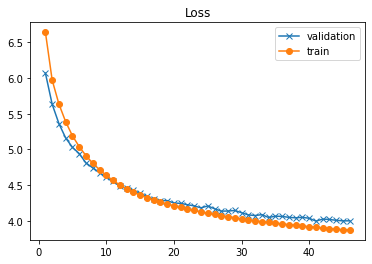

smallest val loss: (41, 3.9940004)
Current Lr:  0.0006330844

Time taken for this epoch: 24.69 secs

Epoch 47 Batch 0 Loss 3.7840
Epoch 47 Batch 150 Loss 3.7862
Epoch 47 Batch 300 Loss 3.8119
Epoch 47 Batch 450 Loss 3.8328
Epoch 47 Batch 600 Loss 3.8436
Epoch 47 Batch 750 Loss 3.8576

<UNK> st <UNK> test ton was once was once
dhoni trending on twitter today
pm modi asks pm modi to <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.975776433944702 

* Train Loss 3.8592


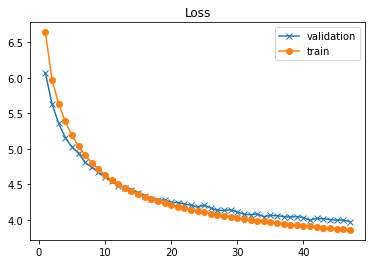

smallest val loss: (47, 3.9757764)
Current Lr:  0.00062682386

Time taken for this epoch: 24.64 secs

Epoch 48 Batch 0 Loss 3.6321
Epoch 48 Batch 150 Loss 3.7876
Epoch 48 Batch 300 Loss 3.8061
Epoch 48 Batch 450 Loss 3.8230
Epoch 48 Batch 600 Loss 3.8372
Epoch 48 Batch 750 Loss 3.8502

<UNK> st ever <UNK> <UNK> in the first test
ms dhoni <UNK> trending on twitter today
pm modi asks people to give <UNK> for poor
kim jongun <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.96728515625 

* Train Loss 3.8509


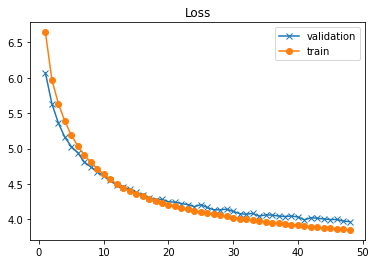

smallest val loss: (48, 3.9672852)
Current Lr:  0.00062062533

Time taken for this epoch: 25.22 secs

Epoch 49 Batch 0 Loss 3.7689
Epoch 49 Batch 150 Loss 3.7901
Epoch 49 Batch 300 Loss 3.8088
Epoch 49 Batch 450 Loss 3.8171
Epoch 49 Batch 600 Loss 3.8295
Epoch 49 Batch 750 Loss 3.8411

<UNK> st <UNK> ball was <UNK> in a test
dhoni trending on twitter today
pm modi asks pm to give <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 4.0019612312316895 

* Train Loss 3.8441


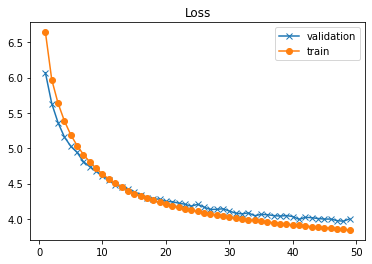

smallest val loss: (48, 3.9672852)
Current Lr:  0.00061448803

Time taken for this epoch: 24.55 secs

Epoch 50 Batch 0 Loss 3.5447
Epoch 50 Batch 150 Loss 3.7637
Epoch 50 Batch 300 Loss 3.7948
Epoch 50 Batch 450 Loss 3.8081
Epoch 50 Batch 600 Loss 3.8215
Epoch 50 Batch 750 Loss 3.8343

<UNK> st ever <UNK> <UNK> in a innings
ms dhoni trending on twitter today
pm modi thanks people for <UNK> toilets
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.976855993270874 

* Train Loss 3.8370


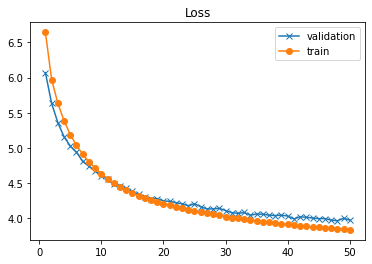

smallest val loss: (48, 3.9672852)
Current Lr:  0.00060841144

Time taken for this epoch: 24.86 secs

Epoch 51 Batch 0 Loss 3.6267
Epoch 51 Batch 150 Loss 3.7620
Epoch 51 Batch 300 Loss 3.7860
Epoch 51 Batch 450 Loss 3.7981
Epoch 51 Batch 600 Loss 3.8115
Epoch 51 Batch 750 Loss 3.8284

<UNK> st <UNK> ball on this day
dhoni trending on twitter today
pm modi asks pm modi to give toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9549875259399414 

* Train Loss 3.8303


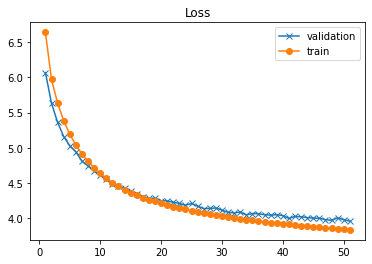

smallest val loss: (51, 3.9549875)
Current Lr:  0.0006023949

Time taken for this epoch: 24.56 secs

Epoch 52 Batch 0 Loss 3.7397
Epoch 52 Batch 150 Loss 3.7609
Epoch 52 Batch 300 Loss 3.7790
Epoch 52 Batch 450 Loss 3.7980
Epoch 52 Batch 600 Loss 3.8104
Epoch 52 Batch 750 Loss 3.8206

<UNK> st ever <UNK> <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi asks pm for <UNK> toilets for <UNK>
kim kardashian <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.963557243347168 

* Train Loss 3.8216


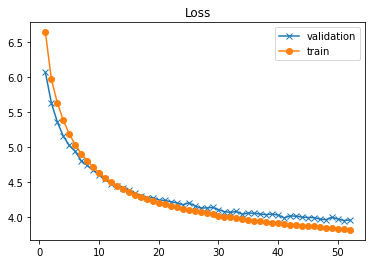

smallest val loss: (51, 3.9549875)
Current Lr:  0.000596438

Time taken for this epoch: 24.39 secs

Epoch 53 Batch 0 Loss 3.6601
Epoch 53 Batch 150 Loss 3.7540
Epoch 53 Batch 300 Loss 3.7753
Epoch 53 Batch 450 Loss 3.7906
Epoch 53 Batch 600 Loss 3.8025
Epoch 53 Batch 750 Loss 3.8141

<UNK> st ever test batsman to be once was once once once
dhoni trending on twitter today
pm modi asks pm modi to give <UNK> for <UNK>
kim kardashian <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9782254695892334 

* Train Loss 3.8166


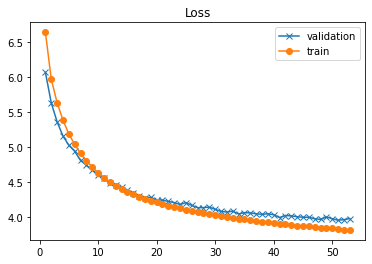

smallest val loss: (51, 3.9549875)
Current Lr:  0.0005905398

Time taken for this epoch: 24.89 secs

Epoch 54 Batch 0 Loss 3.6750
Epoch 54 Batch 150 Loss 3.7464
Epoch 54 Batch 300 Loss 3.7673
Epoch 54 Batch 450 Loss 3.7787
Epoch 54 Batch 600 Loss 3.7932
Epoch 54 Batch 750 Loss 3.8066

<UNK> st <UNK> ball was <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9779062271118164 

* Train Loss 3.8094


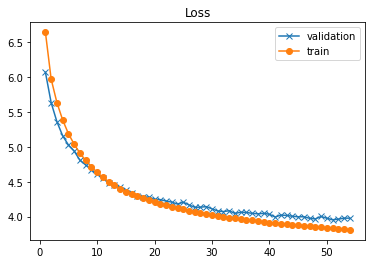

smallest val loss: (51, 3.9549875)
Current Lr:  0.00058470014

Time taken for this epoch: 24.80 secs

Epoch 55 Batch 0 Loss 3.6114
Epoch 55 Batch 150 Loss 3.7295
Epoch 55 Batch 300 Loss 3.7591
Epoch 55 Batch 450 Loss 3.7732
Epoch 55 Batch 600 Loss 3.7890
Epoch 55 Batch 750 Loss 3.8043

<UNK> st <UNK> <UNK> <UNK> in tests
ms dhoni <UNK> trending on twitter today
pm asks pm modi to give toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.9780831336975098 

* Train Loss 3.8053


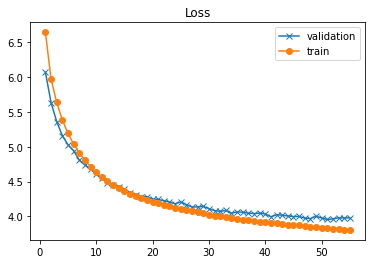

smallest val loss: (51, 3.9549875)
Current Lr:  0.00057891815

Time taken for this epoch: 24.51 secs

Epoch 56 Batch 0 Loss 3.6333
Epoch 56 Batch 150 Loss 3.7344
Epoch 56 Batch 300 Loss 3.7501
Epoch 56 Batch 450 Loss 3.7663
Epoch 56 Batch 600 Loss 3.7782
Epoch 56 Batch 750 Loss 3.7965

<UNK> st <UNK> <UNK> <UNK> <UNK> <UNK>
ms dhoni trending on twitter today
pm modi asks pm to make <UNK> for <UNK>
<UNK> korea leader <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9404053688049316 

* Train Loss 3.7974


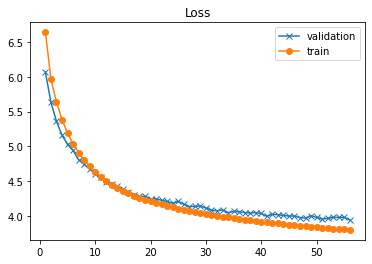

smallest val loss: (56, 3.9404054)
Current Lr:  0.00057319325

Time taken for this epoch: 24.54 secs

Epoch 57 Batch 0 Loss 3.7721
Epoch 57 Batch 150 Loss 3.7328
Epoch 57 Batch 300 Loss 3.7493
Epoch 57 Batch 450 Loss 3.7659
Epoch 57 Batch 600 Loss 3.7717
Epoch 57 Batch 750 Loss 3.7874

<UNK> st ever <UNK> <UNK> <UNK> in a test
ms dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.96640944480896 

* Train Loss 3.7897


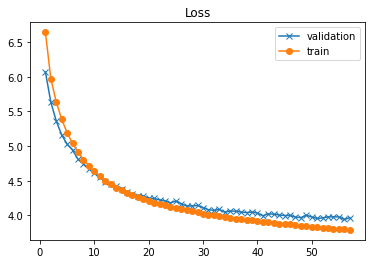

smallest val loss: (56, 3.9404054)
Current Lr:  0.00056752504

Time taken for this epoch: 24.75 secs

Epoch 58 Batch 0 Loss 3.7175
Epoch 58 Batch 150 Loss 3.7044
Epoch 58 Batch 300 Loss 3.7406
Epoch 58 Batch 450 Loss 3.7553
Epoch 58 Batch 600 Loss 3.7747
Epoch 58 Batch 750 Loss 3.7858

<UNK> st ever <UNK> <UNK> in the first test
dhoni trending on twitter today
pm modi asks pm modi to make toilets for blind toilets
kim <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.929938316345215 

* Train Loss 3.7885


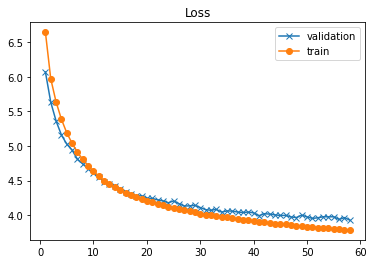

smallest val loss: (58, 3.9299383)
Current Lr:  0.0005619129

Time taken for this epoch: 24.70 secs

Epoch 59 Batch 0 Loss 3.5301
Epoch 59 Batch 150 Loss 3.7262
Epoch 59 Batch 300 Loss 3.7498
Epoch 59 Batch 450 Loss 3.7586
Epoch 59 Batch 600 Loss 3.7708
Epoch 59 Batch 750 Loss 3.7809

<UNK> st ever <UNK> <UNK> <UNK> in a day
dhoni trending on twitter today
pm modi asks pm modi to give <UNK> for poor
north korea leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.959237813949585 

* Train Loss 3.7828


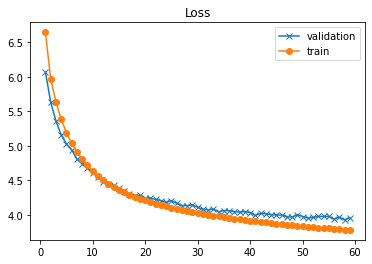

smallest val loss: (58, 3.9299383)
Current Lr:  0.00055635616

Time taken for this epoch: 24.68 secs

Epoch 60 Batch 0 Loss 3.4857
Epoch 60 Batch 150 Loss 3.7119
Epoch 60 Batch 300 Loss 3.7341
Epoch 60 Batch 450 Loss 3.7468
Epoch 60 Batch 600 Loss 3.7656
Epoch 60 Batch 750 Loss 3.7780

first ever ball ball was <UNK> on this day
dhoni trending on twitter today
pm modi asks pm to make <UNK> for poor
<UNK> korea leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9358606338500977 

* Train Loss 3.7782


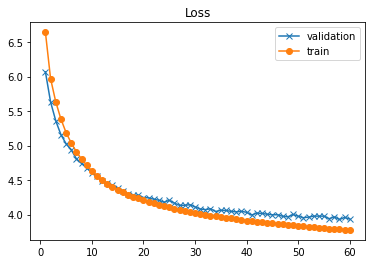

smallest val loss: (58, 3.9299383)
Current Lr:  0.0005508545

Time taken for this epoch: 24.86 secs

Epoch 61 Batch 0 Loss 3.6413
Epoch 61 Batch 150 Loss 3.7052
Epoch 61 Batch 300 Loss 3.7192
Epoch 61 Batch 450 Loss 3.7441
Epoch 61 Batch 600 Loss 3.7555
Epoch 61 Batch 750 Loss 3.7679

<UNK> st <UNK> <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9463698863983154 

* Train Loss 3.7696


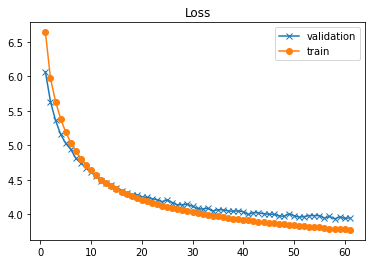

smallest val loss: (58, 3.9299383)
Current Lr:  0.0005454071

Time taken for this epoch: 24.30 secs

Epoch 62 Batch 0 Loss 3.8393
Epoch 62 Batch 150 Loss 3.6876
Epoch 62 Batch 300 Loss 3.7097
Epoch 62 Batch 450 Loss 3.7352
Epoch 62 Batch 600 Loss 3.7475
Epoch 62 Batch 750 Loss 3.7616

<UNK> st ever <UNK> <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi asks people to make <UNK> for <UNK>
kim kim kim <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9489173889160156 

* Train Loss 3.7641


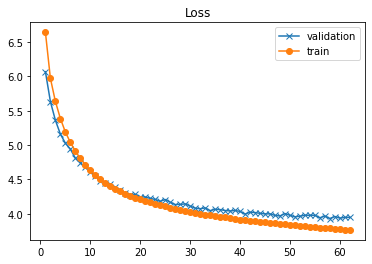

smallest val loss: (58, 3.9299383)
Current Lr:  0.00054001366

Time taken for this epoch: 24.32 secs

Epoch 63 Batch 0 Loss 3.7767
Epoch 63 Batch 150 Loss 3.6898
Epoch 63 Batch 300 Loss 3.7120
Epoch 63 Batch 450 Loss 3.7305
Epoch 63 Batch 600 Loss 3.7449
Epoch 63 Batch 750 Loss 3.7567

<UNK> st ever <UNK> <UNK> <UNK> in the history
dhoni trending on twitter today
pm modi asks pm modi to make <UNK> for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9516539573669434 

* Train Loss 3.7604


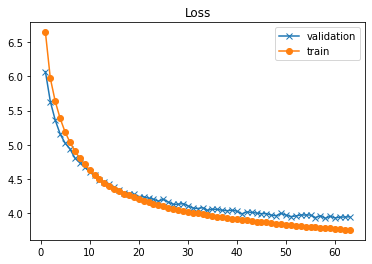

smallest val loss: (58, 3.9299383)
Current Lr:  0.0005346735

Time taken for this epoch: 25.29 secs

Epoch 64 Batch 0 Loss 3.3317
Epoch 64 Batch 150 Loss 3.6828
Epoch 64 Batch 300 Loss 3.7110
Epoch 64 Batch 450 Loss 3.7204
Epoch 64 Batch 600 Loss 3.7339
Epoch 64 Batch 750 Loss 3.7483

<UNK> st <UNK> ball was <UNK> on this day
dhoni trending on twitter today
pm asks pm modi to make <UNK> for poor
kim kim kim <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.938284158706665 

* Train Loss 3.7523


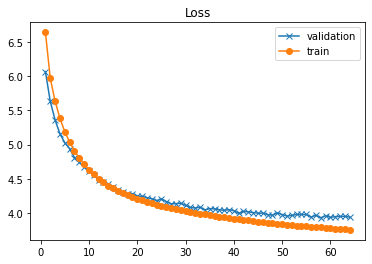

smallest val loss: (58, 3.9299383)
Current Lr:  0.0005293862

Time taken for this epoch: 24.26 secs

Epoch 65 Batch 0 Loss 3.5871
Epoch 65 Batch 150 Loss 3.6884
Epoch 65 Batch 300 Loss 3.6963
Epoch 65 Batch 450 Loss 3.7178
Epoch 65 Batch 600 Loss 3.7320
Epoch 65 Batch 750 Loss 3.7463

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks pm modi to make <UNK> for poor
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.91569447517395 

* Train Loss 3.7497


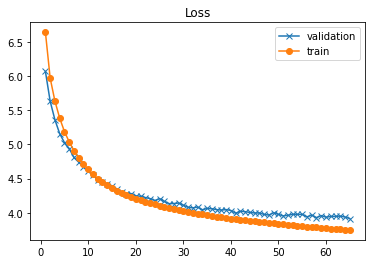

smallest val loss: (65, 3.9156945)
Current Lr:  0.0005241512

Time taken for this epoch: 24.45 secs

Epoch 66 Batch 0 Loss 3.5399
Epoch 66 Batch 150 Loss 3.6730
Epoch 66 Batch 300 Loss 3.7065
Epoch 66 Batch 450 Loss 3.7219
Epoch 66 Batch 600 Loss 3.7316
Epoch 66 Batch 750 Loss 3.7437

<UNK> st <UNK> to win a ball of the ball of the
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9225664138793945 

* Train Loss 3.7452


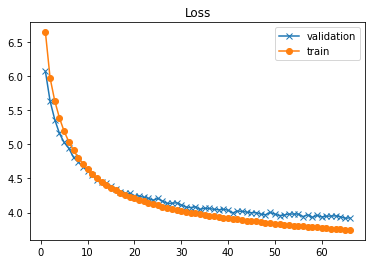

smallest val loss: (65, 3.9156945)
Current Lr:  0.000518968

Time taken for this epoch: 24.78 secs

Epoch 67 Batch 0 Loss 3.4262
Epoch 67 Batch 150 Loss 3.6756
Epoch 67 Batch 300 Loss 3.6889
Epoch 67 Batch 450 Loss 3.7110
Epoch 67 Batch 600 Loss 3.7241
Epoch 67 Batch 750 Loss 3.7373

<UNK> st <UNK> <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9125661849975586 

* Train Loss 3.7403


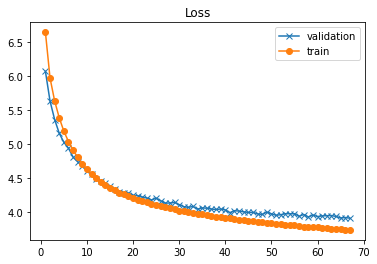

smallest val loss: (67, 3.9125662)
Current Lr:  0.0005138359

Time taken for this epoch: 24.59 secs

Epoch 68 Batch 0 Loss 3.5120
Epoch 68 Batch 150 Loss 3.6676
Epoch 68 Batch 300 Loss 3.6833
Epoch 68 Batch 450 Loss 3.7029
Epoch 68 Batch 600 Loss 3.7166
Epoch 68 Batch 750 Loss 3.7315

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm asks pm modi to make toilets for <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.928518772125244 

* Train Loss 3.7346


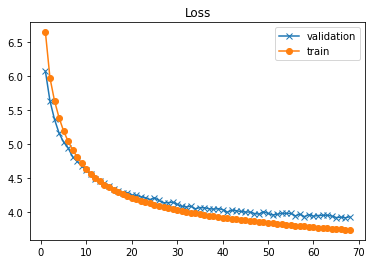

smallest val loss: (67, 3.9125662)
Current Lr:  0.0005087547

Time taken for this epoch: 24.29 secs

Epoch 69 Batch 0 Loss 3.7245
Epoch 69 Batch 150 Loss 3.6782
Epoch 69 Batch 300 Loss 3.6903
Epoch 69 Batch 450 Loss 3.6996
Epoch 69 Batch 600 Loss 3.7176
Epoch 69 Batch 750 Loss 3.7293

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for blind toilets
<UNK> korean leader <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.925848960876465 

* Train Loss 3.7318


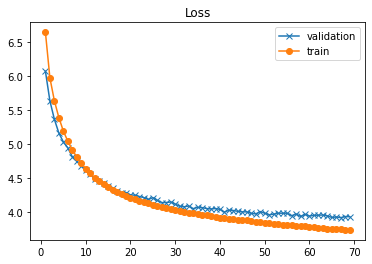

smallest val loss: (67, 3.9125662)
Current Lr:  0.00050372374

Time taken for this epoch: 24.76 secs

Epoch 70 Batch 0 Loss 3.4758
Epoch 70 Batch 150 Loss 3.6580
Epoch 70 Batch 300 Loss 3.6818
Epoch 70 Batch 450 Loss 3.6950
Epoch 70 Batch 600 Loss 3.7091
Epoch 70 Batch 750 Loss 3.7236

<UNK> st <UNK> to take a ton on this day
dhoni trending on twitter today
pm modi asks pm to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8984947204589844 

* Train Loss 3.7253


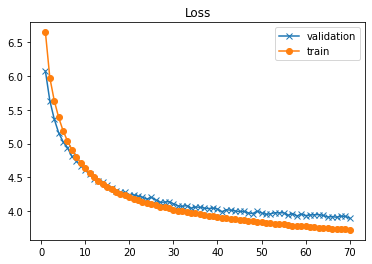

smallest val loss: (70, 3.8984947)
Current Lr:  0.0004987425

Time taken for this epoch: 24.80 secs

Epoch 71 Batch 0 Loss 3.7156
Epoch 71 Batch 150 Loss 3.6595
Epoch 71 Batch 300 Loss 3.6799
Epoch 71 Batch 450 Loss 3.6945
Epoch 71 Batch 600 Loss 3.7091
Epoch 71 Batch 750 Loss 3.7215

<UNK> st <UNK> hattrick on this day
dhoni trending on twitter today
pm modi asks pm to make toilet for students
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.90910267829895 

* Train Loss 3.7227


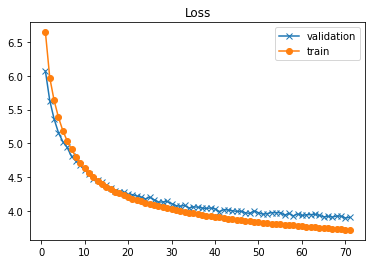

smallest val loss: (70, 3.8984947)
Current Lr:  0.0004938104

Time taken for this epoch: 24.58 secs

Epoch 72 Batch 0 Loss 3.5941
Epoch 72 Batch 150 Loss 3.6567
Epoch 72 Batch 300 Loss 3.6631
Epoch 72 Batch 450 Loss 3.6861
Epoch 72 Batch 600 Loss 3.7010
Epoch 72 Batch 750 Loss 3.7107

<UNK> st <UNK> ball on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for blind
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9251868724823 

* Train Loss 3.7147


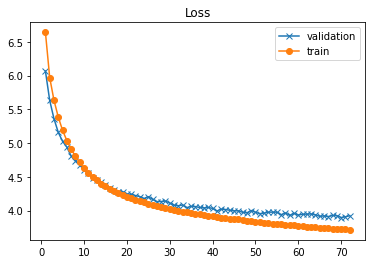

smallest val loss: (70, 3.8984947)
Current Lr:  0.0004889273

Time taken for this epoch: 24.46 secs

Epoch 73 Batch 0 Loss 3.5381
Epoch 73 Batch 150 Loss 3.6372
Epoch 73 Batch 300 Loss 3.6693
Epoch 73 Batch 450 Loss 3.6800
Epoch 73 Batch 600 Loss 3.6956
Epoch 73 Batch 750 Loss 3.7091

<UNK> st <UNK> <UNK> <UNK> on this day
ms dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8977792263031006 

* Train Loss 3.7110


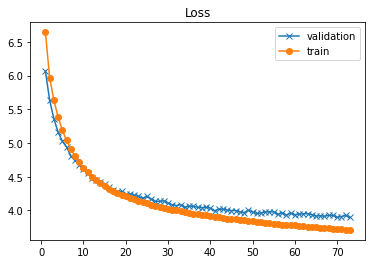

smallest val loss: (73, 3.8977792)
Current Lr:  0.00048409228

Time taken for this epoch: 25.21 secs

Epoch 74 Batch 0 Loss 3.5283
Epoch 74 Batch 150 Loss 3.6272
Epoch 74 Batch 300 Loss 3.6565
Epoch 74 Batch 450 Loss 3.6736
Epoch 74 Batch 600 Loss 3.6908
Epoch 74 Batch 750 Loss 3.7041

warne st bowler to win his first ball ball on this day
ms dhoni trending on twitter today
pm modi asks pm modi to make toilets for toilet
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.904099225997925 

* Train Loss 3.7062


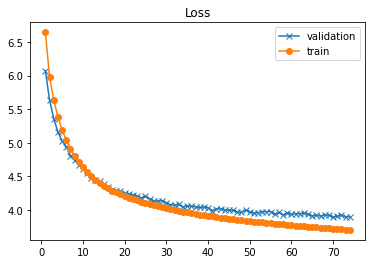

smallest val loss: (73, 3.8977792)
Current Lr:  0.00047930522

Time taken for this epoch: 25.02 secs

Epoch 75 Batch 0 Loss 3.6345
Epoch 75 Batch 150 Loss 3.6364
Epoch 75 Batch 300 Loss 3.6536
Epoch 75 Batch 450 Loss 3.6677
Epoch 75 Batch 600 Loss 3.6861
Epoch 75 Batch 750 Loss 3.6985

warne st bowler to win his first ball of his st ball
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.897916555404663 

* Train Loss 3.7014


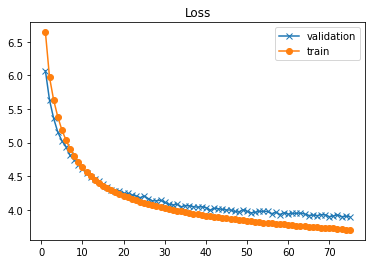

smallest val loss: (73, 3.8977792)
Current Lr:  0.00047456537

Time taken for this epoch: 25.04 secs

Epoch 76 Batch 0 Loss 3.6441
Epoch 76 Batch 150 Loss 3.6238
Epoch 76 Batch 300 Loss 3.6544
Epoch 76 Batch 450 Loss 3.6700
Epoch 76 Batch 600 Loss 3.6855
Epoch 76 Batch 750 Loss 3.6970

<UNK> st <UNK> century on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.896639108657837 

* Train Loss 3.6989


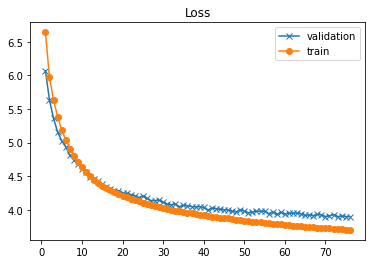

smallest val loss: (76, 3.896639)
Current Lr:  0.00046987247

Time taken for this epoch: 24.08 secs

Epoch 77 Batch 0 Loss 3.6656
Epoch 77 Batch 150 Loss 3.6274
Epoch 77 Batch 300 Loss 3.6540
Epoch 77 Batch 450 Loss 3.6674
Epoch 77 Batch 600 Loss 3.6837
Epoch 77 Batch 750 Loss 3.6894

<UNK> st ever <UNK> <UNK> on this day
ms dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
<UNK> leader <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.913052558898926 

* Train Loss 3.6916


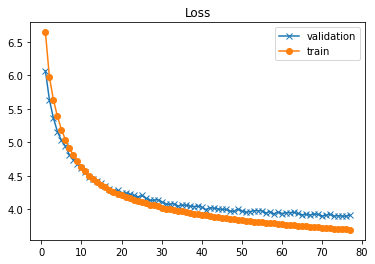

smallest val loss: (76, 3.896639)
Current Lr:  0.000465226

Time taken for this epoch: 24.86 secs

Epoch 78 Batch 0 Loss 3.6049
Epoch 78 Batch 150 Loss 3.6232
Epoch 78 Batch 300 Loss 3.6508
Epoch 78 Batch 450 Loss 3.6620
Epoch 78 Batch 600 Loss 3.6761
Epoch 78 Batch 750 Loss 3.6875

warne st <UNK> to win a ball on this day
ms dhoni trending on twitter today
pm asks pm modi to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9256041049957275 

* Train Loss 3.6900


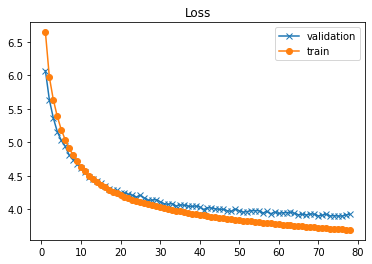

smallest val loss: (76, 3.896639)
Current Lr:  0.0004606254

Time taken for this epoch: 24.70 secs

Epoch 79 Batch 0 Loss 3.5254
Epoch 79 Batch 150 Loss 3.6171
Epoch 79 Batch 300 Loss 3.6420
Epoch 79 Batch 450 Loss 3.6585
Epoch 79 Batch 600 Loss 3.6728
Epoch 79 Batch 750 Loss 3.6844

<UNK> st <UNK> to win a ball on this day
ms dhoni trending on twitter today
pm modi asks pm modi to make <UNK> for <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.887944221496582 

* Train Loss 3.6868

Saving checkpoint for epoch 79 at checkpoints4/ckpt-14


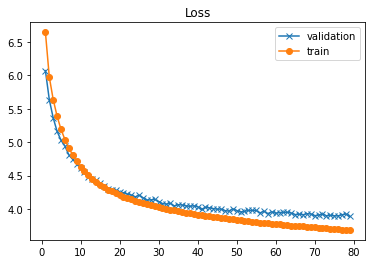

smallest val loss: (79, 3.8879442)
Current Lr:  0.00045607038

Time taken for this epoch: 25.46 secs

Epoch 80 Batch 0 Loss 3.3831
Epoch 80 Batch 150 Loss 3.6051
Epoch 80 Batch 300 Loss 3.6275
Epoch 80 Batch 450 Loss 3.6496
Epoch 80 Batch 600 Loss 3.6627
Epoch 80 Batch 750 Loss 3.6798

<UNK> st <UNK> <UNK> <UNK> on this day
ms dhoni trending on twitter today
pm modi asks pm modi to make toilets for blind
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.9050018787384033 

* Train Loss 3.6807


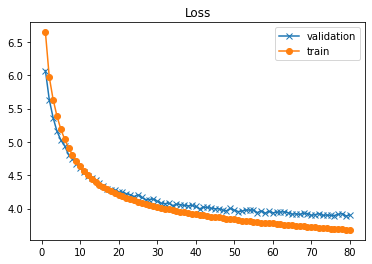

smallest val loss: (79, 3.8879442)
Current Lr:  0.0004515604

Time taken for this epoch: 24.31 secs

Epoch 81 Batch 0 Loss 3.6012
Epoch 81 Batch 150 Loss 3.6103
Epoch 81 Batch 300 Loss 3.6322
Epoch 81 Batch 450 Loss 3.6497
Epoch 81 Batch 600 Loss 3.6668
Epoch 81 Batch 750 Loss 3.6769

warne st bowler to take wickets on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.89662766456604 

* Train Loss 3.6803


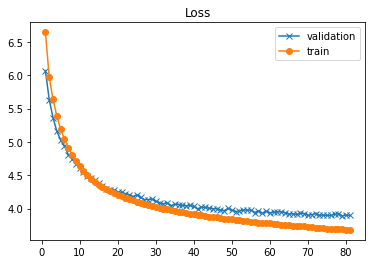

smallest val loss: (79, 3.8879442)
Current Lr:  0.00044709494

Time taken for this epoch: 24.61 secs

Epoch 82 Batch 0 Loss 3.3819
Epoch 82 Batch 150 Loss 3.6097
Epoch 82 Batch 300 Loss 3.6333
Epoch 82 Batch 450 Loss 3.6489
Epoch 82 Batch 600 Loss 3.6618
Epoch 82 Batch 750 Loss 3.6715

<UNK> st <UNK> <UNK> in the first test cricket
dhoni trending on twitter today
pm urges pm modi to make toilet for <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8809282779693604 

* Train Loss 3.6738


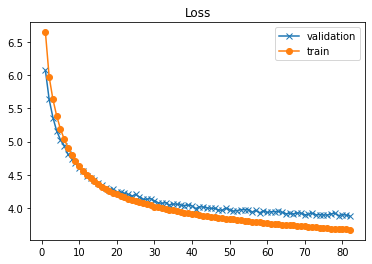

smallest val loss: (82, 3.8809283)
Current Lr:  0.00044267369

Time taken for this epoch: 24.51 secs

Epoch 83 Batch 0 Loss 3.4444
Epoch 83 Batch 150 Loss 3.5841
Epoch 83 Batch 300 Loss 3.6160
Epoch 83 Batch 450 Loss 3.6399
Epoch 83 Batch 600 Loss 3.6529
Epoch 83 Batch 750 Loss 3.6655

<UNK> st <UNK> test century on this day
ms dhoni trending on twitter today
pm modi asks people to make <UNK> for poor
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.904737949371338 

* Train Loss 3.6690


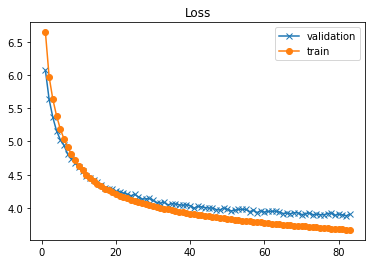

smallest val loss: (82, 3.8809283)
Current Lr:  0.00043829618

Time taken for this epoch: 25.18 secs

Epoch 84 Batch 0 Loss 3.5767
Epoch 84 Batch 150 Loss 3.6076
Epoch 84 Batch 300 Loss 3.6281
Epoch 84 Batch 450 Loss 3.6365
Epoch 84 Batch 600 Loss 3.6505
Epoch 84 Batch 750 Loss 3.6629

warne st to score <UNK> <UNK> on this day
ms dhoni <UNK> trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.885993242263794 

* Train Loss 3.6658


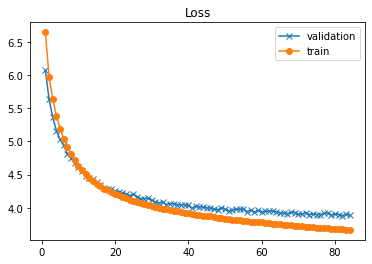

smallest val loss: (82, 3.8809283)
Current Lr:  0.00043396192

Time taken for this epoch: 24.40 secs

Epoch 85 Batch 0 Loss 3.4381
Epoch 85 Batch 150 Loss 3.5970
Epoch 85 Batch 300 Loss 3.6175
Epoch 85 Batch 450 Loss 3.6337
Epoch 85 Batch 600 Loss 3.6432
Epoch 85 Batch 750 Loss 3.6602

<UNK> st <UNK> <UNK> <UNK> on this day
ms dhoni trending on twitter today
pm modi asks for <UNK> <UNK> for blind toilets
kim kardashian was <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.861989736557007 

* Train Loss 3.6622


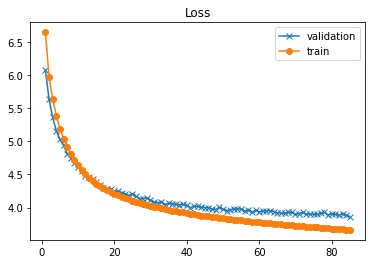

smallest val loss: (85, 3.8619897)
Current Lr:  0.0004296705

Time taken for this epoch: 24.80 secs

Epoch 86 Batch 0 Loss 3.8735
Epoch 86 Batch 150 Loss 3.5857
Epoch 86 Batch 300 Loss 3.6160
Epoch 86 Batch 450 Loss 3.6306
Epoch 86 Batch 600 Loss 3.6467
Epoch 86 Batch 750 Loss 3.6575

<UNK> st bowler to win a ball on this day
ms dhoni trending on twitter today
pm modi asks for <UNK> <UNK> for <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.89508056640625 

* Train Loss 3.6584


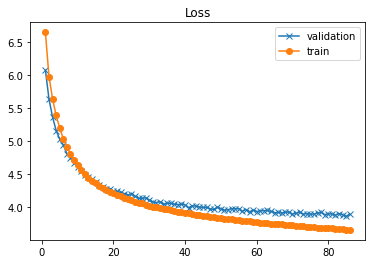

smallest val loss: (85, 3.8619897)
Current Lr:  0.00042542157

Time taken for this epoch: 24.88 secs

Epoch 87 Batch 0 Loss 3.7861
Epoch 87 Batch 150 Loss 3.5783
Epoch 87 Batch 300 Loss 3.6139
Epoch 87 Batch 450 Loss 3.6272
Epoch 87 Batch 600 Loss 3.6398
Epoch 87 Batch 750 Loss 3.6516

warne was st to take a <UNK> catch on this day
ms dhoni trending on twitter today
pm modi asks for <UNK> <UNK> for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8761346340179443 

* Train Loss 3.6541


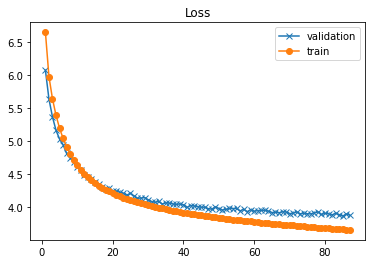

smallest val loss: (85, 3.8619897)
Current Lr:  0.0004212146

Time taken for this epoch: 24.89 secs

Epoch 88 Batch 0 Loss 3.6753
Epoch 88 Batch 150 Loss 3.5871
Epoch 88 Batch 300 Loss 3.6091
Epoch 88 Batch 450 Loss 3.6255
Epoch 88 Batch 600 Loss 3.6388
Epoch 88 Batch 750 Loss 3.6503

warne st <UNK> <UNK> century on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for blind
<UNK> leader <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.875452995300293 

* Train Loss 3.6522


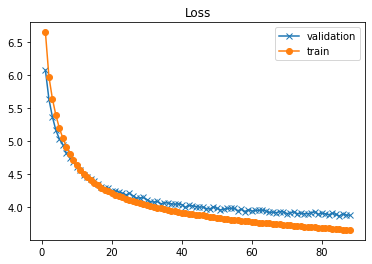

smallest val loss: (85, 3.8619897)
Current Lr:  0.00041704928

Time taken for this epoch: 24.53 secs

Epoch 89 Batch 0 Loss 3.4899
Epoch 89 Batch 150 Loss 3.5885
Epoch 89 Batch 300 Loss 3.5989
Epoch 89 Batch 450 Loss 3.6222
Epoch 89 Batch 600 Loss 3.6317
Epoch 89 Batch 750 Loss 3.6480

mcgrath was st to take a ball on this day
ms dhoni trending on twitter today
pm modi asks for <UNK> for <UNK>
kim kardashian was <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.853508710861206 

* Train Loss 3.6491


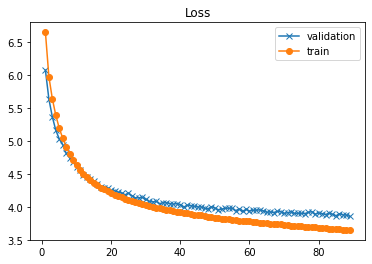

smallest val loss: (89, 3.8535087)
Current Lr:  0.00041292518

Time taken for this epoch: 24.77 secs

Epoch 90 Batch 0 Loss 3.6947
Epoch 90 Batch 150 Loss 3.5846
Epoch 90 Batch 300 Loss 3.6025
Epoch 90 Batch 450 Loss 3.6213
Epoch 90 Batch 600 Loss 3.6285
Epoch 90 Batch 750 Loss 3.6400

<UNK> first wicket to take wickets on this day
dhoni trending on twitter today
pm modi thanks people for <UNK> <UNK>
kim jongnams <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8862433433532715 

* Train Loss 3.6423


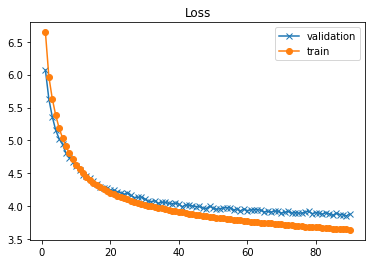

smallest val loss: (89, 3.8535087)
Current Lr:  0.0004088418

Time taken for this epoch: 24.40 secs

Epoch 91 Batch 0 Loss 3.7569
Epoch 91 Batch 150 Loss 3.5804
Epoch 91 Batch 300 Loss 3.6044
Epoch 91 Batch 450 Loss 3.6167
Epoch 91 Batch 600 Loss 3.6210
Epoch 91 Batch 750 Loss 3.6347

warne scored the first <UNK> ball on this day
dhoni trending on twitter today
pm asks pm modi to make toilets for <UNK>
<UNK> leader <UNK> <UNK> born on christmas

validation started ...

* Validation loss: 3.8796746730804443 

* Train Loss 3.6377


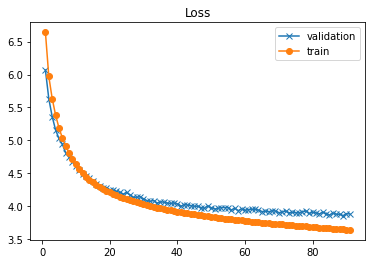

smallest val loss: (89, 3.8535087)
Current Lr:  0.00040479883

Time taken for this epoch: 24.80 secs

Epoch 92 Batch 0 Loss 3.5773
Epoch 92 Batch 150 Loss 3.5764
Epoch 92 Batch 300 Loss 3.5975
Epoch 92 Batch 450 Loss 3.6112
Epoch 92 Batch 600 Loss 3.6220
Epoch 92 Batch 750 Loss 3.6346

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks people for <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.895702362060547 

* Train Loss 3.6357


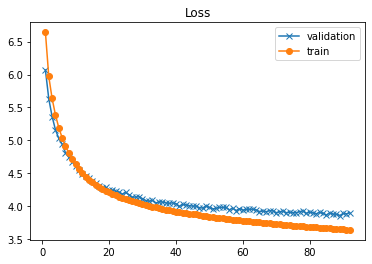

smallest val loss: (89, 3.8535087)
Current Lr:  0.00040079583

Time taken for this epoch: 24.21 secs

Epoch 93 Batch 0 Loss 3.4915
Epoch 93 Batch 150 Loss 3.5622
Epoch 93 Batch 300 Loss 3.5903
Epoch 93 Batch 450 Loss 3.6059
Epoch 93 Batch 600 Loss 3.6211
Epoch 93 Batch 750 Loss 3.6314

<UNK> st bowler to score <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8766417503356934 

* Train Loss 3.6328


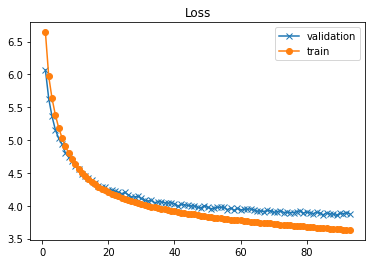

smallest val loss: (89, 3.8535087)
Current Lr:  0.00039683245

Time taken for this epoch: 24.63 secs

Epoch 94 Batch 0 Loss 3.4578
Epoch 94 Batch 150 Loss 3.5587
Epoch 94 Batch 300 Loss 3.5887
Epoch 94 Batch 450 Loss 3.6045
Epoch 94 Batch 600 Loss 3.6153
Epoch 94 Batch 750 Loss 3.6267

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks pm to make toilets for <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.887936592102051 

* Train Loss 3.6283


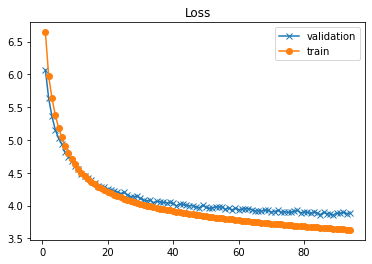

smallest val loss: (89, 3.8535087)
Current Lr:  0.00039290817

Time taken for this epoch: 24.49 secs

Epoch 95 Batch 0 Loss 3.5530
Epoch 95 Batch 150 Loss 3.5587
Epoch 95 Batch 300 Loss 3.5837
Epoch 95 Batch 450 Loss 3.5992
Epoch 95 Batch 600 Loss 3.6098
Epoch 95 Batch 750 Loss 3.6217

<UNK> st <UNK> bowling on this day
dhoni trending on twitter today
pm modi asks people to make toilets for poor
kim kardashian was <UNK> on christmas eve

validation started ...

* Validation loss: 3.8716728687286377 

* Train Loss 3.6236


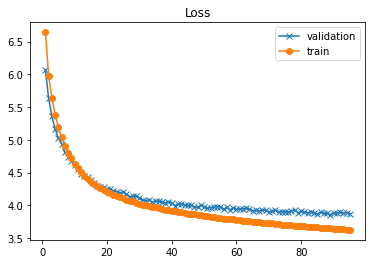

smallest val loss: (89, 3.8535087)
Current Lr:  0.00038902278

Time taken for this epoch: 24.36 secs

Epoch 96 Batch 0 Loss 3.4038
Epoch 96 Batch 150 Loss 3.5464
Epoch 96 Batch 300 Loss 3.5742
Epoch 96 Batch 450 Loss 3.5938
Epoch 96 Batch 600 Loss 3.6042
Epoch 96 Batch 750 Loss 3.6191

warne st to score <UNK> bowling on this day
ms dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK> on <UNK>

validation started ...

* Validation loss: 3.863253593444824 

* Train Loss 3.6222


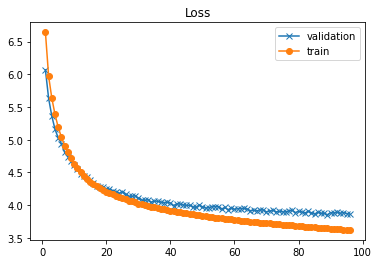

smallest val loss: (89, 3.8535087)
Current Lr:  0.00038517575

Time taken for this epoch: 25.27 secs

Epoch 97 Batch 0 Loss 3.4544
Epoch 97 Batch 150 Loss 3.5546
Epoch 97 Batch 300 Loss 3.5763
Epoch 97 Batch 450 Loss 3.5918
Epoch 97 Batch 600 Loss 3.6013
Epoch 97 Batch 750 Loss 3.6146

<UNK> st <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi urges pm modi to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8649301528930664 

* Train Loss 3.6172


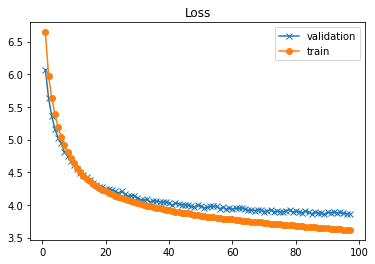

smallest val loss: (89, 3.8535087)
Current Lr:  0.00038136684

Time taken for this epoch: 24.33 secs

Epoch 98 Batch 0 Loss 3.6813
Epoch 98 Batch 150 Loss 3.5511
Epoch 98 Batch 300 Loss 3.5660
Epoch 98 Batch 450 Loss 3.5867
Epoch 98 Batch 600 Loss 3.5988
Epoch 98 Batch 750 Loss 3.6099

warne was st to win a balls on this day
dhoni trending on twitter today
pm modi asks for <UNK> <UNK> for <UNK>
<UNK> leader <UNK> <UNK> born on <UNK>

validation started ...

* Validation loss: 3.8826141357421875 

* Train Loss 3.6134


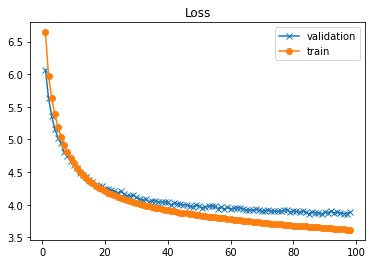

smallest val loss: (89, 3.8535087)
Current Lr:  0.00037759557

Time taken for this epoch: 24.63 secs

Epoch 99 Batch 0 Loss 3.5510
Epoch 99 Batch 150 Loss 3.5463
Epoch 99 Batch 300 Loss 3.5687
Epoch 99 Batch 450 Loss 3.5869
Epoch 99 Batch 600 Loss 3.5962
Epoch 99 Batch 750 Loss 3.6088

mcgrath st to take a <UNK> <UNK> run on this day
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8448572158813477 

* Train Loss 3.6101


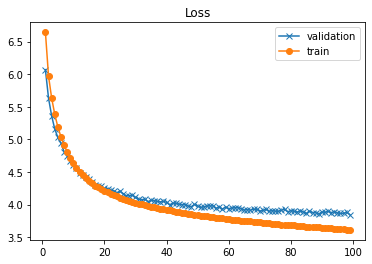

smallest val loss: (99, 3.8448572)
Current Lr:  0.0003738616

Time taken for this epoch: 24.59 secs

Epoch 100 Batch 0 Loss 3.6222
Epoch 100 Batch 150 Loss 3.5452
Epoch 100 Batch 300 Loss 3.5651
Epoch 100 Batch 450 Loss 3.5848
Epoch 100 Batch 600 Loss 3.5950
Epoch 100 Batch 750 Loss 3.6073

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets
<UNK> leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.866581678390503 

* Train Loss 3.6092


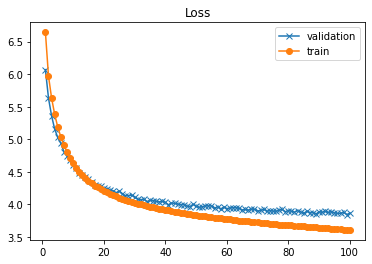

smallest val loss: (99, 3.8448572)
Current Lr:  0.00037016446

Time taken for this epoch: 24.96 secs

Epoch 101 Batch 0 Loss 3.4482
Epoch 101 Batch 150 Loss 3.5356
Epoch 101 Batch 300 Loss 3.5607
Epoch 101 Batch 450 Loss 3.5743
Epoch 101 Batch 600 Loss 3.5864
Epoch 101 Batch 750 Loss 3.6036

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.858574867248535 

* Train Loss 3.6052


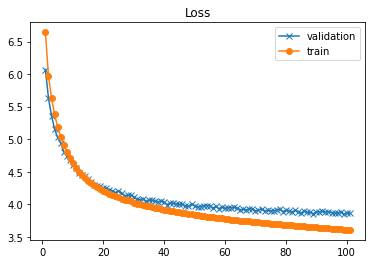

smallest val loss: (99, 3.8448572)
Current Lr:  0.00036650398

Time taken for this epoch: 24.18 secs

Epoch 102 Batch 0 Loss 3.4306
Epoch 102 Batch 150 Loss 3.5374
Epoch 102 Batch 300 Loss 3.5565
Epoch 102 Batch 450 Loss 3.5756
Epoch 102 Batch 600 Loss 3.5871
Epoch 102 Batch 750 Loss 3.5951

warne st to win a ball on this day
ms dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8669662475585938 

* Train Loss 3.5974


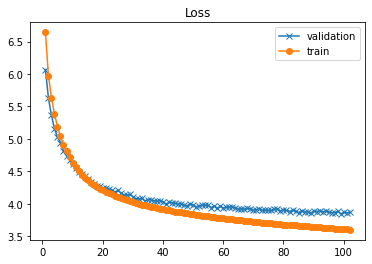

smallest val loss: (99, 3.8448572)
Current Lr:  0.00036287968

Time taken for this epoch: 24.67 secs

Epoch 103 Batch 0 Loss 3.3514
Epoch 103 Batch 150 Loss 3.5311
Epoch 103 Batch 300 Loss 3.5525
Epoch 103 Batch 450 Loss 3.5698
Epoch 103 Batch 600 Loss 3.5837
Epoch 103 Batch 750 Loss 3.5944

warne was st to take a wicket on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets on <UNK>
<UNK> korea leader <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.845320701599121 

* Train Loss 3.5950


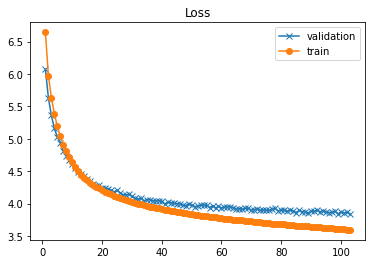

smallest val loss: (99, 3.8448572)
Current Lr:  0.00035929127

Time taken for this epoch: 24.84 secs

Epoch 104 Batch 0 Loss 3.4219
Epoch 104 Batch 150 Loss 3.5344
Epoch 104 Batch 300 Loss 3.5560
Epoch 104 Batch 450 Loss 3.5684
Epoch 104 Batch 600 Loss 3.5798
Epoch 104 Batch 750 Loss 3.5935

warne scored a ball on this day
dhoni trending on twitter today
pm modi thanks <UNK> for <UNK> <UNK>
<UNK> leader <UNK> <UNK> was <UNK>

validation started ...

* Validation loss: 3.8451039791107178 

* Train Loss 3.5957


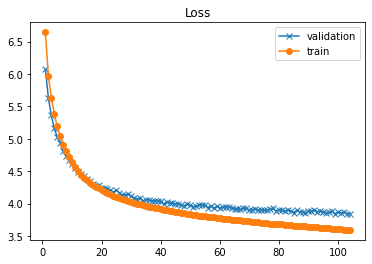

smallest val loss: (99, 3.8448572)
Current Lr:  0.00035573827

Time taken for this epoch: 24.01 secs

Epoch 105 Batch 0 Loss 3.2788
Epoch 105 Batch 150 Loss 3.5197
Epoch 105 Batch 300 Loss 3.5383
Epoch 105 Batch 450 Loss 3.5597
Epoch 105 Batch 600 Loss 3.5733
Epoch 105 Batch 750 Loss 3.5882

warne scored a <UNK> <UNK> on this day
dhoni trending on twitter today
pm thanks pm modi for <UNK> toilets
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8438501358032227 

* Train Loss 3.5901


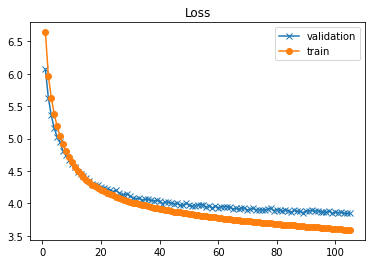

smallest val loss: (105, 3.8438501)
Current Lr:  0.00035222038

Time taken for this epoch: 24.28 secs

Epoch 106 Batch 0 Loss 3.2549
Epoch 106 Batch 150 Loss 3.5301
Epoch 106 Batch 300 Loss 3.5447
Epoch 106 Batch 450 Loss 3.5599
Epoch 106 Batch 600 Loss 3.5747
Epoch 106 Batch 750 Loss 3.5872

warne scored a <UNK> bowling on this day
dhoni trending on twitter today
pm modi thanks people for <UNK> toilets
kim <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8650498390197754 

* Train Loss 3.5871


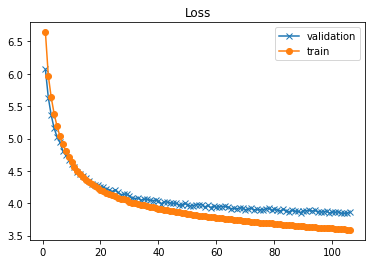

smallest val loss: (105, 3.8438501)
Current Lr:  0.0003487373

Time taken for this epoch: 24.15 secs

Epoch 107 Batch 0 Loss 3.3525
Epoch 107 Batch 150 Loss 3.5285
Epoch 107 Batch 300 Loss 3.5350
Epoch 107 Batch 450 Loss 3.5535
Epoch 107 Batch 600 Loss 3.5699
Epoch 107 Batch 750 Loss 3.5846

<UNK> st <UNK> <UNK> to win a wicket on this day
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> korea leader <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8619377613067627 

* Train Loss 3.5855


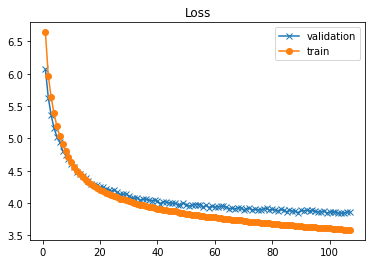

smallest val loss: (105, 3.8438501)
Current Lr:  0.00034528872

Time taken for this epoch: 24.53 secs

Epoch 108 Batch 0 Loss 3.4947
Epoch 108 Batch 150 Loss 3.5110
Epoch 108 Batch 300 Loss 3.5381
Epoch 108 Batch 450 Loss 3.5540
Epoch 108 Batch 600 Loss 3.5669
Epoch 108 Batch 750 Loss 3.5806

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks people to make toilet for <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8546128273010254 

* Train Loss 3.5818


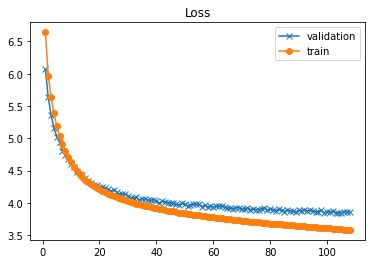

smallest val loss: (105, 3.8438501)
Current Lr:  0.00034187423

Time taken for this epoch: 24.73 secs

Epoch 109 Batch 0 Loss 3.2929
Epoch 109 Batch 150 Loss 3.5165
Epoch 109 Batch 300 Loss 3.5400
Epoch 109 Batch 450 Loss 3.5534
Epoch 109 Batch 600 Loss 3.5644
Epoch 109 Batch 750 Loss 3.5780

<UNK> st bowler to win his first ball on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8653485774993896 

* Train Loss 3.5793


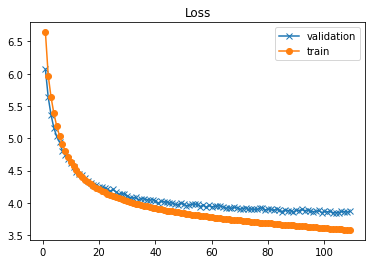

smallest val loss: (105, 3.8438501)
Current Lr:  0.00033849347

Time taken for this epoch: 25.33 secs

Epoch 110 Batch 0 Loss 3.6454
Epoch 110 Batch 150 Loss 3.5249
Epoch 110 Batch 300 Loss 3.5385
Epoch 110 Batch 450 Loss 3.5544
Epoch 110 Batch 600 Loss 3.5636
Epoch 110 Batch 750 Loss 3.5742

warne st bowler to take wickets on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8292551040649414 

* Train Loss 3.5754


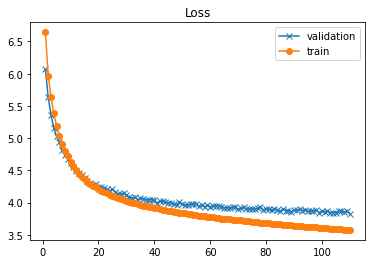

smallest val loss: (110, 3.829255)
Current Lr:  0.00033514618

Time taken for this epoch: 24.38 secs

Epoch 111 Batch 0 Loss 3.5954
Epoch 111 Batch 150 Loss 3.5150
Epoch 111 Batch 300 Loss 3.5298
Epoch 111 Batch 450 Loss 3.5499
Epoch 111 Batch 600 Loss 3.5575
Epoch 111 Batch 750 Loss 3.5673

<UNK> st bowler to take out on this day
dhoni trending on twitter today
pm asks pm to make toilets for <UNK>
<UNK> leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8582122325897217 

* Train Loss 3.5695


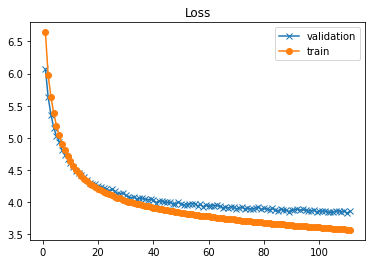

smallest val loss: (110, 3.829255)
Current Lr:  0.0003318319

Time taken for this epoch: 24.31 secs

Epoch 112 Batch 0 Loss 3.2696
Epoch 112 Batch 150 Loss 3.5259
Epoch 112 Batch 300 Loss 3.5329
Epoch 112 Batch 450 Loss 3.5413
Epoch 112 Batch 600 Loss 3.5557
Epoch 112 Batch 750 Loss 3.5672

<UNK> st ever <UNK> wicket on this day
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
kim kim <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.851529598236084 

* Train Loss 3.5686


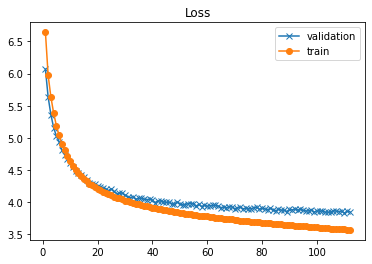

smallest val loss: (110, 3.829255)
Current Lr:  0.00032855044

Time taken for this epoch: 24.44 secs

Epoch 113 Batch 0 Loss 3.5828
Epoch 113 Batch 150 Loss 3.5052
Epoch 113 Batch 300 Loss 3.5221
Epoch 113 Batch 450 Loss 3.5298
Epoch 113 Batch 600 Loss 3.5464
Epoch 113 Batch 750 Loss 3.5616

<UNK> st <UNK> <UNK> <UNK> on this day
ms dhoni trending on twitter today
pm modi congratulates pm for <UNK> toilets for <UNK>
<UNK> korean leader was <UNK> on christmas

validation started ...

* Validation loss: 3.841594696044922 

* Train Loss 3.5659


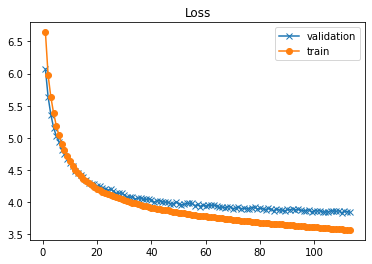

smallest val loss: (110, 3.829255)
Current Lr:  0.00032530155

Time taken for this epoch: 24.68 secs

Epoch 114 Batch 0 Loss 3.5626
Epoch 114 Batch 150 Loss 3.5079
Epoch 114 Batch 300 Loss 3.5233
Epoch 114 Batch 450 Loss 3.5369
Epoch 114 Batch 600 Loss 3.5472
Epoch 114 Batch 750 Loss 3.5601

<UNK> st wicket to take wickets on this day
dhoni trending on twitter today
pm modi asks pm to make toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.851198434829712 

* Train Loss 3.5624


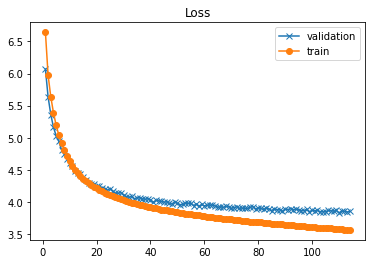

smallest val loss: (110, 3.829255)
Current Lr:  0.00032208467

Time taken for this epoch: 24.33 secs

Epoch 115 Batch 0 Loss 3.3876
Epoch 115 Batch 150 Loss 3.5049
Epoch 115 Batch 300 Loss 3.5259
Epoch 115 Batch 450 Loss 3.5335
Epoch 115 Batch 600 Loss 3.5413
Epoch 115 Batch 750 Loss 3.5565

<UNK> st bowler to score a <UNK> <UNK>
ms dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.843864679336548 

* Train Loss 3.5593


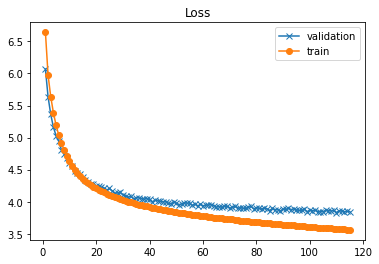

smallest val loss: (110, 3.829255)
Current Lr:  0.0003188996

Time taken for this epoch: 24.77 secs

Epoch 116 Batch 0 Loss 3.2919
Epoch 116 Batch 150 Loss 3.4945
Epoch 116 Batch 300 Loss 3.5176
Epoch 116 Batch 450 Loss 3.5329
Epoch 116 Batch 600 Loss 3.5412
Epoch 116 Batch 750 Loss 3.5560

<UNK> first bowler to score <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi asks people to make toilet for <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.8354642391204834 

* Train Loss 3.5583


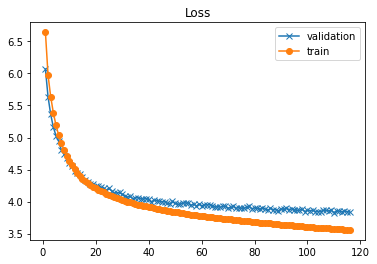

smallest val loss: (110, 3.829255)
Current Lr:  0.0003157461

Time taken for this epoch: 24.72 secs

Epoch 117 Batch 0 Loss 3.4541
Epoch 117 Batch 150 Loss 3.4821
Epoch 117 Batch 300 Loss 3.5114
Epoch 117 Batch 450 Loss 3.5228
Epoch 117 Batch 600 Loss 3.5377
Epoch 117 Batch 750 Loss 3.5544

warne st to score a wicket on this day
dhoni trending on twitter today
pm modi asks people to make <UNK> for <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> on his birth anniversary

validation started ...

* Validation loss: 3.840594530105591 

* Train Loss 3.5559


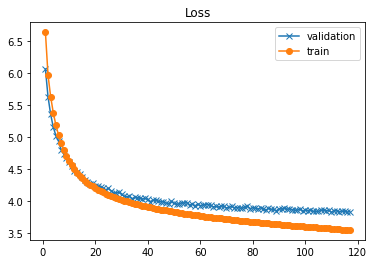

smallest val loss: (110, 3.829255)
Current Lr:  0.00031262363

Time taken for this epoch: 25.00 secs

Epoch 118 Batch 0 Loss 3.2696
Epoch 118 Batch 150 Loss 3.4930
Epoch 118 Batch 300 Loss 3.5075
Epoch 118 Batch 450 Loss 3.5272
Epoch 118 Batch 600 Loss 3.5370
Epoch 118 Batch 750 Loss 3.5510

<UNK> st bowler to take wickets on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8634278774261475 

* Train Loss 3.5524


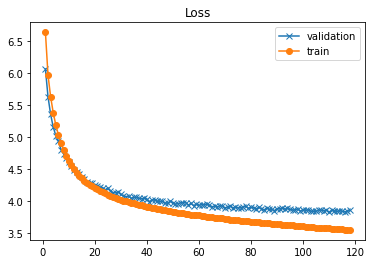

smallest val loss: (110, 3.829255)
Current Lr:  0.0003095322

Time taken for this epoch: 24.38 secs

Epoch 119 Batch 0 Loss 3.2942
Epoch 119 Batch 150 Loss 3.4803
Epoch 119 Batch 300 Loss 3.5097
Epoch 119 Batch 450 Loss 3.5214
Epoch 119 Batch 600 Loss 3.5311
Epoch 119 Batch 750 Loss 3.5443

<UNK> first <UNK> hattrick on this day
dhoni trending on twitter today
pm modi asks people to make toilets on <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.837117910385132 

* Train Loss 3.5465


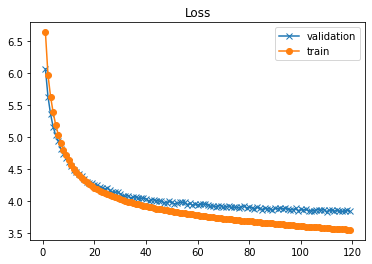

smallest val loss: (110, 3.829255)
Current Lr:  0.0003064713

Time taken for this epoch: 24.41 secs

Epoch 120 Batch 0 Loss 3.5481
Epoch 120 Batch 150 Loss 3.4957
Epoch 120 Batch 300 Loss 3.5183
Epoch 120 Batch 450 Loss 3.5286
Epoch 120 Batch 600 Loss 3.5407
Epoch 120 Batch 750 Loss 3.5459

warne was st to score a hattrick on this day
ms dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8335797786712646 

* Train Loss 3.5470


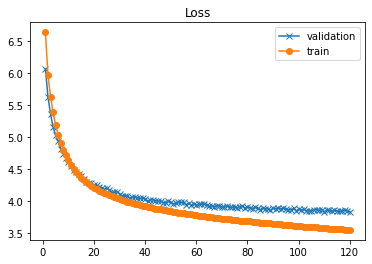

smallest val loss: (110, 3.829255)
Current Lr:  0.0003034406

Time taken for this epoch: 24.85 secs

Epoch 121 Batch 0 Loss 3.2729
Epoch 121 Batch 150 Loss 3.4735
Epoch 121 Batch 300 Loss 3.4927
Epoch 121 Batch 450 Loss 3.5124
Epoch 121 Batch 600 Loss 3.5289
Epoch 121 Batch 750 Loss 3.5412

<UNK> st bowler to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8496031761169434 

* Train Loss 3.5417


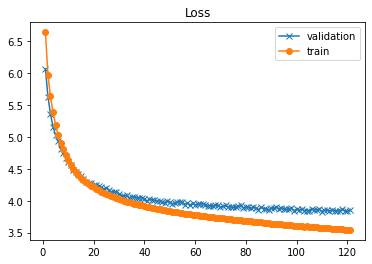

smallest val loss: (110, 3.829255)
Current Lr:  0.00030043992

Time taken for this epoch: 25.28 secs

Epoch 122 Batch 0 Loss 3.1800
Epoch 122 Batch 150 Loss 3.4708
Epoch 122 Batch 300 Loss 3.4941
Epoch 122 Batch 450 Loss 3.5169
Epoch 122 Batch 600 Loss 3.5285
Epoch 122 Batch 750 Loss 3.5402

<UNK> <UNK> st bowler to score a wicket on this day
dhoni trending on twitter today
pm modi asks pm to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8413429260253906 

* Train Loss 3.5398


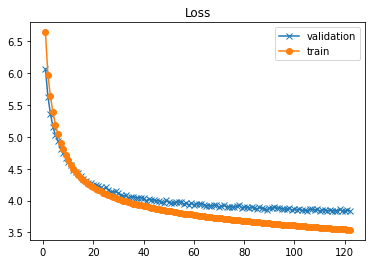

smallest val loss: (110, 3.829255)
Current Lr:  0.00029746894

Time taken for this epoch: 24.54 secs

Epoch 123 Batch 0 Loss 3.6212
Epoch 123 Batch 150 Loss 3.4705
Epoch 123 Batch 300 Loss 3.4954
Epoch 123 Batch 450 Loss 3.5106
Epoch 123 Batch 600 Loss 3.5209
Epoch 123 Batch 750 Loss 3.5340

<UNK> st <UNK> bowling on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
kim jongun <UNK> <UNK> born on <UNK> <UNK>

validation started ...

* Validation loss: 3.8171491622924805 

* Train Loss 3.5356


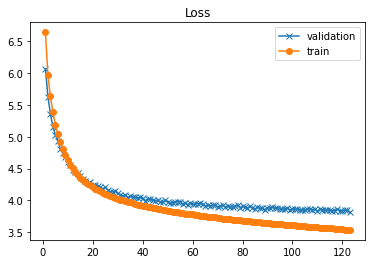

smallest val loss: (123, 3.8171492)
Current Lr:  0.00029452733

Time taken for this epoch: 24.80 secs

Epoch 124 Batch 0 Loss 3.6081
Epoch 124 Batch 150 Loss 3.4726
Epoch 124 Batch 300 Loss 3.5038
Epoch 124 Batch 450 Loss 3.5139
Epoch 124 Batch 600 Loss 3.5226
Epoch 124 Batch 750 Loss 3.5307

warne was st to score a hattrick on this day
ms dhoni trending on twitter today
pm modi asks people to make toilets on <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8174688816070557 

* Train Loss 3.5333


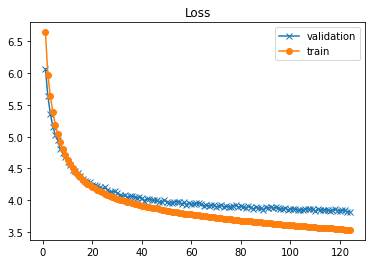

smallest val loss: (123, 3.8171492)
Current Lr:  0.00029161474

Time taken for this epoch: 24.72 secs

Epoch 125 Batch 0 Loss 3.6142
Epoch 125 Batch 150 Loss 3.4766
Epoch 125 Batch 300 Loss 3.4935
Epoch 125 Batch 450 Loss 3.5111
Epoch 125 Batch 600 Loss 3.5189
Epoch 125 Batch 750 Loss 3.5284

mcgrath scored a hattrick on this day
dhoni trending on twitter today
pm asks pm to make toilets for <UNK> toilets
kim jongun <UNK> <UNK> was <UNK> on christmas

validation started ...

* Validation loss: 3.8341715335845947 

* Train Loss 3.5295


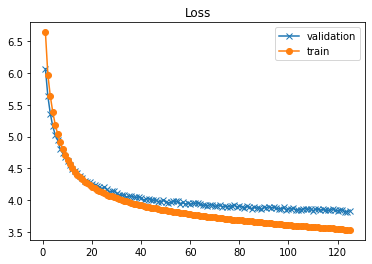

smallest val loss: (123, 3.8171492)
Current Lr:  0.00028873104

Time taken for this epoch: 24.71 secs

Epoch 126 Batch 0 Loss 3.4983
Epoch 126 Batch 150 Loss 3.4764
Epoch 126 Batch 300 Loss 3.4928
Epoch 126 Batch 450 Loss 3.5043
Epoch 126 Batch 600 Loss 3.5166
Epoch 126 Batch 750 Loss 3.5284

warne was st to score a <UNK> on this day
ms dhoni <UNK> trending on twitter today
pm modi asks pm to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8389220237731934 

* Train Loss 3.5294


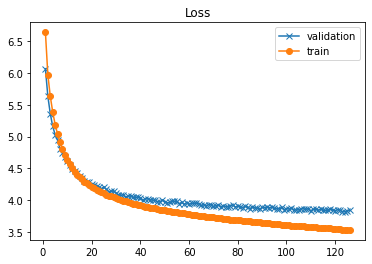

smallest val loss: (123, 3.8171492)
Current Lr:  0.00028587578

Time taken for this epoch: 24.64 secs

Epoch 127 Batch 0 Loss 3.4497
Epoch 127 Batch 150 Loss 3.4756
Epoch 127 Batch 300 Loss 3.4956
Epoch 127 Batch 450 Loss 3.5081
Epoch 127 Batch 600 Loss 3.5165
Epoch 127 Batch 750 Loss 3.5245

<UNK> st <UNK> <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
kim kim <UNK> born on christmas <UNK>

validation started ...

* Validation loss: 3.8523430824279785 

* Train Loss 3.5264


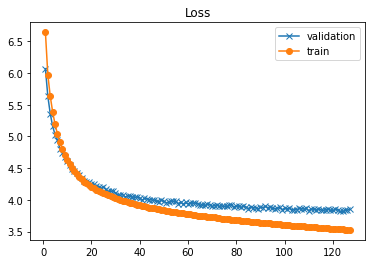

smallest val loss: (123, 3.8171492)
Current Lr:  0.00028304878

Time taken for this epoch: 24.28 secs

Epoch 128 Batch 0 Loss 3.5462
Epoch 128 Batch 150 Loss 3.4646
Epoch 128 Batch 300 Loss 3.4850
Epoch 128 Batch 450 Loss 3.4988
Epoch 128 Batch 600 Loss 3.5136
Epoch 128 Batch 750 Loss 3.5232

warne was st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.830556631088257 

* Train Loss 3.5235


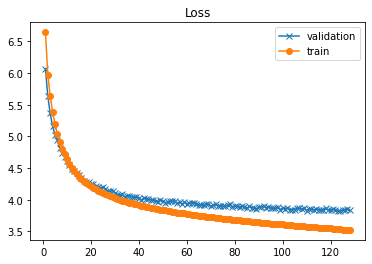

smallest val loss: (123, 3.8171492)
Current Lr:  0.0002802498

Time taken for this epoch: 24.81 secs

Epoch 129 Batch 0 Loss 3.6018
Epoch 129 Batch 150 Loss 3.4783
Epoch 129 Batch 300 Loss 3.4848
Epoch 129 Batch 450 Loss 3.5000
Epoch 129 Batch 600 Loss 3.5119
Epoch 129 Batch 750 Loss 3.5234

<UNK> st bowler to score a wicket on this day
dhoni <UNK> trending on twitter today
pm modi asks people to make toilets for <UNK>
kim jongun <UNK> <UNK> born on christmas

validation started ...

* Validation loss: 3.8209121227264404 

* Train Loss 3.5249


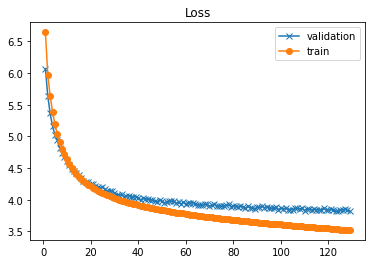

smallest val loss: (123, 3.8171492)
Current Lr:  0.00027747848

Time taken for this epoch: 25.19 secs

Epoch 130 Batch 0 Loss 3.4717
Epoch 130 Batch 150 Loss 3.4530
Epoch 130 Batch 300 Loss 3.4747
Epoch 130 Batch 450 Loss 3.4907
Epoch 130 Batch 600 Loss 3.5022
Epoch 130 Batch 750 Loss 3.5155

warne st ever ball on this day
ms dhoni trending on twitter today
pm modi asks for <UNK> <UNK> for <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.8193399906158447 

* Train Loss 3.5178


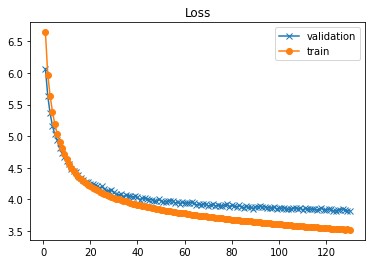

smallest val loss: (123, 3.8171492)
Current Lr:  0.00027473446

Time taken for this epoch: 24.19 secs

Epoch 131 Batch 0 Loss 3.3024
Epoch 131 Batch 150 Loss 3.4658
Epoch 131 Batch 300 Loss 3.4706
Epoch 131 Batch 450 Loss 3.4932
Epoch 131 Batch 600 Loss 3.5058
Epoch 131 Batch 750 Loss 3.5138

first ever <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
kim kim <UNK> born on christmas <UNK>

validation started ...

* Validation loss: 3.815276861190796 

* Train Loss 3.5152


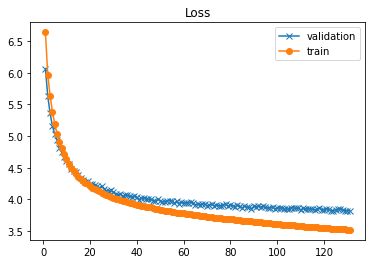

smallest val loss: (131, 3.8152769)
Current Lr:  0.00027201767

Time taken for this epoch: 24.67 secs

Epoch 132 Batch 0 Loss 3.4368
Epoch 132 Batch 150 Loss 3.4445
Epoch 132 Batch 300 Loss 3.4710
Epoch 132 Batch 450 Loss 3.4891
Epoch 132 Batch 600 Loss 3.5000
Epoch 132 Batch 750 Loss 3.5129

<UNK> st ever <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks people to make toilets for <UNK>
<UNK> korean leader <UNK> born on <UNK>

validation started ...

* Validation loss: 3.8328607082366943 

* Train Loss 3.5139


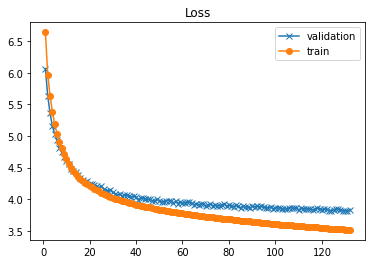

smallest val loss: (131, 3.8152769)
Current Lr:  0.00026932772

Time taken for this epoch: 24.52 secs

Epoch 133 Batch 0 Loss 3.3139
Epoch 133 Batch 150 Loss 3.4439
Epoch 133 Batch 300 Loss 3.4692
Epoch 133 Batch 450 Loss 3.4847
Epoch 133 Batch 600 Loss 3.4916
Epoch 133 Batch 750 Loss 3.5068

<UNK> st bowler to take wickets on this day
dhoni <UNK> trending on twitter today
pm modi asks people to make <UNK> for <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.816324472427368 

* Train Loss 3.5096


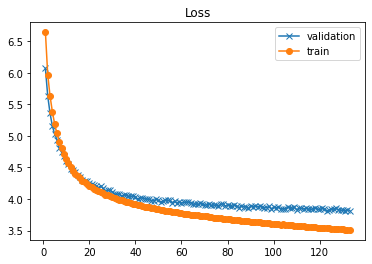

smallest val loss: (131, 3.8152769)
Current Lr:  0.00026666443

Time taken for this epoch: 25.10 secs

Epoch 134 Batch 0 Loss 3.3166
Epoch 134 Batch 150 Loss 3.4632
Epoch 134 Batch 300 Loss 3.4793
Epoch 134 Batch 450 Loss 3.4894
Epoch 134 Batch 600 Loss 3.4947
Epoch 134 Batch 750 Loss 3.5073

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for poor
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8159682750701904 

* Train Loss 3.5096


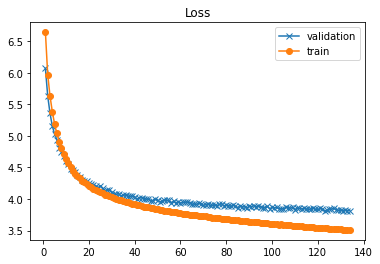

smallest val loss: (131, 3.8152769)
Current Lr:  0.0002640274

Time taken for this epoch: 24.36 secs

Epoch 135 Batch 0 Loss 3.5020
Epoch 135 Batch 150 Loss 3.4541
Epoch 135 Batch 300 Loss 3.4736
Epoch 135 Batch 450 Loss 3.4817
Epoch 135 Batch 600 Loss 3.4936
Epoch 135 Batch 750 Loss 3.5061

warne was st to score a ball on this day
dhoni <UNK> trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7938787937164307 

* Train Loss 3.5082


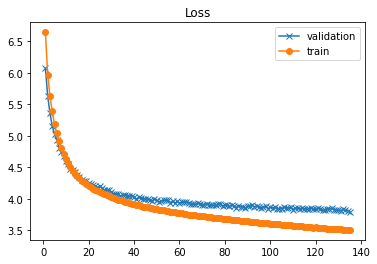

smallest val loss: (135, 3.7938788)
Current Lr:  0.00026141648

Time taken for this epoch: 25.16 secs

Epoch 136 Batch 0 Loss 3.5624
Epoch 136 Batch 150 Loss 3.4438
Epoch 136 Batch 300 Loss 3.4639
Epoch 136 Batch 450 Loss 3.4766
Epoch 136 Batch 600 Loss 3.4910
Epoch 136 Batch 750 Loss 3.5013

warne st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks people to make toilets on <UNK>
kim jongun <UNK> <UNK> born on christmas

validation started ...

* Validation loss: 3.8277273178100586 

* Train Loss 3.5030


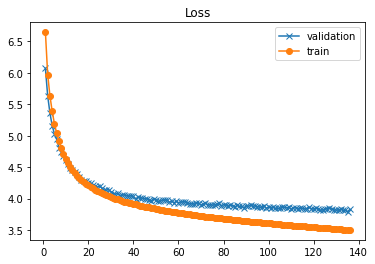

smallest val loss: (135, 3.7938788)
Current Lr:  0.0002588313

Time taken for this epoch: 24.49 secs

Epoch 137 Batch 0 Loss 3.3738
Epoch 137 Batch 150 Loss 3.4228
Epoch 137 Batch 300 Loss 3.4448
Epoch 137 Batch 450 Loss 3.4659
Epoch 137 Batch 600 Loss 3.4900
Epoch 137 Batch 750 Loss 3.4988

<UNK> st <UNK> hattrick on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.798665761947632 

* Train Loss 3.5007


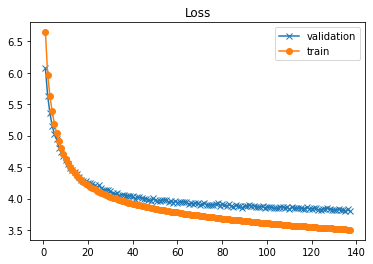

smallest val loss: (135, 3.7938788)
Current Lr:  0.00025627177

Time taken for this epoch: 24.53 secs

Epoch 138 Batch 0 Loss 3.2368
Epoch 138 Batch 150 Loss 3.4350
Epoch 138 Batch 300 Loss 3.4544
Epoch 138 Batch 450 Loss 3.4698
Epoch 138 Batch 600 Loss 3.4812
Epoch 138 Batch 750 Loss 3.4983

mcgrath was the first to score wickets on this day
dhoni trending on twitter today
pm modi asks people to make <UNK> for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.8091375827789307 

* Train Loss 3.4998


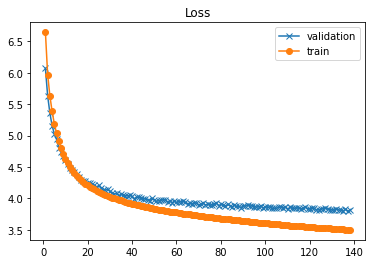

smallest val loss: (135, 3.7938788)
Current Lr:  0.00025373758

Time taken for this epoch: 24.35 secs

Epoch 139 Batch 0 Loss 3.3622
Epoch 139 Batch 150 Loss 3.4454
Epoch 139 Batch 300 Loss 3.4606
Epoch 139 Batch 450 Loss 3.4776
Epoch 139 Batch 600 Loss 3.4832
Epoch 139 Batch 750 Loss 3.4947

warne was the first to win a ball on this day
dhoni trending on twitter today
pm modi asks people to make <UNK> for <UNK>
<UNK> korean leader <UNK> born on christmas

validation started ...

* Validation loss: 3.8300094604492188 

* Train Loss 3.4964


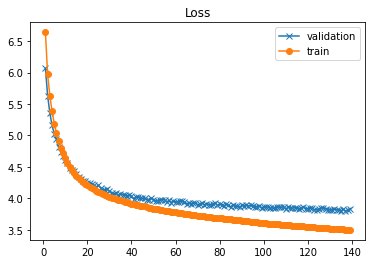

smallest val loss: (135, 3.7938788)
Current Lr:  0.0002512284

Time taken for this epoch: 24.81 secs

Epoch 140 Batch 0 Loss 3.1473
Epoch 140 Batch 150 Loss 3.4217
Epoch 140 Batch 300 Loss 3.4523
Epoch 140 Batch 450 Loss 3.4682
Epoch 140 Batch 600 Loss 3.4814
Epoch 140 Batch 750 Loss 3.4929

warne st bowler to take wickets on this day
dhoni <UNK> trending on twitter today
pm modi congratulates modi for <UNK> toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.819439649581909 

* Train Loss 3.4962


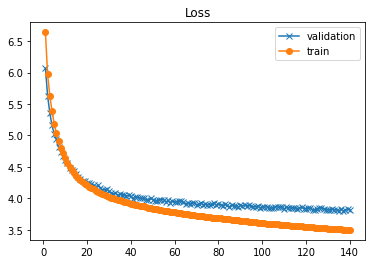

smallest val loss: (135, 3.7938788)
Current Lr:  0.00024874407

Time taken for this epoch: 24.65 secs

Epoch 141 Batch 0 Loss 3.4095
Epoch 141 Batch 150 Loss 3.4473
Epoch 141 Batch 300 Loss 3.4583
Epoch 141 Batch 450 Loss 3.4742
Epoch 141 Batch 600 Loss 3.4803
Epoch 141 Batch 750 Loss 3.4888

warne st <UNK> <UNK> <UNK> on this day
ms dhoni trending on twitter today
pm modi asks pm for <UNK> <UNK> <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8032331466674805 

* Train Loss 3.4914


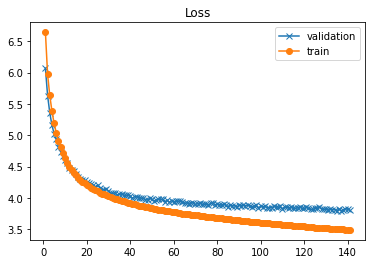

smallest val loss: (135, 3.7938788)
Current Lr:  0.00024628424

Time taken for this epoch: 24.76 secs

Epoch 142 Batch 0 Loss 3.6475
Epoch 142 Batch 150 Loss 3.4373
Epoch 142 Batch 300 Loss 3.4506
Epoch 142 Batch 450 Loss 3.4663
Epoch 142 Batch 600 Loss 3.4737
Epoch 142 Batch 750 Loss 3.4892

warne st <UNK> <UNK> ball on this day
ms dhoni trending on twitter today
pm modi asks pm to make <UNK> for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8183846473693848 

* Train Loss 3.4910


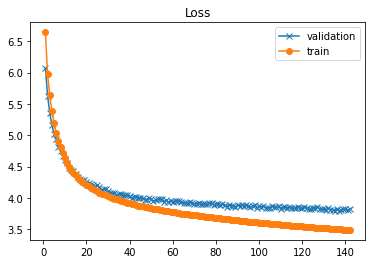

smallest val loss: (135, 3.7938788)
Current Lr:  0.00024384874

Time taken for this epoch: 24.51 secs

Epoch 143 Batch 0 Loss 3.6118
Epoch 143 Batch 150 Loss 3.4379
Epoch 143 Batch 300 Loss 3.4512
Epoch 143 Batch 450 Loss 3.4601
Epoch 143 Batch 600 Loss 3.4757
Epoch 143 Batch 750 Loss 3.4844

mcgrath was st to score a ball on this day
dhoni trending on twitter today
pm modi asks pm to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.822087287902832 

* Train Loss 3.4864


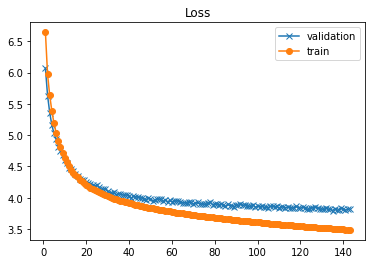

smallest val loss: (135, 3.7938788)
Current Lr:  0.00024143739

Time taken for this epoch: 25.31 secs

Epoch 144 Batch 0 Loss 3.3238
Epoch 144 Batch 150 Loss 3.4359
Epoch 144 Batch 300 Loss 3.4448
Epoch 144 Batch 450 Loss 3.4575
Epoch 144 Batch 600 Loss 3.4706
Epoch 144 Batch 750 Loss 3.4813

yrs since <UNK> <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
kim jongun <UNK> <UNK> born on christmas

validation started ...

* Validation loss: 3.8189353942871094 

* Train Loss 3.4838


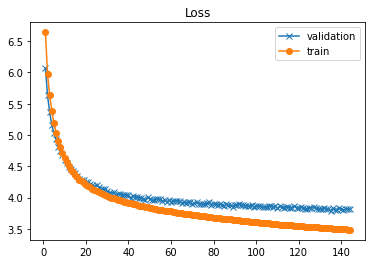

smallest val loss: (135, 3.7938788)
Current Lr:  0.00023904983

Time taken for this epoch: 24.19 secs

Epoch 145 Batch 0 Loss 3.4363
Epoch 145 Batch 150 Loss 3.4256
Epoch 145 Batch 300 Loss 3.4494
Epoch 145 Batch 450 Loss 3.4588
Epoch 145 Batch 600 Loss 3.4724
Epoch 145 Batch 750 Loss 3.4810

warne scored his first ball on this day
ms dhoni trending on twitter today
pm modi congratulates modi for <UNK> toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8223154544830322 

* Train Loss 3.4841


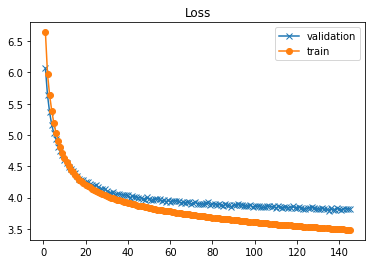

smallest val loss: (135, 3.7938788)
Current Lr:  0.00023668591

Time taken for this epoch: 25.22 secs

Epoch 146 Batch 0 Loss 3.3258
Epoch 146 Batch 150 Loss 3.4278
Epoch 146 Batch 300 Loss 3.4517
Epoch 146 Batch 450 Loss 3.4614
Epoch 146 Batch 600 Loss 3.4724
Epoch 146 Batch 750 Loss 3.4804

warne was st <UNK> bowling on this day
ms dhoni trending on twitter today
pm modi asks people to make toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.782708168029785 

* Train Loss 3.4828

Saving checkpoint for epoch 146 at checkpoints4/ckpt-15


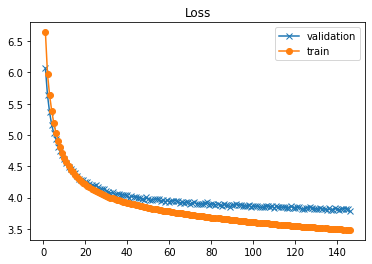

smallest val loss: (146, 3.7827082)
Current Lr:  0.00023434535

Time taken for this epoch: 25.12 secs

Epoch 147 Batch 0 Loss 3.3056
Epoch 147 Batch 150 Loss 3.4128
Epoch 147 Batch 300 Loss 3.4357
Epoch 147 Batch 450 Loss 3.4499
Epoch 147 Batch 600 Loss 3.4694
Epoch 147 Batch 750 Loss 3.4786

st ever test bowler was <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi thanks people for <UNK> <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.817457437515259 

* Train Loss 3.4798


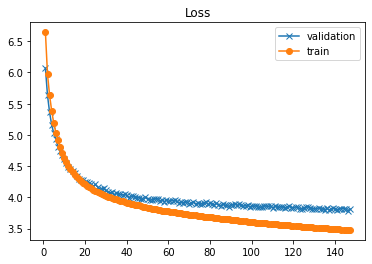

smallest val loss: (146, 3.7827082)
Current Lr:  0.00023202795

Time taken for this epoch: 24.31 secs

Epoch 148 Batch 0 Loss 3.4792
Epoch 148 Batch 150 Loss 3.4249
Epoch 148 Batch 300 Loss 3.4457
Epoch 148 Batch 450 Loss 3.4574
Epoch 148 Batch 600 Loss 3.4615
Epoch 148 Batch 750 Loss 3.4720

warne was st to score a ball on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.8373818397521973 

* Train Loss 3.4745


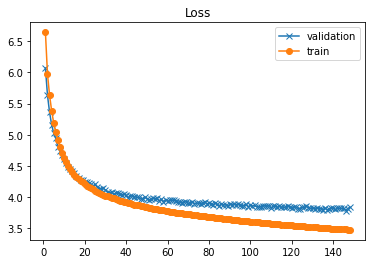

smallest val loss: (146, 3.7827082)
Current Lr:  0.00022973346

Time taken for this epoch: 24.81 secs

Epoch 149 Batch 0 Loss 3.3158
Epoch 149 Batch 150 Loss 3.4224
Epoch 149 Batch 300 Loss 3.4383
Epoch 149 Batch 450 Loss 3.4496
Epoch 149 Batch 600 Loss 3.4593
Epoch 149 Batch 750 Loss 3.4727

warne was st to score a hattrick on this day
dhoni trending on twitter today
pm modi asks people to make <UNK> for <UNK>
kim kim <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7994141578674316 

* Train Loss 3.4742


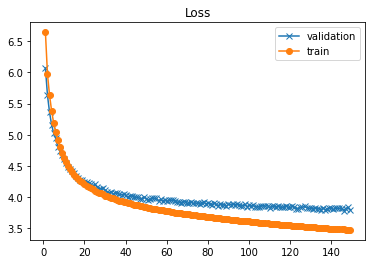

smallest val loss: (146, 3.7827082)
Current Lr:  0.00022746163

Time taken for this epoch: 24.79 secs

Epoch 150 Batch 0 Loss 3.5677
Epoch 150 Batch 150 Loss 3.4168
Epoch 150 Batch 300 Loss 3.4358
Epoch 150 Batch 450 Loss 3.4505
Epoch 150 Batch 600 Loss 3.4575
Epoch 150 Batch 750 Loss 3.4697

warne st ever <UNK> bowling on this day
dhoni <UNK> trending on twitter today
pm modi thanks pm for <UNK> <UNK> <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.816310167312622 

* Train Loss 3.4707


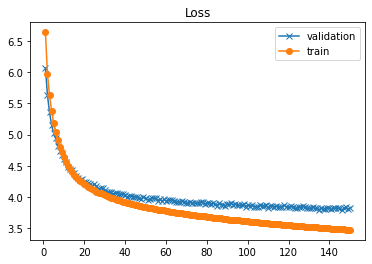

smallest val loss: (146, 3.7827082)
Current Lr:  0.00022521231

Time taken for this epoch: 24.62 secs

Epoch 151 Batch 0 Loss 3.3602
Epoch 151 Batch 150 Loss 3.4147
Epoch 151 Batch 300 Loss 3.4336
Epoch 151 Batch 450 Loss 3.4473
Epoch 151 Batch 600 Loss 3.4580
Epoch 151 Batch 750 Loss 3.4654

warne was st to score a ball on this day
dhoni trending on twitter today
pm modi asks people to make <UNK> for <UNK>
kim jongun <UNK> <UNK> born on christmas

validation started ...

* Validation loss: 3.77884578704834 

* Train Loss 3.4675


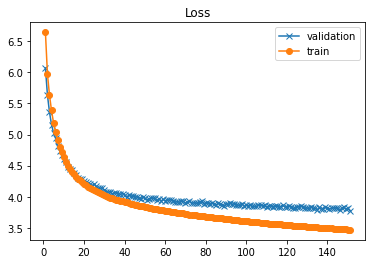

smallest val loss: (151, 3.7788458)
Current Lr:  0.00022298524

Time taken for this epoch: 24.85 secs

Epoch 152 Batch 0 Loss 3.0692
Epoch 152 Batch 150 Loss 3.4065
Epoch 152 Batch 300 Loss 3.4355
Epoch 152 Batch 450 Loss 3.4386
Epoch 152 Batch 600 Loss 3.4503
Epoch 152 Batch 750 Loss 3.4646

<UNK> st <UNK> ball on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7948076725006104 

* Train Loss 3.4668


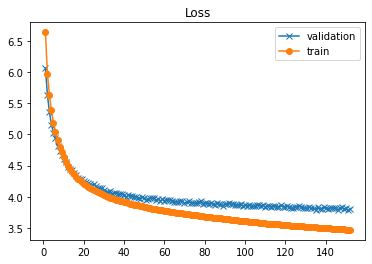

smallest val loss: (151, 3.7788458)
Current Lr:  0.00022078013

Time taken for this epoch: 24.52 secs

Epoch 153 Batch 0 Loss 3.2969
Epoch 153 Batch 150 Loss 3.4074
Epoch 153 Batch 300 Loss 3.4287
Epoch 153 Batch 450 Loss 3.4406
Epoch 153 Batch 600 Loss 3.4537
Epoch 153 Batch 750 Loss 3.4646

warne was st to score runs on this day
dhoni <UNK> trending on twitter today
pm modi thanks pm for <UNK> <UNK>
kim jongun <UNK> <UNK> born on christmas

validation started ...

* Validation loss: 3.7874083518981934 

* Train Loss 3.4666


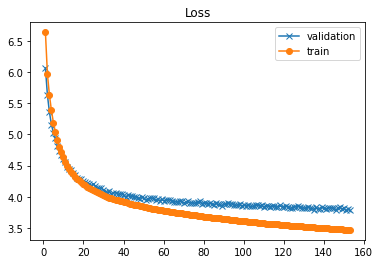

smallest val loss: (151, 3.7788458)
Current Lr:  0.00021859692

Time taken for this epoch: 24.51 secs

Epoch 154 Batch 0 Loss 3.5257
Epoch 154 Batch 150 Loss 3.4197
Epoch 154 Batch 300 Loss 3.4313
Epoch 154 Batch 450 Loss 3.4417
Epoch 154 Batch 600 Loss 3.4481
Epoch 154 Batch 750 Loss 3.4596

warne was st to win a wicket on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7978615760803223 

* Train Loss 3.4609


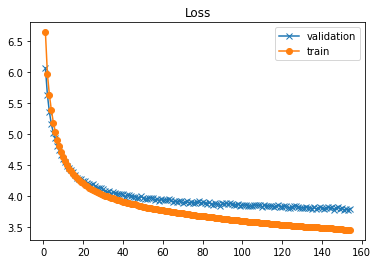

smallest val loss: (151, 3.7788458)
Current Lr:  0.00021643523

Time taken for this epoch: 24.81 secs

Epoch 155 Batch 0 Loss 3.4729
Epoch 155 Batch 150 Loss 3.4131
Epoch 155 Batch 300 Loss 3.4212
Epoch 155 Batch 450 Loss 3.4353
Epoch 155 Batch 600 Loss 3.4501
Epoch 155 Batch 750 Loss 3.4604

<UNK> st <UNK> <UNK> on this day
dhoni trending on twitter today
pm thanks pm for <UNK> <UNK> <UNK> on toilet
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7844254970550537 

* Train Loss 3.4618


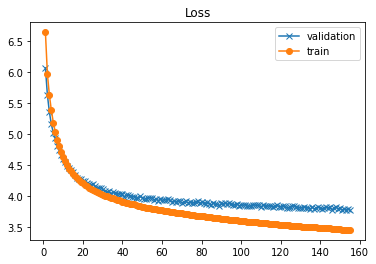

smallest val loss: (151, 3.7788458)
Current Lr:  0.00021429491

Time taken for this epoch: 24.20 secs

Epoch 156 Batch 0 Loss 3.3969
Epoch 156 Batch 150 Loss 3.4107
Epoch 156 Batch 300 Loss 3.4239
Epoch 156 Batch 450 Loss 3.4377
Epoch 156 Batch 600 Loss 3.4451
Epoch 156 Batch 750 Loss 3.4561

warne was st to score a <UNK> on this day
dhoni trending on twitter today
pm modi asks people to make <UNK> for <UNK>
kim kim <UNK> born on christmas <UNK>

validation started ...

* Validation loss: 3.8103630542755127 

* Train Loss 3.4586


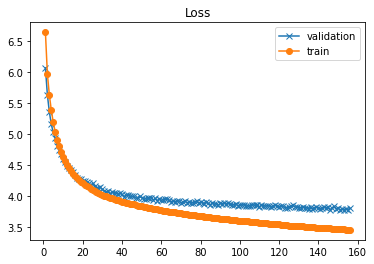

smallest val loss: (151, 3.7788458)
Current Lr:  0.00021217579

Time taken for this epoch: 24.79 secs

Epoch 157 Batch 0 Loss 3.2290
Epoch 157 Batch 150 Loss 3.4146
Epoch 157 Batch 300 Loss 3.4157
Epoch 157 Batch 450 Loss 3.4347
Epoch 157 Batch 600 Loss 3.4450
Epoch 157 Batch 750 Loss 3.4573

warne was st ever <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK>
kim kim <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.796720266342163 

* Train Loss 3.4576


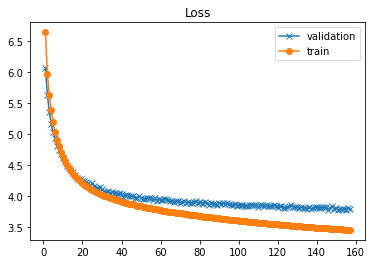

smallest val loss: (151, 3.7788458)
Current Lr:  0.0002100776

Time taken for this epoch: 24.78 secs

Epoch 158 Batch 0 Loss 3.4752
Epoch 158 Batch 150 Loss 3.3933
Epoch 158 Batch 300 Loss 3.4170
Epoch 158 Batch 450 Loss 3.4323
Epoch 158 Batch 600 Loss 3.4425
Epoch 158 Batch 750 Loss 3.4522

warne was st to <UNK> <UNK> on this day
ms dhoni trending on twitter today
pm modi asks people to make <UNK> for <UNK>
kim jongun <UNK> born on christmas

validation started ...

* Validation loss: 3.8021652698516846 

* Train Loss 3.4541


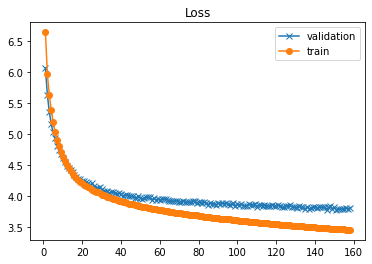

smallest val loss: (151, 3.7788458)
Current Lr:  0.00020800019

Time taken for this epoch: 24.74 secs

Epoch 159 Batch 0 Loss 3.3280
Epoch 159 Batch 150 Loss 3.4102
Epoch 159 Batch 300 Loss 3.4339
Epoch 159 Batch 450 Loss 3.4369
Epoch 159 Batch 600 Loss 3.4467
Epoch 159 Batch 750 Loss 3.4533

warne was st <UNK> on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.827662467956543 

* Train Loss 3.4534


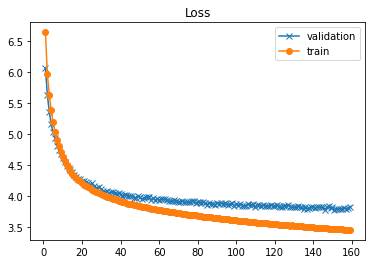

smallest val loss: (151, 3.7788458)
Current Lr:  0.00020594332

Time taken for this epoch: 24.20 secs

Epoch 160 Batch 0 Loss 3.1677
Epoch 160 Batch 150 Loss 3.3953
Epoch 160 Batch 300 Loss 3.4128
Epoch 160 Batch 450 Loss 3.4204
Epoch 160 Batch 600 Loss 3.4357
Epoch 160 Batch 750 Loss 3.4485

st ever ball ball on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.8112008571624756 

* Train Loss 3.4503


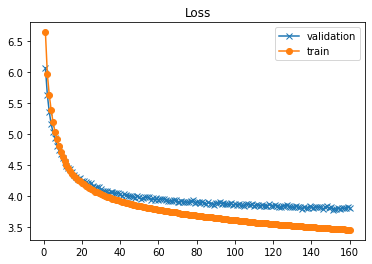

smallest val loss: (151, 3.7788458)
Current Lr:  0.00020390675

Time taken for this epoch: 24.50 secs

Epoch 161 Batch 0 Loss 3.0945
Epoch 161 Batch 150 Loss 3.3925
Epoch 161 Batch 300 Loss 3.4118
Epoch 161 Batch 450 Loss 3.4226
Epoch 161 Batch 600 Loss 3.4322
Epoch 161 Batch 750 Loss 3.4445

warne was st to score runs on this day
dhoni trending on twitter today
pm modi asks pm for <UNK> <UNK> <UNK>
kim kardashian was born on christmas <UNK>

validation started ...

* Validation loss: 3.8095510005950928 

* Train Loss 3.4468


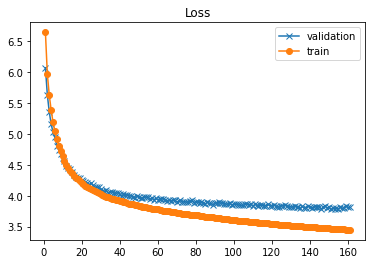

smallest val loss: (151, 3.7788458)
Current Lr:  0.00020189033

Time taken for this epoch: 24.79 secs

Epoch 162 Batch 0 Loss 3.2038
Epoch 162 Batch 150 Loss 3.3810
Epoch 162 Batch 300 Loss 3.4131
Epoch 162 Batch 450 Loss 3.4216
Epoch 162 Batch 600 Loss 3.4338
Epoch 162 Batch 750 Loss 3.4459

warne was st to score runs on this day
dhoni trending on twitter today
pm modi asks pm for <UNK> <UNK> <UNK>
kim kim <UNK> <UNK> born on christmas

validation started ...

* Validation loss: 3.799281358718872 

* Train Loss 3.4479


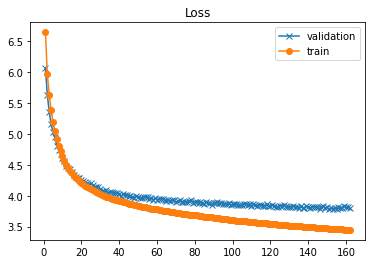

smallest val loss: (151, 3.7788458)
Current Lr:  0.00019989387

Time taken for this epoch: 25.05 secs

Epoch 163 Batch 0 Loss 3.4452
Epoch 163 Batch 150 Loss 3.3937
Epoch 163 Batch 300 Loss 3.4092
Epoch 163 Batch 450 Loss 3.4189
Epoch 163 Batch 600 Loss 3.4294
Epoch 163 Batch 750 Loss 3.4420

warne was st to <UNK> <UNK> <UNK>
ms dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.8024377822875977 

* Train Loss 3.4448


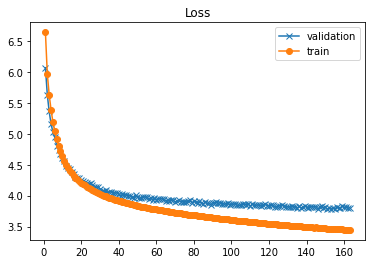

smallest val loss: (151, 3.7788458)
Current Lr:  0.00019791716

Time taken for this epoch: 24.08 secs

Epoch 164 Batch 0 Loss 3.2692
Epoch 164 Batch 150 Loss 3.3977
Epoch 164 Batch 300 Loss 3.4085
Epoch 164 Batch 450 Loss 3.4200
Epoch 164 Batch 600 Loss 3.4336
Epoch 164 Batch 750 Loss 3.4402

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.795266628265381 

* Train Loss 3.4419


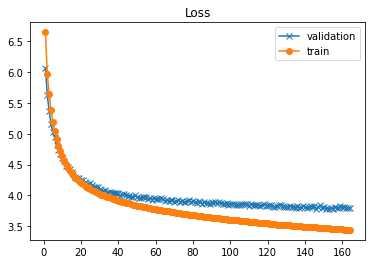

smallest val loss: (151, 3.7788458)
Current Lr:  0.00019595999

Time taken for this epoch: 24.76 secs

Epoch 165 Batch 0 Loss 3.3592
Epoch 165 Batch 150 Loss 3.3971
Epoch 165 Batch 300 Loss 3.4159
Epoch 165 Batch 450 Loss 3.4205
Epoch 165 Batch 600 Loss 3.4292
Epoch 165 Batch 750 Loss 3.4401

warne st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks pm for <UNK> <UNK> for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.792724370956421 

* Train Loss 3.4410


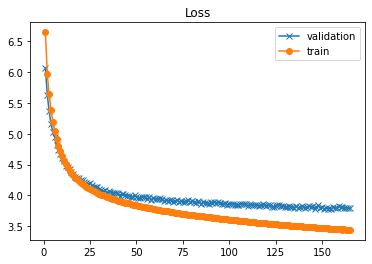

smallest val loss: (151, 3.7788458)
Current Lr:  0.00019402217

Time taken for this epoch: 24.65 secs

Epoch 166 Batch 0 Loss 3.2922
Epoch 166 Batch 150 Loss 3.3829
Epoch 166 Batch 300 Loss 3.4083
Epoch 166 Batch 450 Loss 3.4228
Epoch 166 Batch 600 Loss 3.4347
Epoch 166 Batch 750 Loss 3.4374

<UNK> st <UNK> hattrick on this day
dhoni trending on twitter today
pm modi asks people to make <UNK> for <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.784219980239868 

* Train Loss 3.4387


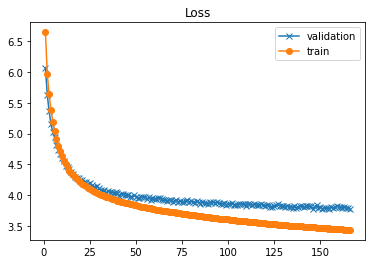

smallest val loss: (151, 3.7788458)
Current Lr:  0.00019210353

Time taken for this epoch: 25.48 secs

Epoch 167 Batch 0 Loss 3.6546
Epoch 167 Batch 150 Loss 3.3757
Epoch 167 Batch 300 Loss 3.4040
Epoch 167 Batch 450 Loss 3.4217
Epoch 167 Batch 600 Loss 3.4259
Epoch 167 Batch 750 Loss 3.4369

warne was st to win a ball on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7819769382476807 

* Train Loss 3.4380


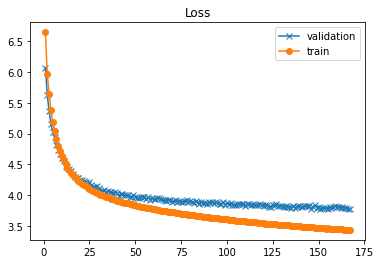

smallest val loss: (151, 3.7788458)
Current Lr:  0.0001902038

Time taken for this epoch: 24.88 secs

Epoch 168 Batch 0 Loss 3.2365
Epoch 168 Batch 150 Loss 3.3796
Epoch 168 Batch 300 Loss 3.3996
Epoch 168 Batch 450 Loss 3.4095
Epoch 168 Batch 600 Loss 3.4190
Epoch 168 Batch 750 Loss 3.4319

st ever test bowler was <UNK> on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7963645458221436 

* Train Loss 3.4342


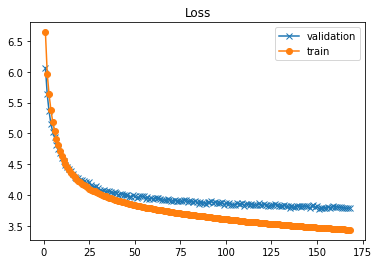

smallest val loss: (151, 3.7788458)
Current Lr:  0.00018832293

Time taken for this epoch: 24.76 secs

Epoch 169 Batch 0 Loss 3.3529
Epoch 169 Batch 150 Loss 3.3806
Epoch 169 Batch 300 Loss 3.4052
Epoch 169 Batch 450 Loss 3.4120
Epoch 169 Batch 600 Loss 3.4240
Epoch 169 Batch 750 Loss 3.4362

<UNK> st ever ball on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.818341016769409 

* Train Loss 3.4367


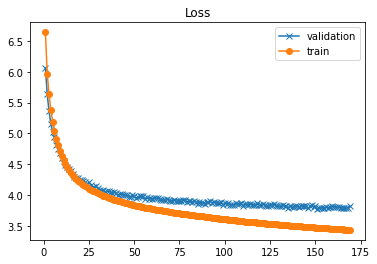

smallest val loss: (151, 3.7788458)
Current Lr:  0.0001864606

Time taken for this epoch: 24.85 secs

Epoch 170 Batch 0 Loss 3.3114
Epoch 170 Batch 150 Loss 3.3836
Epoch 170 Batch 300 Loss 3.3987
Epoch 170 Batch 450 Loss 3.4110
Epoch 170 Batch 600 Loss 3.4185
Epoch 170 Batch 750 Loss 3.4293

warne was st ever <UNK> ball on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.8017594814300537 

* Train Loss 3.4308


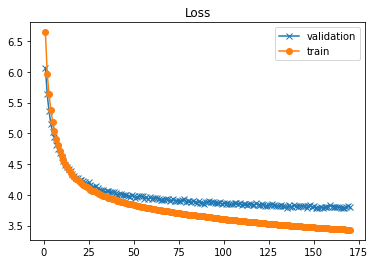

smallest val loss: (151, 3.7788458)
Current Lr:  0.00018461676

Time taken for this epoch: 24.96 secs

Epoch 171 Batch 0 Loss 3.3941
Epoch 171 Batch 150 Loss 3.3896
Epoch 171 Batch 300 Loss 3.4051
Epoch 171 Batch 450 Loss 3.4170
Epoch 171 Batch 600 Loss 3.4219
Epoch 171 Batch 750 Loss 3.4308

warne was st to score a ball on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
<UNK> korea leader <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7932443618774414 

* Train Loss 3.4331


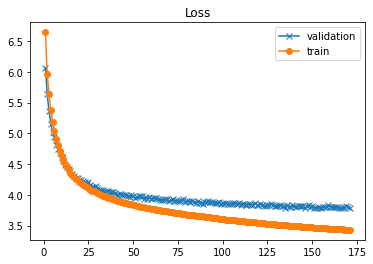

smallest val loss: (151, 3.7788458)
Current Lr:  0.0001827911

Time taken for this epoch: 25.00 secs

Epoch 172 Batch 0 Loss 3.4101
Epoch 172 Batch 150 Loss 3.3887
Epoch 172 Batch 300 Loss 3.3951
Epoch 172 Batch 450 Loss 3.4018
Epoch 172 Batch 600 Loss 3.4120
Epoch 172 Batch 750 Loss 3.4262

<UNK> first <UNK> wicket on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7836999893188477 

* Train Loss 3.4278


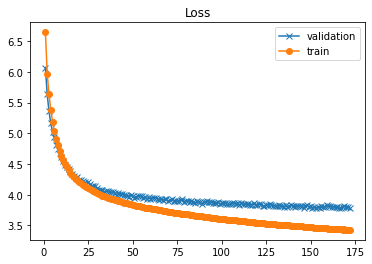

smallest val loss: (151, 3.7788458)
Current Lr:  0.0001809835

Time taken for this epoch: 24.47 secs

Epoch 173 Batch 0 Loss 3.2997
Epoch 173 Batch 150 Loss 3.3785
Epoch 173 Batch 300 Loss 3.3955
Epoch 173 Batch 450 Loss 3.3999
Epoch 173 Batch 600 Loss 3.4130
Epoch 173 Batch 750 Loss 3.4247

st ever ball <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi congratulates pm modi for <UNK> toilets on <UNK>
kim jongnams <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.8019659519195557 

* Train Loss 3.4269


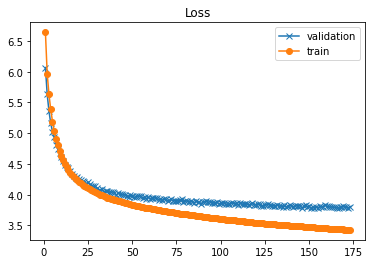

smallest val loss: (151, 3.7788458)
Current Lr:  0.00017919378

Time taken for this epoch: 24.89 secs

Epoch 174 Batch 0 Loss 3.4760
Epoch 174 Batch 150 Loss 3.3613
Epoch 174 Batch 300 Loss 3.3958
Epoch 174 Batch 450 Loss 3.4090
Epoch 174 Batch 600 Loss 3.4172
Epoch 174 Batch 750 Loss 3.4268

st ever ball of the ball of the ball on this day
dhoni <UNK> trending on twitter today
pm modi praises pm modi for <UNK> toilets
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.784592628479004 

* Train Loss 3.4275


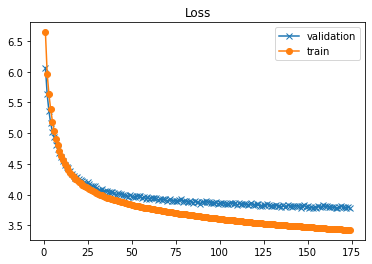

smallest val loss: (151, 3.7788458)
Current Lr:  0.00017742174

Time taken for this epoch: 25.00 secs

Epoch 175 Batch 0 Loss 3.5097
Epoch 175 Batch 150 Loss 3.3814
Epoch 175 Batch 300 Loss 3.3909
Epoch 175 Batch 450 Loss 3.4019
Epoch 175 Batch 600 Loss 3.4120
Epoch 175 Batch 750 Loss 3.4228

mcgrath st <UNK> bowler to score runs on this day
dhoni trending on twitter today
pm modi asks pm to make toilets for <UNK>
kim kim <UNK> <UNK> <UNK> <UNK> on his <UNK>

validation started ...

* Validation loss: 3.779531240463257 

* Train Loss 3.4241


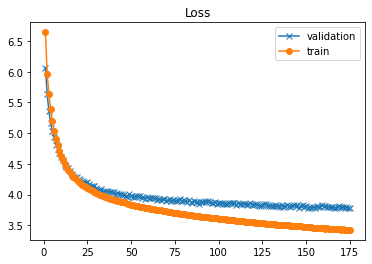

smallest val loss: (151, 3.7788458)
Current Lr:  0.00017566724

Time taken for this epoch: 25.22 secs

Epoch 176 Batch 0 Loss 3.4884
Epoch 176 Batch 150 Loss 3.3621
Epoch 176 Batch 300 Loss 3.3873
Epoch 176 Batch 450 Loss 3.3985
Epoch 176 Batch 600 Loss 3.4082
Epoch 176 Batch 750 Loss 3.4179

warne scored a <UNK> <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi thanks <UNK> for <UNK> <UNK>
kim kim <UNK> born on christmas <UNK>

validation started ...

* Validation loss: 3.7844085693359375 

* Train Loss 3.4202


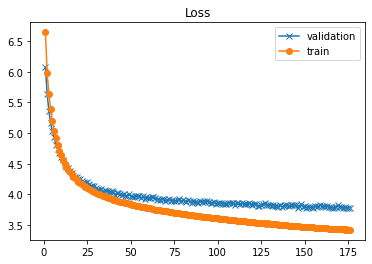

smallest val loss: (151, 3.7788458)
Current Lr:  0.00017393014

Time taken for this epoch: 24.23 secs

Epoch 177 Batch 0 Loss 3.3332
Epoch 177 Batch 150 Loss 3.3784
Epoch 177 Batch 300 Loss 3.3829
Epoch 177 Batch 450 Loss 3.3935
Epoch 177 Batch 600 Loss 3.4080
Epoch 177 Batch 750 Loss 3.4194

first <UNK> <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks pm to make <UNK> for <UNK>
<UNK> korean leader <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.8043885231018066 

* Train Loss 3.4200


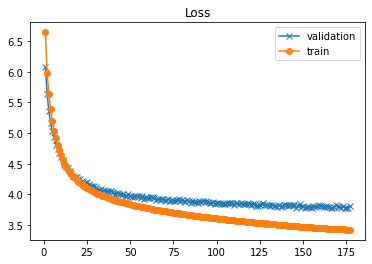

smallest val loss: (151, 3.7788458)
Current Lr:  0.00017221012

Time taken for this epoch: 24.42 secs

Epoch 178 Batch 0 Loss 3.0298
Epoch 178 Batch 150 Loss 3.3646
Epoch 178 Batch 300 Loss 3.3817
Epoch 178 Batch 450 Loss 3.3859
Epoch 178 Batch 600 Loss 3.4026
Epoch 178 Batch 750 Loss 3.4140

<UNK> st ever ball on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> born on christmas

validation started ...

* Validation loss: 3.763774871826172 

* Train Loss 3.4172


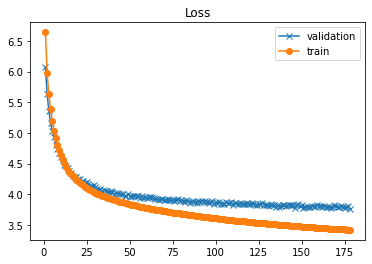

smallest val loss: (178, 3.7637749)
Current Lr:  0.00017050719

Time taken for this epoch: 24.59 secs

Epoch 179 Batch 0 Loss 3.2580
Epoch 179 Batch 150 Loss 3.3675
Epoch 179 Batch 300 Loss 3.3813
Epoch 179 Batch 450 Loss 3.3943
Epoch 179 Batch 600 Loss 3.4030
Epoch 179 Batch 750 Loss 3.4126

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks pm modi to make <UNK> for <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.806864023208618 

* Train Loss 3.4130


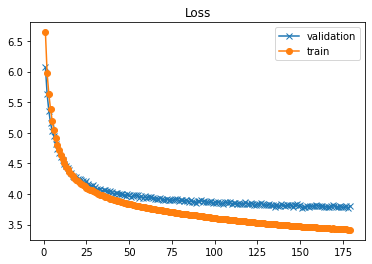

smallest val loss: (178, 3.7637749)
Current Lr:  0.00016882105

Time taken for this epoch: 24.74 secs

Epoch 180 Batch 0 Loss 3.3868
Epoch 180 Batch 150 Loss 3.3612
Epoch 180 Batch 300 Loss 3.3788
Epoch 180 Batch 450 Loss 3.3941
Epoch 180 Batch 600 Loss 3.4047
Epoch 180 Batch 750 Loss 3.4133

st <UNK> bowler was <UNK> on this day
dhoni trending on twitter today
pm modi thanks <UNK> for <UNK> toilets
kim kardashian was born on christmas <UNK>

validation started ...

* Validation loss: 3.762162685394287 

* Train Loss 3.4140


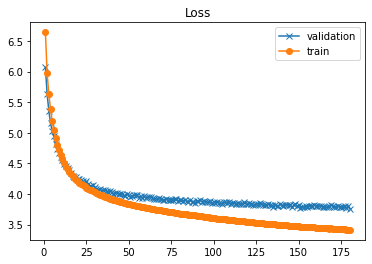

smallest val loss: (180, 3.7621627)
Current Lr:  0.0001671516

Time taken for this epoch: 24.11 secs

Epoch 181 Batch 0 Loss 3.3662
Epoch 181 Batch 150 Loss 3.3640
Epoch 181 Batch 300 Loss 3.3783
Epoch 181 Batch 450 Loss 3.3840
Epoch 181 Batch 600 Loss 3.3992
Epoch 181 Batch 750 Loss 3.4075

warne was st <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi thanks pm for <UNK> toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.793370246887207 

* Train Loss 3.4098


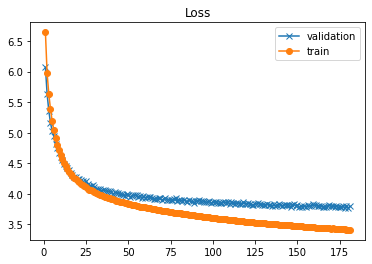

smallest val loss: (180, 3.7621627)
Current Lr:  0.00016549868

Time taken for this epoch: 24.51 secs

Epoch 182 Batch 0 Loss 3.3134
Epoch 182 Batch 150 Loss 3.3609
Epoch 182 Batch 300 Loss 3.3815
Epoch 182 Batch 450 Loss 3.3898
Epoch 182 Batch 600 Loss 3.4007
Epoch 182 Batch 750 Loss 3.4091

mcgrath was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> <UNK>
kim jongun <UNK> <UNK> born on christmas eve

validation started ...

* Validation loss: 3.7967910766601562 

* Train Loss 3.4091


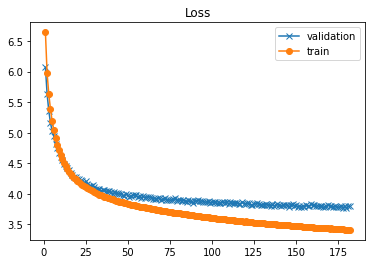

smallest val loss: (180, 3.7621627)
Current Lr:  0.00016386206

Time taken for this epoch: 24.64 secs

Epoch 183 Batch 0 Loss 3.5131
Epoch 183 Batch 150 Loss 3.3647
Epoch 183 Batch 300 Loss 3.3811
Epoch 183 Batch 450 Loss 3.3916
Epoch 183 Batch 600 Loss 3.3993
Epoch 183 Batch 750 Loss 3.4084

warne was st <UNK> on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7837839126586914 

* Train Loss 3.4107


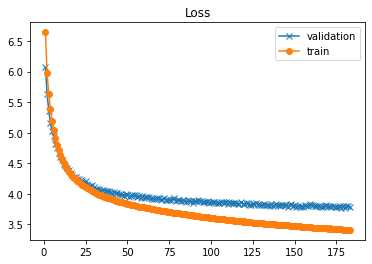

smallest val loss: (180, 3.7621627)
Current Lr:  0.00016224167

Time taken for this epoch: 24.41 secs

Epoch 184 Batch 0 Loss 3.2910
Epoch 184 Batch 150 Loss 3.3674
Epoch 184 Batch 300 Loss 3.3830
Epoch 184 Batch 450 Loss 3.3956
Epoch 184 Batch 600 Loss 3.4028
Epoch 184 Batch 750 Loss 3.4094

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks pm to make <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7802574634552 

* Train Loss 3.4094


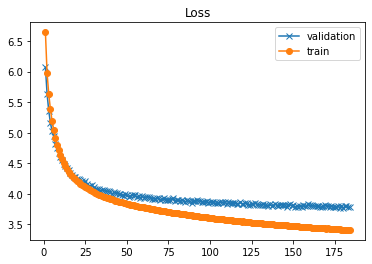

smallest val loss: (180, 3.7621627)
Current Lr:  0.00016063728

Time taken for this epoch: 24.33 secs

Epoch 185 Batch 0 Loss 3.0366
Epoch 185 Batch 150 Loss 3.3648
Epoch 185 Batch 300 Loss 3.3739
Epoch 185 Batch 450 Loss 3.3846
Epoch 185 Batch 600 Loss 3.3896
Epoch 185 Batch 750 Loss 3.4013

warne was st <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7927916049957275 

* Train Loss 3.4043


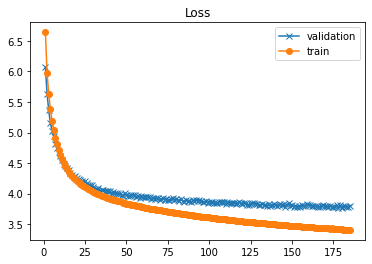

smallest val loss: (180, 3.7621627)
Current Lr:  0.00015904875

Time taken for this epoch: 24.36 secs

Epoch 186 Batch 0 Loss 3.2430
Epoch 186 Batch 150 Loss 3.3791
Epoch 186 Batch 300 Loss 3.3761
Epoch 186 Batch 450 Loss 3.3814
Epoch 186 Batch 600 Loss 3.3936
Epoch 186 Batch 750 Loss 3.4048

<UNK> st <UNK> <UNK> <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi thanks pm for <UNK> <UNK> <UNK>
kim jongun <UNK> <UNK> was born on <UNK>

validation started ...

* Validation loss: 3.7918922901153564 

* Train Loss 3.4066


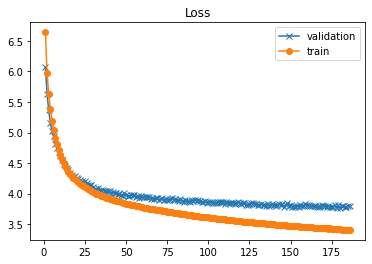

smallest val loss: (180, 3.7621627)
Current Lr:  0.00015747595

Time taken for this epoch: 24.73 secs

Epoch 187 Batch 0 Loss 3.2494
Epoch 187 Batch 150 Loss 3.3574
Epoch 187 Batch 300 Loss 3.3683
Epoch 187 Batch 450 Loss 3.3789
Epoch 187 Batch 600 Loss 3.3910
Epoch 187 Batch 750 Loss 3.3992

mcgrath was st <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks <UNK> for <UNK> <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7879374027252197 

* Train Loss 3.4008


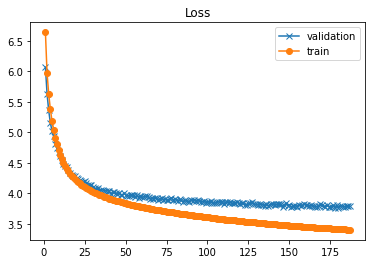

smallest val loss: (180, 3.7621627)
Current Lr:  0.00015591868

Time taken for this epoch: 24.41 secs

Epoch 188 Batch 0 Loss 3.3277
Epoch 188 Batch 150 Loss 3.3531
Epoch 188 Batch 300 Loss 3.3612
Epoch 188 Batch 450 Loss 3.3755
Epoch 188 Batch 600 Loss 3.3842
Epoch 188 Batch 750 Loss 3.4009

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.781723976135254 

* Train Loss 3.4013


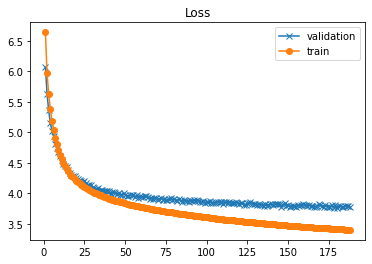

smallest val loss: (180, 3.7621627)
Current Lr:  0.00015437683

Time taken for this epoch: 25.28 secs

Epoch 189 Batch 0 Loss 3.4136
Epoch 189 Batch 150 Loss 3.3450
Epoch 189 Batch 300 Loss 3.3683
Epoch 189 Batch 450 Loss 3.3784
Epoch 189 Batch 600 Loss 3.3876
Epoch 189 Batch 750 Loss 3.3986

warne was st to take wickets on this day
dhoni trending on twitter today
pm modi thanks <UNK> for <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.783001184463501 

* Train Loss 3.3997


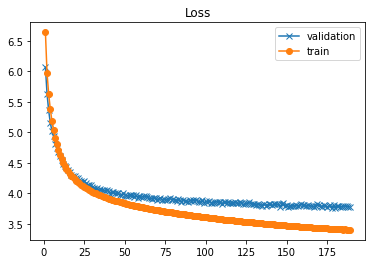

smallest val loss: (180, 3.7621627)
Current Lr:  0.00015285022

Time taken for this epoch: 24.35 secs

Epoch 190 Batch 0 Loss 3.3239
Epoch 190 Batch 150 Loss 3.3553
Epoch 190 Batch 300 Loss 3.3784
Epoch 190 Batch 450 Loss 3.3791
Epoch 190 Batch 600 Loss 3.3838
Epoch 190 Batch 750 Loss 3.3973

warne was the first to score runs on this day
dhoni trending on twitter today
pm modi thanks <UNK> for <UNK> <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7636899948120117 

* Train Loss 3.3985


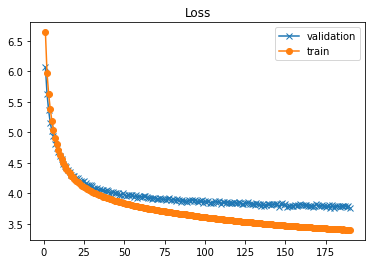

smallest val loss: (180, 3.7621627)
Current Lr:  0.00015133873

Time taken for this epoch: 24.51 secs

Epoch 191 Batch 0 Loss 3.3303
Epoch 191 Batch 150 Loss 3.3415
Epoch 191 Batch 300 Loss 3.3590
Epoch 191 Batch 450 Loss 3.3731
Epoch 191 Batch 600 Loss 3.3849
Epoch 191 Batch 750 Loss 3.3952

yrs since <UNK> <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi thanks pm for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7835967540740967 

* Train Loss 3.3980


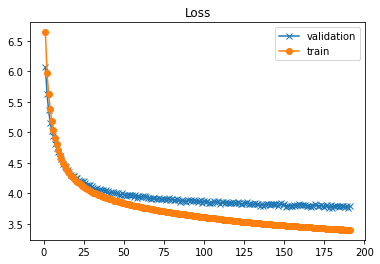

smallest val loss: (180, 3.7621627)
Current Lr:  0.00014984216

Time taken for this epoch: 28.84 secs

Epoch 192 Batch 0 Loss 3.2476
Epoch 192 Batch 150 Loss 3.3621
Epoch 192 Batch 300 Loss 3.3668
Epoch 192 Batch 450 Loss 3.3808
Epoch 192 Batch 600 Loss 3.3881
Epoch 192 Batch 750 Loss 3.3966

warne was st ever <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> toilets
kim jongun <UNK> <UNK> was born on christmas eve

validation started ...

* Validation loss: 3.7750978469848633 

* Train Loss 3.3987


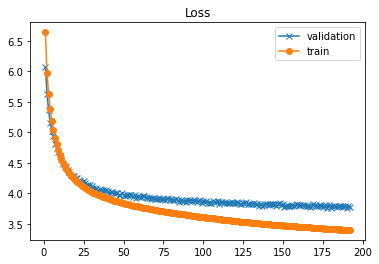

smallest val loss: (180, 3.7621627)
Current Lr:  0.00014836037

Time taken for this epoch: 24.95 secs

Epoch 193 Batch 0 Loss 3.1472
Epoch 193 Batch 150 Loss 3.3573
Epoch 193 Batch 300 Loss 3.3740
Epoch 193 Batch 450 Loss 3.3791
Epoch 193 Batch 600 Loss 3.3867
Epoch 193 Batch 750 Loss 3.3949

mcgrath st ever ball on this day on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> toilets
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.757633924484253 

* Train Loss 3.3939


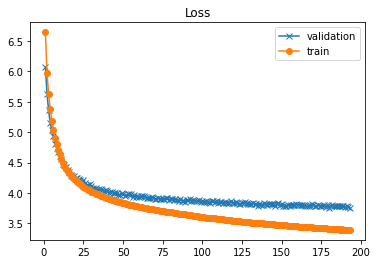

smallest val loss: (193, 3.757634)
Current Lr:  0.00014689328

Time taken for this epoch: 24.48 secs

Epoch 194 Batch 0 Loss 3.2170
Epoch 194 Batch 150 Loss 3.3402
Epoch 194 Batch 300 Loss 3.3573
Epoch 194 Batch 450 Loss 3.3724
Epoch 194 Batch 600 Loss 3.3841
Epoch 194 Batch 750 Loss 3.3913

warne was st to score <UNK> bowling on this day
dhoni trending on twitter today
pm modi urges pm modi to make toilets on <UNK>
kim jongun <UNK> <UNK> was born on <UNK>

validation started ...

* Validation loss: 3.7738726139068604 

* Train Loss 3.3933


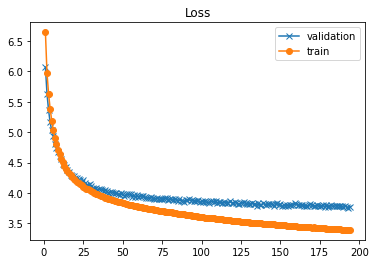

smallest val loss: (193, 3.757634)
Current Lr:  0.00014544064

Time taken for this epoch: 24.73 secs

Epoch 195 Batch 0 Loss 3.4212
Epoch 195 Batch 150 Loss 3.3423
Epoch 195 Batch 300 Loss 3.3623
Epoch 195 Batch 450 Loss 3.3694
Epoch 195 Batch 600 Loss 3.3794
Epoch 195 Batch 750 Loss 3.3900

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi congratulates modi to make toilets for <UNK>
kim kim <UNK> <UNK> <UNK> born on christmas

validation started ...

* Validation loss: 3.7750017642974854 

* Train Loss 3.3921


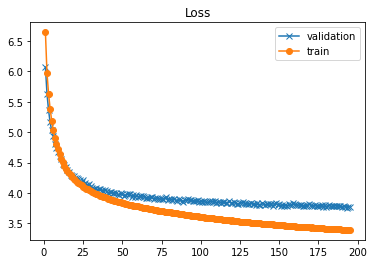

smallest val loss: (193, 3.757634)
Current Lr:  0.00014400244

Time taken for this epoch: 24.96 secs

Epoch 196 Batch 0 Loss 3.2400
Epoch 196 Batch 150 Loss 3.3395
Epoch 196 Batch 300 Loss 3.3605
Epoch 196 Batch 450 Loss 3.3620
Epoch 196 Batch 600 Loss 3.3760
Epoch 196 Batch 750 Loss 3.3871

first <UNK> <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi asks pm modi to make toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7804129123687744 

* Train Loss 3.3885


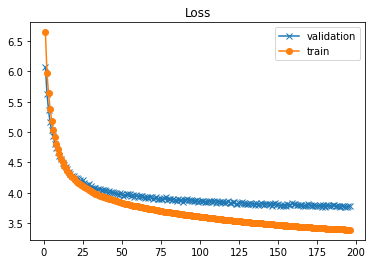

smallest val loss: (193, 3.757634)
Current Lr:  0.00014257841

Time taken for this epoch: 25.28 secs

Epoch 197 Batch 0 Loss 3.2322
Epoch 197 Batch 150 Loss 3.3535
Epoch 197 Batch 300 Loss 3.3624
Epoch 197 Batch 450 Loss 3.3683
Epoch 197 Batch 600 Loss 3.3754
Epoch 197 Batch 750 Loss 3.3879

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7845101356506348 

* Train Loss 3.3886


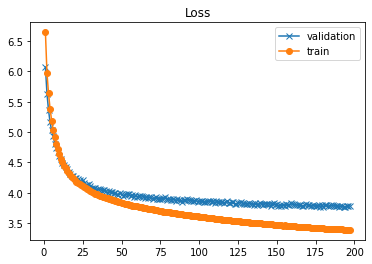

smallest val loss: (193, 3.757634)
Current Lr:  0.00014116845

Time taken for this epoch: 24.42 secs

Epoch 198 Batch 0 Loss 3.2806
Epoch 198 Batch 150 Loss 3.3558
Epoch 198 Batch 300 Loss 3.3691
Epoch 198 Batch 450 Loss 3.3780
Epoch 198 Batch 600 Loss 3.3801
Epoch 198 Batch 750 Loss 3.3883

warne was st ever <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7757019996643066 

* Train Loss 3.3882


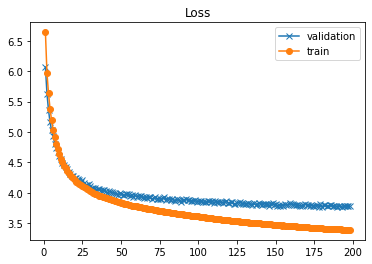

smallest val loss: (193, 3.757634)
Current Lr:  0.00013977247

Time taken for this epoch: 24.76 secs

Epoch 199 Batch 0 Loss 3.4888
Epoch 199 Batch 150 Loss 3.3504
Epoch 199 Batch 300 Loss 3.3641
Epoch 199 Batch 450 Loss 3.3692
Epoch 199 Batch 600 Loss 3.3771
Epoch 199 Batch 750 Loss 3.3841

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.76595139503479 

* Train Loss 3.3859


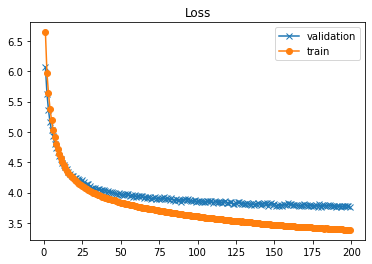

smallest val loss: (193, 3.757634)
Current Lr:  0.00013839026

Time taken for this epoch: 24.82 secs

Epoch 200 Batch 0 Loss 3.2533
Epoch 200 Batch 150 Loss 3.3268
Epoch 200 Batch 300 Loss 3.3498
Epoch 200 Batch 450 Loss 3.3657
Epoch 200 Batch 600 Loss 3.3762
Epoch 200 Batch 750 Loss 3.3829

warne was st to score <UNK> bowling on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.781517744064331 

* Train Loss 3.3828


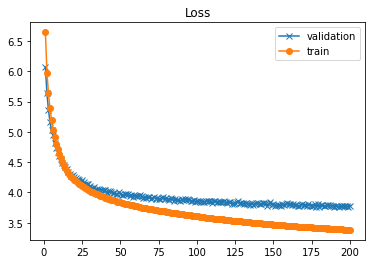

smallest val loss: (193, 3.757634)
Current Lr:  0.00013702172

Time taken for this epoch: 24.93 secs

Epoch 201 Batch 0 Loss 3.3544
Epoch 201 Batch 150 Loss 3.3423
Epoch 201 Batch 300 Loss 3.3574
Epoch 201 Batch 450 Loss 3.3691
Epoch 201 Batch 600 Loss 3.3705
Epoch 201 Batch 750 Loss 3.3823

warne was st to score runs on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.803689479827881 

* Train Loss 3.3832


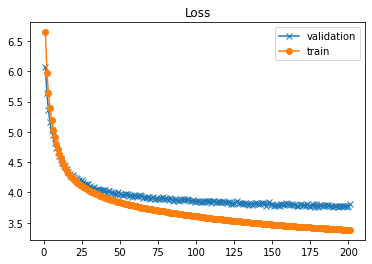

smallest val loss: (193, 3.757634)
Current Lr:  0.00013566676

Time taken for this epoch: 25.12 secs

Epoch 202 Batch 0 Loss 3.2912
Epoch 202 Batch 150 Loss 3.3311
Epoch 202 Batch 300 Loss 3.3494
Epoch 202 Batch 450 Loss 3.3628
Epoch 202 Batch 600 Loss 3.3727
Epoch 202 Batch 750 Loss 3.3781

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7639646530151367 

* Train Loss 3.3786


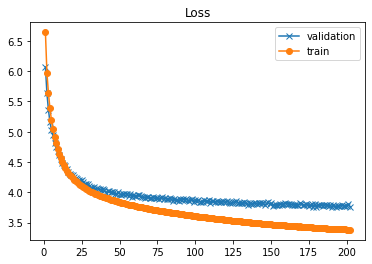

smallest val loss: (193, 3.757634)
Current Lr:  0.00013432516

Time taken for this epoch: 24.31 secs

Epoch 203 Batch 0 Loss 2.9194
Epoch 203 Batch 150 Loss 3.3297
Epoch 203 Batch 300 Loss 3.3418
Epoch 203 Batch 450 Loss 3.3540
Epoch 203 Batch 600 Loss 3.3660
Epoch 203 Batch 750 Loss 3.3798

<UNK> st ever <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7993695735931396 

* Train Loss 3.3800


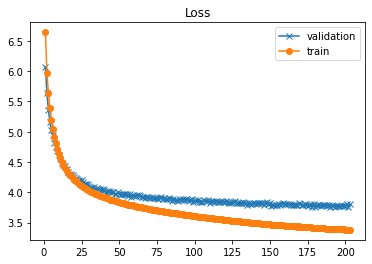

smallest val loss: (193, 3.757634)
Current Lr:  0.00013299687

Time taken for this epoch: 24.60 secs

Epoch 204 Batch 0 Loss 3.2670
Epoch 204 Batch 150 Loss 3.3433
Epoch 204 Batch 300 Loss 3.3503
Epoch 204 Batch 450 Loss 3.3602
Epoch 204 Batch 600 Loss 3.3663
Epoch 204 Batch 750 Loss 3.3757

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.780471086502075 

* Train Loss 3.3777


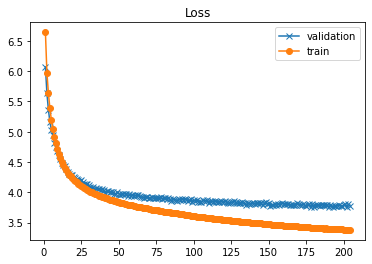

smallest val loss: (193, 3.757634)
Current Lr:  0.00013168166

Time taken for this epoch: 25.02 secs

Epoch 205 Batch 0 Loss 3.3629
Epoch 205 Batch 150 Loss 3.3187
Epoch 205 Batch 300 Loss 3.3371
Epoch 205 Batch 450 Loss 3.3521
Epoch 205 Batch 600 Loss 3.3618
Epoch 205 Batch 750 Loss 3.3736

warne was st to score runs on this day
dhoni trending on twitter today
pm modi urges pm to make toilets for <UNK> toilets
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7574007511138916 

* Train Loss 3.3745


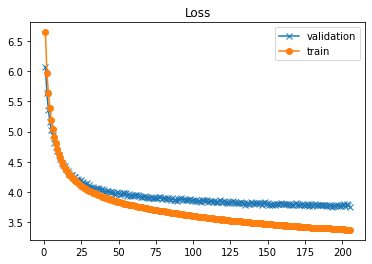

smallest val loss: (205, 3.7574008)
Current Lr:  0.00013037949

Time taken for this epoch: 25.10 secs

Epoch 206 Batch 0 Loss 3.5075
Epoch 206 Batch 150 Loss 3.3382
Epoch 206 Batch 300 Loss 3.3534
Epoch 206 Batch 450 Loss 3.3612
Epoch 206 Batch 600 Loss 3.3673
Epoch 206 Batch 750 Loss 3.3741

warne was st to win a ball on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.763119697570801 

* Train Loss 3.3741


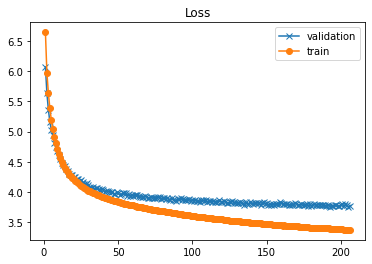

smallest val loss: (205, 3.7574008)
Current Lr:  0.0001290902

Time taken for this epoch: 24.78 secs

Epoch 207 Batch 0 Loss 3.2233
Epoch 207 Batch 150 Loss 3.3265
Epoch 207 Batch 300 Loss 3.3422
Epoch 207 Batch 450 Loss 3.3576
Epoch 207 Batch 600 Loss 3.3660
Epoch 207 Batch 750 Loss 3.3742

warne was st to score runs on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7901976108551025 

* Train Loss 3.3769


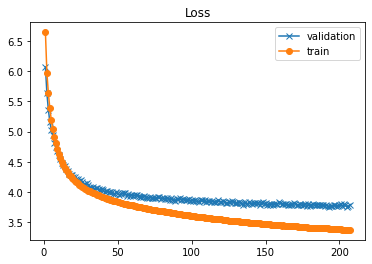

smallest val loss: (205, 3.7574008)
Current Lr:  0.00012781365

Time taken for this epoch: 24.50 secs

Epoch 208 Batch 0 Loss 3.1547
Epoch 208 Batch 150 Loss 3.3260
Epoch 208 Batch 300 Loss 3.3450
Epoch 208 Batch 450 Loss 3.3563
Epoch 208 Batch 600 Loss 3.3625
Epoch 208 Batch 750 Loss 3.3715

warne was st to win a ball on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7846062183380127 

* Train Loss 3.3732


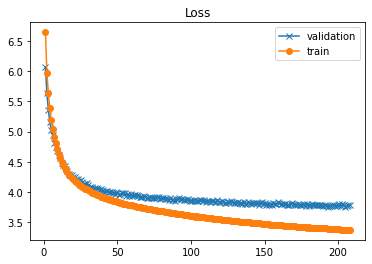

smallest val loss: (205, 3.7574008)
Current Lr:  0.00012654971

Time taken for this epoch: 24.59 secs

Epoch 209 Batch 0 Loss 3.1101
Epoch 209 Batch 150 Loss 3.3184
Epoch 209 Batch 300 Loss 3.3355
Epoch 209 Batch 450 Loss 3.3504
Epoch 209 Batch 600 Loss 3.3620
Epoch 209 Batch 750 Loss 3.3704

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.779665470123291 

* Train Loss 3.3714


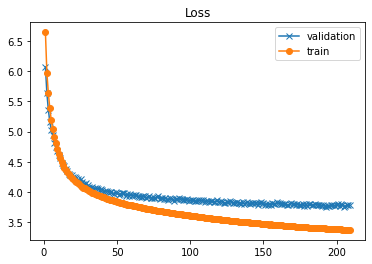

smallest val loss: (205, 3.7574008)
Current Lr:  0.00012529823

Time taken for this epoch: 24.65 secs

Epoch 210 Batch 0 Loss 3.6147
Epoch 210 Batch 150 Loss 3.3360
Epoch 210 Batch 300 Loss 3.3499
Epoch 210 Batch 450 Loss 3.3548
Epoch 210 Batch 600 Loss 3.3617
Epoch 210 Batch 750 Loss 3.3719

mcgrath was st <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.765486001968384 

* Train Loss 3.3721


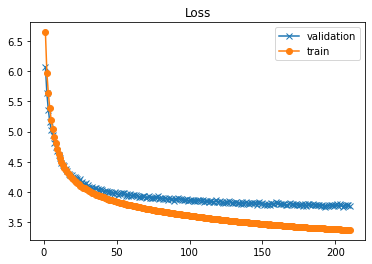

smallest val loss: (205, 3.7574008)
Current Lr:  0.0001240592

Time taken for this epoch: 24.11 secs

Epoch 211 Batch 0 Loss 2.9983
Epoch 211 Batch 150 Loss 3.3221
Epoch 211 Batch 300 Loss 3.3329
Epoch 211 Batch 450 Loss 3.3439
Epoch 211 Batch 600 Loss 3.3568
Epoch 211 Batch 750 Loss 3.3679

st ever <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.784593105316162 

* Train Loss 3.3680


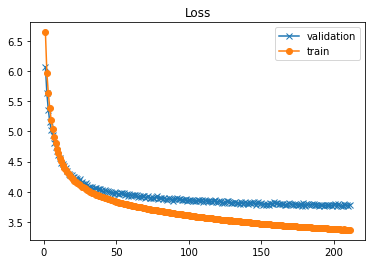

smallest val loss: (205, 3.7574008)
Current Lr:  0.0001228324

Time taken for this epoch: 25.04 secs

Epoch 212 Batch 0 Loss 3.2251
Epoch 212 Batch 150 Loss 3.3136
Epoch 212 Batch 300 Loss 3.3447
Epoch 212 Batch 450 Loss 3.3540
Epoch 212 Batch 600 Loss 3.3620
Epoch 212 Batch 750 Loss 3.3683

st ever <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi urges pm to make toilets for <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.797151803970337 

* Train Loss 3.3689


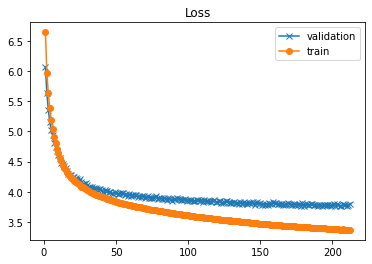

smallest val loss: (205, 3.7574008)
Current Lr:  0.00012161772

Time taken for this epoch: 24.58 secs

Epoch 213 Batch 0 Loss 3.4737
Epoch 213 Batch 150 Loss 3.3159
Epoch 213 Batch 300 Loss 3.3258
Epoch 213 Batch 450 Loss 3.3444
Epoch 213 Batch 600 Loss 3.3524
Epoch 213 Batch 750 Loss 3.3639

first ever <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7728166580200195 

* Train Loss 3.3644


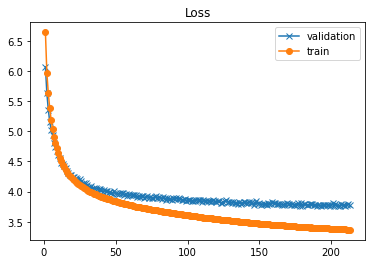

smallest val loss: (205, 3.7574008)
Current Lr:  0.000120415076

Time taken for this epoch: 25.02 secs

Epoch 214 Batch 0 Loss 3.3723
Epoch 214 Batch 150 Loss 3.3263
Epoch 214 Batch 300 Loss 3.3405
Epoch 214 Batch 450 Loss 3.3484
Epoch 214 Batch 600 Loss 3.3560
Epoch 214 Batch 750 Loss 3.3621

warne was st <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7626922130584717 

* Train Loss 3.3629


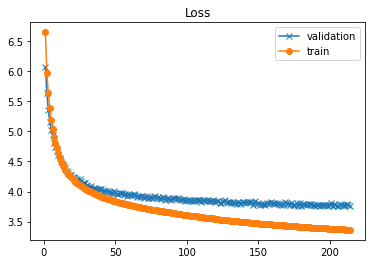

smallest val loss: (205, 3.7574008)
Current Lr:  0.000119224285

Time taken for this epoch: 24.49 secs

Epoch 215 Batch 0 Loss 3.1127
Epoch 215 Batch 150 Loss 3.3217
Epoch 215 Batch 300 Loss 3.3407
Epoch 215 Batch 450 Loss 3.3473
Epoch 215 Batch 600 Loss 3.3543
Epoch 215 Batch 750 Loss 3.3632

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.767580986022949 

* Train Loss 3.3653


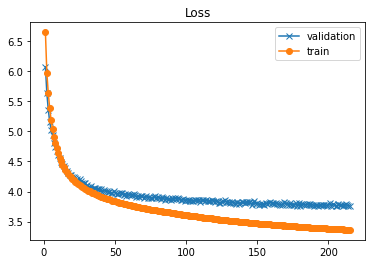

smallest val loss: (205, 3.7574008)
Current Lr:  0.00011804531

Time taken for this epoch: 24.81 secs

Epoch 216 Batch 0 Loss 3.1642
Epoch 216 Batch 150 Loss 3.3247
Epoch 216 Batch 300 Loss 3.3464
Epoch 216 Batch 450 Loss 3.3423
Epoch 216 Batch 600 Loss 3.3546
Epoch 216 Batch 750 Loss 3.3600

warne scored a <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7770607471466064 

* Train Loss 3.3614


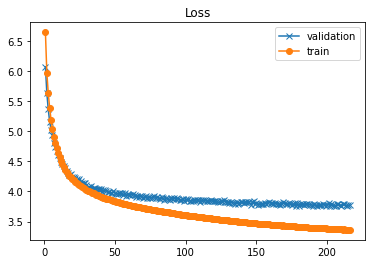

smallest val loss: (205, 3.7574008)
Current Lr:  0.00011687798

Time taken for this epoch: 24.60 secs

Epoch 217 Batch 0 Loss 3.3809
Epoch 217 Batch 150 Loss 3.3182
Epoch 217 Batch 300 Loss 3.3345
Epoch 217 Batch 450 Loss 3.3466
Epoch 217 Batch 600 Loss 3.3567
Epoch 217 Batch 750 Loss 3.3612

mcgrath was st to win <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.762150526046753 

* Train Loss 3.3633


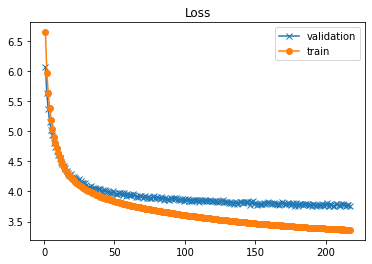

smallest val loss: (205, 3.7574008)
Current Lr:  0.000115722185

Time taken for this epoch: 24.86 secs

Epoch 218 Batch 0 Loss 3.5744
Epoch 218 Batch 150 Loss 3.3278
Epoch 218 Batch 300 Loss 3.3420
Epoch 218 Batch 450 Loss 3.3460
Epoch 218 Batch 600 Loss 3.3544
Epoch 218 Batch 750 Loss 3.3590

warne was st to win a ball on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7619216442108154 

* Train Loss 3.3613


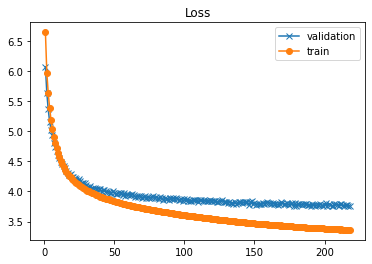

smallest val loss: (205, 3.7574008)
Current Lr:  0.00011457784

Time taken for this epoch: 24.52 secs

Epoch 219 Batch 0 Loss 3.5200
Epoch 219 Batch 150 Loss 3.3003
Epoch 219 Batch 300 Loss 3.3257
Epoch 219 Batch 450 Loss 3.3374
Epoch 219 Batch 600 Loss 3.3491
Epoch 219 Batch 750 Loss 3.3587

warne was st to take a <UNK> wickets on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7730093002319336 

* Train Loss 3.3596


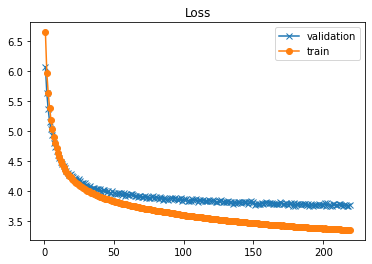

smallest val loss: (205, 3.7574008)
Current Lr:  0.00011344478

Time taken for this epoch: 24.92 secs

Epoch 220 Batch 0 Loss 3.3152
Epoch 220 Batch 150 Loss 3.3202
Epoch 220 Batch 300 Loss 3.3328
Epoch 220 Batch 450 Loss 3.3417
Epoch 220 Batch 600 Loss 3.3490
Epoch 220 Batch 750 Loss 3.3544

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7803726196289062 

* Train Loss 3.3554


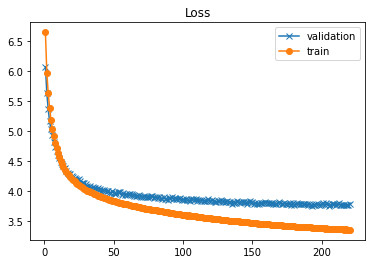

smallest val loss: (205, 3.7574008)
Current Lr:  0.000112322945

Time taken for this epoch: 24.57 secs

Epoch 221 Batch 0 Loss 3.3600
Epoch 221 Batch 150 Loss 3.3127
Epoch 221 Batch 300 Loss 3.3263
Epoch 221 Batch 450 Loss 3.3367
Epoch 221 Batch 600 Loss 3.3472
Epoch 221 Batch 750 Loss 3.3544

warne scored the first ever <UNK> <UNK> century on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7814202308654785 

* Train Loss 3.3559


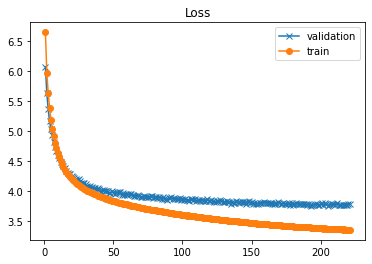

smallest val loss: (205, 3.7574008)
Current Lr:  0.000111212205

Time taken for this epoch: 25.32 secs

Epoch 222 Batch 0 Loss 3.4363
Epoch 222 Batch 150 Loss 3.3212
Epoch 222 Batch 300 Loss 3.3396
Epoch 222 Batch 450 Loss 3.3435
Epoch 222 Batch 600 Loss 3.3494
Epoch 222 Batch 750 Loss 3.3520

warne was st to score a ball on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.770596981048584 

* Train Loss 3.3528


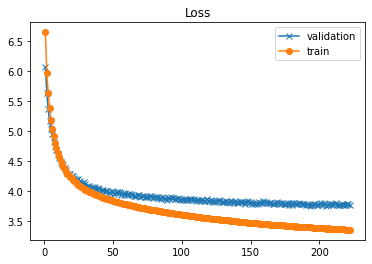

smallest val loss: (205, 3.7574008)
Current Lr:  0.00011011242

Time taken for this epoch: 24.63 secs

Epoch 223 Batch 0 Loss 3.3177
Epoch 223 Batch 150 Loss 3.3342
Epoch 223 Batch 300 Loss 3.3416
Epoch 223 Batch 450 Loss 3.3434
Epoch 223 Batch 600 Loss 3.3489
Epoch 223 Batch 750 Loss 3.3523

warne was st to win a ball on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7583937644958496 

* Train Loss 3.3535


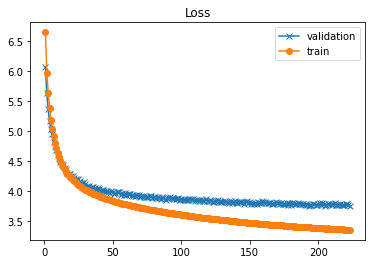

smallest val loss: (205, 3.7574008)
Current Lr:  0.00010902354

Time taken for this epoch: 24.94 secs

Epoch 224 Batch 0 Loss 3.3381
Epoch 224 Batch 150 Loss 3.3229
Epoch 224 Batch 300 Loss 3.3307
Epoch 224 Batch 450 Loss 3.3386
Epoch 224 Batch 600 Loss 3.3438
Epoch 224 Batch 750 Loss 3.3522

st ever <UNK> ball on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7894699573516846 

* Train Loss 3.3537


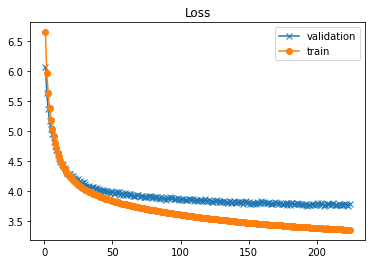

smallest val loss: (205, 3.7574008)
Current Lr:  0.00010794542

Time taken for this epoch: 24.54 secs

Epoch 225 Batch 0 Loss 3.2769
Epoch 225 Batch 150 Loss 3.3241
Epoch 225 Batch 300 Loss 3.3270
Epoch 225 Batch 450 Loss 3.3332
Epoch 225 Batch 600 Loss 3.3437
Epoch 225 Batch 750 Loss 3.3514

warne was st to score wickets on this day
dhoni trending on twitter today
pm congratulates modi for <UNK> <UNK> <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7669997215270996 

* Train Loss 3.3527


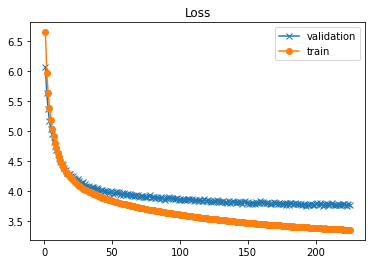

smallest val loss: (205, 3.7574008)
Current Lr:  0.00010687797

Time taken for this epoch: 24.65 secs

Epoch 226 Batch 0 Loss 3.2946
Epoch 226 Batch 150 Loss 3.3132
Epoch 226 Batch 300 Loss 3.3213
Epoch 226 Batch 450 Loss 3.3321
Epoch 226 Batch 600 Loss 3.3436
Epoch 226 Batch 750 Loss 3.3518

warne was st to score a <UNK> bowling on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7681405544281006 

* Train Loss 3.3512


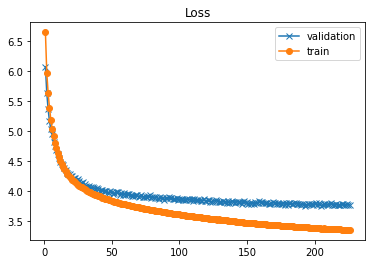

smallest val loss: (205, 3.7574008)
Current Lr:  0.00010582108

Time taken for this epoch: 24.39 secs

Epoch 227 Batch 0 Loss 3.3498
Epoch 227 Batch 150 Loss 3.3023
Epoch 227 Batch 300 Loss 3.3281
Epoch 227 Batch 450 Loss 3.3317
Epoch 227 Batch 600 Loss 3.3355
Epoch 227 Batch 750 Loss 3.3446

warne was st to score a ball on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7753114700317383 

* Train Loss 3.3487


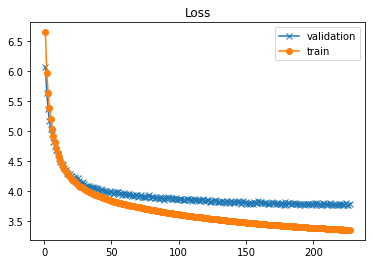

smallest val loss: (205, 3.7574008)
Current Lr:  0.00010477462

Time taken for this epoch: 25.07 secs

Epoch 228 Batch 0 Loss 3.2393
Epoch 228 Batch 150 Loss 3.3210
Epoch 228 Batch 300 Loss 3.3299
Epoch 228 Batch 450 Loss 3.3313
Epoch 228 Batch 600 Loss 3.3363
Epoch 228 Batch 750 Loss 3.3466

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> to <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.8080103397369385 

* Train Loss 3.3481


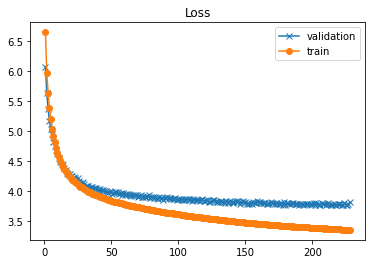

smallest val loss: (205, 3.7574008)
Current Lr:  0.00010373853

Time taken for this epoch: 24.73 secs

Epoch 229 Batch 0 Loss 3.2922
Epoch 229 Batch 150 Loss 3.3139
Epoch 229 Batch 300 Loss 3.3219
Epoch 229 Batch 450 Loss 3.3294
Epoch 229 Batch 600 Loss 3.3376
Epoch 229 Batch 750 Loss 3.3484

warne was st to score a <UNK> <UNK>
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.775432586669922 

* Train Loss 3.3497


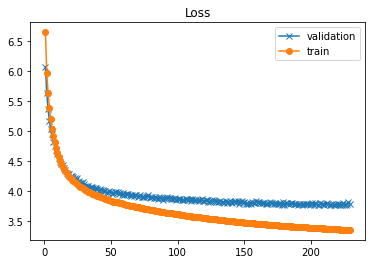

smallest val loss: (205, 3.7574008)
Current Lr:  0.00010271266

Time taken for this epoch: 24.83 secs

Epoch 230 Batch 0 Loss 3.3249
Epoch 230 Batch 150 Loss 3.3093
Epoch 230 Batch 300 Loss 3.3233
Epoch 230 Batch 450 Loss 3.3304
Epoch 230 Batch 600 Loss 3.3357
Epoch 230 Batch 750 Loss 3.3438

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korea leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7710325717926025 

* Train Loss 3.3448


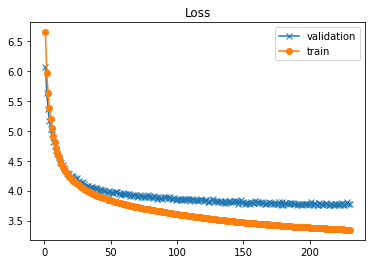

smallest val loss: (205, 3.7574008)
Current Lr:  0.000101696955

Time taken for this epoch: 24.57 secs

Epoch 231 Batch 0 Loss 3.3919
Epoch 231 Batch 150 Loss 3.3090
Epoch 231 Batch 300 Loss 3.3182
Epoch 231 Batch 450 Loss 3.3269
Epoch 231 Batch 600 Loss 3.3314
Epoch 231 Batch 750 Loss 3.3412

warne was st to score wickets on this day
dhoni <UNK> trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.778364658355713 

* Train Loss 3.3437


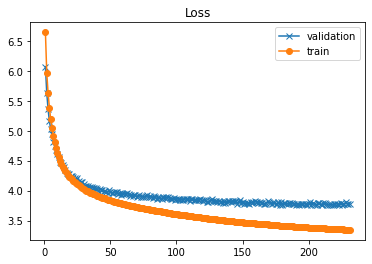

smallest val loss: (205, 3.7574008)
Current Lr:  0.0001006913

Time taken for this epoch: 25.22 secs

Epoch 232 Batch 0 Loss 3.1461
Epoch 232 Batch 150 Loss 3.3017
Epoch 232 Batch 300 Loss 3.3305
Epoch 232 Batch 450 Loss 3.3309
Epoch 232 Batch 600 Loss 3.3366
Epoch 232 Batch 750 Loss 3.3421

st ever ball was <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7724721431732178 

* Train Loss 3.3423


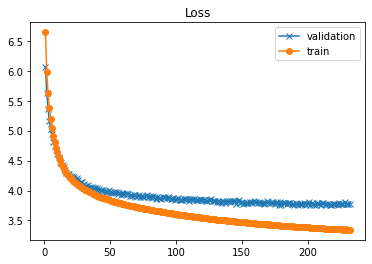

smallest val loss: (205, 3.7574008)
Current Lr:  9.969557e-05

Time taken for this epoch: 24.93 secs

Epoch 233 Batch 0 Loss 3.1747
Epoch 233 Batch 150 Loss 3.2918
Epoch 233 Batch 300 Loss 3.3067
Epoch 233 Batch 450 Loss 3.3206
Epoch 233 Batch 600 Loss 3.3288
Epoch 233 Batch 750 Loss 3.3413

warne was st to win a ball on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7787516117095947 

* Train Loss 3.3425


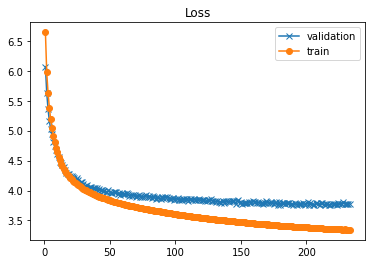

smallest val loss: (205, 3.7574008)
Current Lr:  9.87097e-05

Time taken for this epoch: 25.14 secs

Epoch 234 Batch 0 Loss 3.3098
Epoch 234 Batch 150 Loss 3.2923
Epoch 234 Batch 300 Loss 3.3088
Epoch 234 Batch 450 Loss 3.3236
Epoch 234 Batch 600 Loss 3.3304
Epoch 234 Batch 750 Loss 3.3408

warne was st to score <UNK> bowling on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7664594650268555 

* Train Loss 3.3429


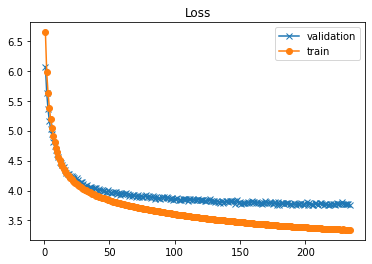

smallest val loss: (205, 3.7574008)
Current Lr:  9.7733544e-05

Time taken for this epoch: 24.60 secs

Epoch 235 Batch 0 Loss 3.1085
Epoch 235 Batch 150 Loss 3.3082
Epoch 235 Batch 300 Loss 3.3271
Epoch 235 Batch 450 Loss 3.3291
Epoch 235 Batch 600 Loss 3.3328
Epoch 235 Batch 750 Loss 3.3411

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.772162675857544 

* Train Loss 3.3399


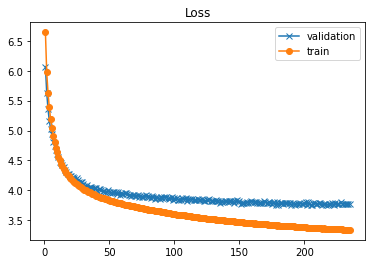

smallest val loss: (205, 3.7574008)
Current Lr:  9.676708e-05

Time taken for this epoch: 24.95 secs

Epoch 236 Batch 0 Loss 3.3231
Epoch 236 Batch 150 Loss 3.3122
Epoch 236 Batch 300 Loss 3.3170
Epoch 236 Batch 450 Loss 3.3242
Epoch 236 Batch 600 Loss 3.3334
Epoch 236 Batch 750 Loss 3.3392

warne was st to score a <UNK> <UNK>
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> to <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.772369146347046 

* Train Loss 3.3405


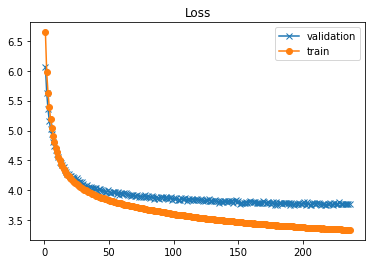

smallest val loss: (205, 3.7574008)
Current Lr:  9.581018e-05

Time taken for this epoch: 25.08 secs

Epoch 237 Batch 0 Loss 3.1561
Epoch 237 Batch 150 Loss 3.2977
Epoch 237 Batch 300 Loss 3.3145
Epoch 237 Batch 450 Loss 3.3185
Epoch 237 Batch 600 Loss 3.3261
Epoch 237 Batch 750 Loss 3.3380

first <UNK> <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7718026638031006 

* Train Loss 3.3389


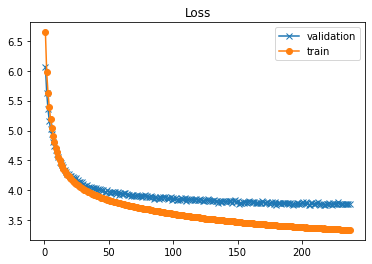

smallest val loss: (205, 3.7574008)
Current Lr:  9.486271e-05

Time taken for this epoch: 24.90 secs

Epoch 238 Batch 0 Loss 3.2578
Epoch 238 Batch 150 Loss 3.2886
Epoch 238 Batch 300 Loss 3.3088
Epoch 238 Batch 450 Loss 3.3219
Epoch 238 Batch 600 Loss 3.3273
Epoch 238 Batch 750 Loss 3.3358

mcgrath was st to score wickets on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.755164384841919 

* Train Loss 3.3368


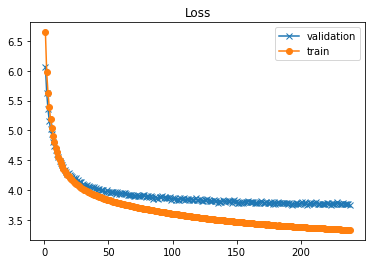

smallest val loss: (238, 3.7551644)
Current Lr:  9.392464e-05

Time taken for this epoch: 24.37 secs

Epoch 239 Batch 0 Loss 3.2608
Epoch 239 Batch 150 Loss 3.2958
Epoch 239 Batch 300 Loss 3.3157
Epoch 239 Batch 450 Loss 3.3180
Epoch 239 Batch 600 Loss 3.3283
Epoch 239 Batch 750 Loss 3.3368

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7519545555114746 

* Train Loss 3.3371


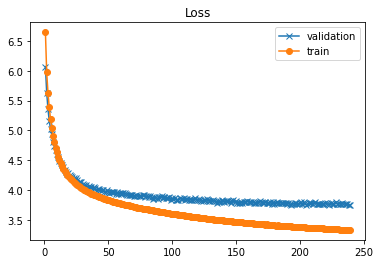

smallest val loss: (239, 3.7519546)
Current Lr:  9.299582e-05

Time taken for this epoch: 25.18 secs

Epoch 240 Batch 0 Loss 3.4191
Epoch 240 Batch 150 Loss 3.3075
Epoch 240 Batch 300 Loss 3.3148
Epoch 240 Batch 450 Loss 3.3217
Epoch 240 Batch 600 Loss 3.3275
Epoch 240 Batch 750 Loss 3.3316

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.769167900085449 

* Train Loss 3.3334


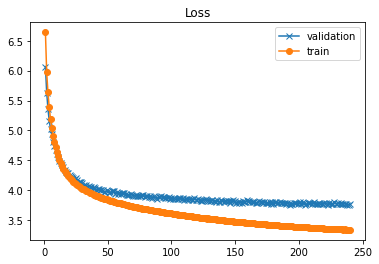

smallest val loss: (239, 3.7519546)
Current Lr:  9.207621e-05

Time taken for this epoch: 24.95 secs

Epoch 241 Batch 0 Loss 3.2228
Epoch 241 Batch 150 Loss 3.3085
Epoch 241 Batch 300 Loss 3.3131
Epoch 241 Batch 450 Loss 3.3193
Epoch 241 Batch 600 Loss 3.3268
Epoch 241 Batch 750 Loss 3.3343

warne was st to score a <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7563791275024414 

* Train Loss 3.3369


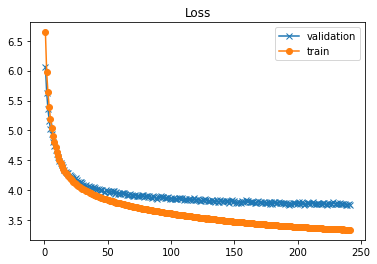

smallest val loss: (239, 3.7519546)
Current Lr:  9.116568e-05

Time taken for this epoch: 25.17 secs

Epoch 242 Batch 0 Loss 3.2889
Epoch 242 Batch 150 Loss 3.3057
Epoch 242 Batch 300 Loss 3.3125
Epoch 242 Batch 450 Loss 3.3195
Epoch 242 Batch 600 Loss 3.3244
Epoch 242 Batch 750 Loss 3.3319

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.776749610900879 

* Train Loss 3.3331


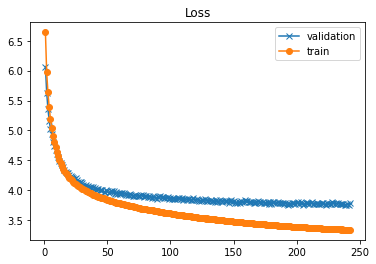

smallest val loss: (239, 3.7519546)
Current Lr:  9.026415e-05

Time taken for this epoch: 24.47 secs

Epoch 243 Batch 0 Loss 3.4657
Epoch 243 Batch 150 Loss 3.3048
Epoch 243 Batch 300 Loss 3.3099
Epoch 243 Batch 450 Loss 3.3156
Epoch 243 Batch 600 Loss 3.3224
Epoch 243 Batch 750 Loss 3.3315

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7649567127227783 

* Train Loss 3.3322


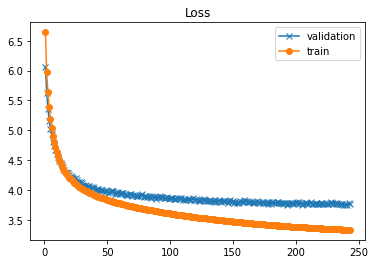

smallest val loss: (239, 3.7519546)
Current Lr:  8.937155e-05

Time taken for this epoch: 24.71 secs

Epoch 244 Batch 0 Loss 3.4317
Epoch 244 Batch 150 Loss 3.2992
Epoch 244 Batch 300 Loss 3.3113
Epoch 244 Batch 450 Loss 3.3162
Epoch 244 Batch 600 Loss 3.3232
Epoch 244 Batch 750 Loss 3.3279

warne was st to score runs on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongnams <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.771733045578003 

* Train Loss 3.3287


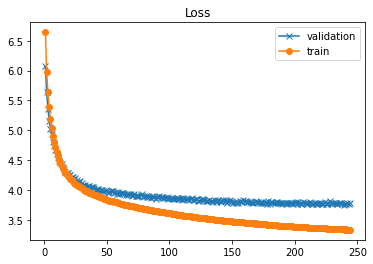

smallest val loss: (239, 3.7519546)
Current Lr:  8.848776e-05

Time taken for this epoch: 25.08 secs

Epoch 245 Batch 0 Loss 3.1322
Epoch 245 Batch 150 Loss 3.2865
Epoch 245 Batch 300 Loss 3.3062
Epoch 245 Batch 450 Loss 3.3124
Epoch 245 Batch 600 Loss 3.3184
Epoch 245 Batch 750 Loss 3.3276

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.783216714859009 

* Train Loss 3.3301


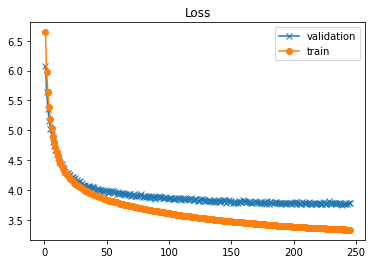

smallest val loss: (239, 3.7519546)
Current Lr:  8.761272e-05

Time taken for this epoch: 25.70 secs

Epoch 246 Batch 0 Loss 3.0400
Epoch 246 Batch 150 Loss 3.3017
Epoch 246 Batch 300 Loss 3.3146
Epoch 246 Batch 450 Loss 3.3195
Epoch 246 Batch 600 Loss 3.3243
Epoch 246 Batch 750 Loss 3.3277

warne was st to score wickets on this day
dhoni <UNK> trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.776779890060425 

* Train Loss 3.3292


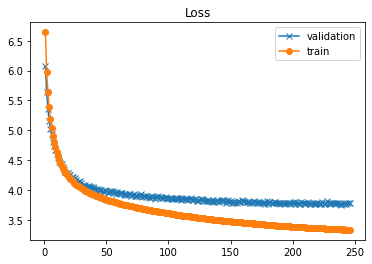

smallest val loss: (239, 3.7519546)
Current Lr:  8.674633e-05

Time taken for this epoch: 25.46 secs

Epoch 247 Batch 0 Loss 3.3361
Epoch 247 Batch 150 Loss 3.3001
Epoch 247 Batch 300 Loss 3.3096
Epoch 247 Batch 450 Loss 3.3198
Epoch 247 Batch 600 Loss 3.3261
Epoch 247 Batch 750 Loss 3.3277

first <UNK> bowler was <UNK> on this day
dhoni trending on twitter today
pm modi congratulates pm modi for <UNK> toilets
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7651689052581787 

* Train Loss 3.3299


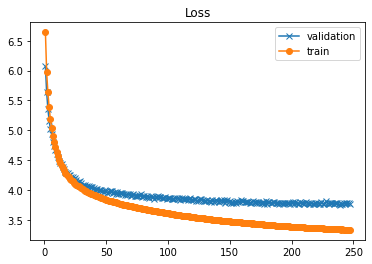

smallest val loss: (239, 3.7519546)
Current Lr:  8.588849e-05

Time taken for this epoch: 24.66 secs

Epoch 248 Batch 0 Loss 3.2654
Epoch 248 Batch 150 Loss 3.2890
Epoch 248 Batch 300 Loss 3.3022
Epoch 248 Batch 450 Loss 3.3090
Epoch 248 Batch 600 Loss 3.3195
Epoch 248 Batch 750 Loss 3.3283

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> was born on christmas eve

validation started ...

* Validation loss: 3.7590324878692627 

* Train Loss 3.3292


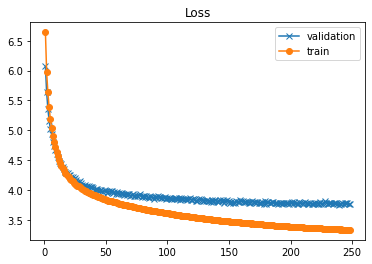

smallest val loss: (239, 3.7519546)
Current Lr:  8.503916e-05

Time taken for this epoch: 25.66 secs

Epoch 249 Batch 0 Loss 3.3623
Epoch 249 Batch 150 Loss 3.3086
Epoch 249 Batch 300 Loss 3.3089
Epoch 249 Batch 450 Loss 3.3120
Epoch 249 Batch 600 Loss 3.3179
Epoch 249 Batch 750 Loss 3.3248

warne was st ever <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks <UNK> for <UNK> <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7593576908111572 

* Train Loss 3.3261


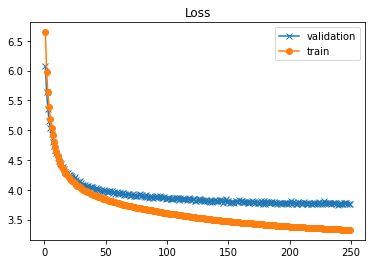

smallest val loss: (239, 3.7519546)
Current Lr:  8.4198226e-05

Time taken for this epoch: 24.92 secs

Epoch 250 Batch 0 Loss 3.4281
Epoch 250 Batch 150 Loss 3.2862
Epoch 250 Batch 300 Loss 3.2915
Epoch 250 Batch 450 Loss 3.3047
Epoch 250 Batch 600 Loss 3.3144
Epoch 250 Batch 750 Loss 3.3249

warne was st to score a ball on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.744640588760376 

* Train Loss 3.3260


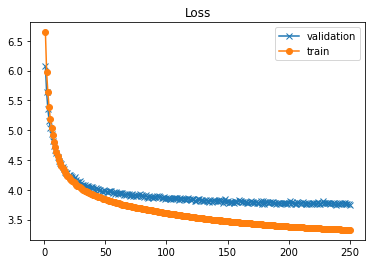

smallest val loss: (250, 3.7446406)
Current Lr:  8.33656e-05

Time taken for this epoch: 25.04 secs

Epoch 251 Batch 0 Loss 3.6205
Epoch 251 Batch 150 Loss 3.2921
Epoch 251 Batch 300 Loss 3.3009
Epoch 251 Batch 450 Loss 3.3089
Epoch 251 Batch 600 Loss 3.3169
Epoch 251 Batch 750 Loss 3.3222

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.748366355895996 

* Train Loss 3.3242


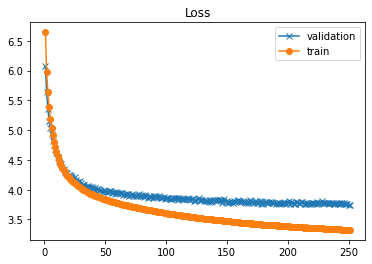

smallest val loss: (250, 3.7446406)
Current Lr:  8.254121e-05

Time taken for this epoch: 24.83 secs

Epoch 252 Batch 0 Loss 3.3086
Epoch 252 Batch 150 Loss 3.2811
Epoch 252 Batch 300 Loss 3.3102
Epoch 252 Batch 450 Loss 3.3105
Epoch 252 Batch 600 Loss 3.3145
Epoch 252 Batch 750 Loss 3.3218

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> toilets
kim kim <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.74934983253479 

* Train Loss 3.3243


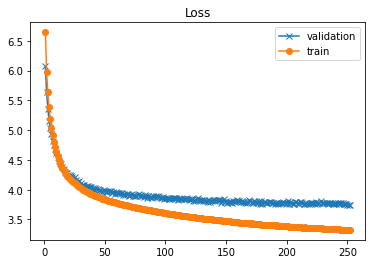

smallest val loss: (250, 3.7446406)
Current Lr:  8.1724975e-05

Time taken for this epoch: 24.78 secs

Epoch 253 Batch 0 Loss 3.4410
Epoch 253 Batch 150 Loss 3.2941
Epoch 253 Batch 300 Loss 3.3059
Epoch 253 Batch 450 Loss 3.3146
Epoch 253 Batch 600 Loss 3.3137
Epoch 253 Batch 750 Loss 3.3229

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.745270013809204 

* Train Loss 3.3236


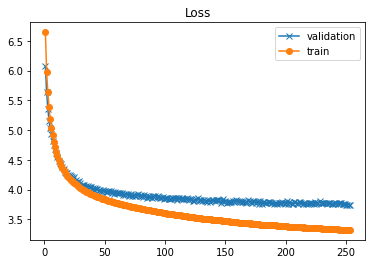

smallest val loss: (250, 3.7446406)
Current Lr:  8.091681e-05

Time taken for this epoch: 25.34 secs

Epoch 254 Batch 0 Loss 3.2503
Epoch 254 Batch 150 Loss 3.2835
Epoch 254 Batch 300 Loss 3.2926
Epoch 254 Batch 450 Loss 3.3049
Epoch 254 Batch 600 Loss 3.3111
Epoch 254 Batch 750 Loss 3.3177

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7680139541625977 

* Train Loss 3.3185


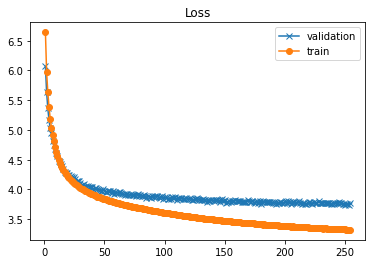

smallest val loss: (250, 3.7446406)
Current Lr:  8.0116624e-05

Time taken for this epoch: 25.29 secs

Epoch 255 Batch 0 Loss 3.0820
Epoch 255 Batch 150 Loss 3.3033
Epoch 255 Batch 300 Loss 3.3013
Epoch 255 Batch 450 Loss 3.3079
Epoch 255 Batch 600 Loss 3.3146
Epoch 255 Batch 750 Loss 3.3184

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7653770446777344 

* Train Loss 3.3203


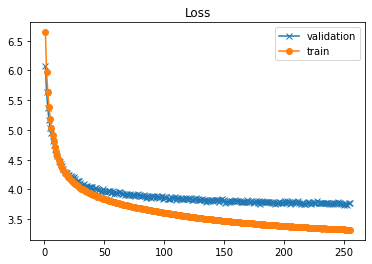

smallest val loss: (250, 3.7446406)
Current Lr:  7.9324374e-05

Time taken for this epoch: 24.92 secs

Epoch 256 Batch 0 Loss 3.2283
Epoch 256 Batch 150 Loss 3.2864
Epoch 256 Batch 300 Loss 3.3033
Epoch 256 Batch 450 Loss 3.3052
Epoch 256 Batch 600 Loss 3.3100
Epoch 256 Batch 750 Loss 3.3186

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.738323211669922 

* Train Loss 3.3195


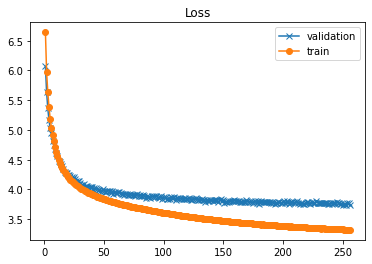

smallest val loss: (256, 3.7383232)
Current Lr:  7.853995e-05

Time taken for this epoch: 24.78 secs

Epoch 257 Batch 0 Loss 3.3545
Epoch 257 Batch 150 Loss 3.2884
Epoch 257 Batch 300 Loss 3.3044
Epoch 257 Batch 450 Loss 3.3033
Epoch 257 Batch 600 Loss 3.3088
Epoch 257 Batch 750 Loss 3.3152

warne was st to score a ball on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7503738403320312 

* Train Loss 3.3169


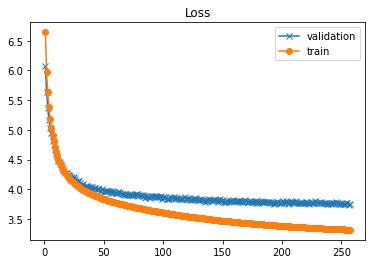

smallest val loss: (256, 3.7383232)
Current Lr:  7.7763274e-05

Time taken for this epoch: 25.21 secs

Epoch 258 Batch 0 Loss 3.0804
Epoch 258 Batch 150 Loss 3.2808
Epoch 258 Batch 300 Loss 3.2960
Epoch 258 Batch 450 Loss 3.3063
Epoch 258 Batch 600 Loss 3.3115
Epoch 258 Batch 750 Loss 3.3181

warne was st to score <UNK> <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.745617628097534 

* Train Loss 3.3183


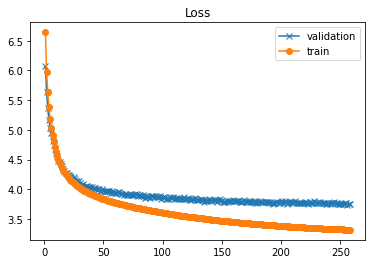

smallest val loss: (256, 3.7383232)
Current Lr:  7.699428e-05

Time taken for this epoch: 25.11 secs

Epoch 259 Batch 0 Loss 3.3327
Epoch 259 Batch 150 Loss 3.3007
Epoch 259 Batch 300 Loss 3.3026
Epoch 259 Batch 450 Loss 3.3068
Epoch 259 Batch 600 Loss 3.3091
Epoch 259 Batch 750 Loss 3.3179

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.784396171569824 

* Train Loss 3.3197


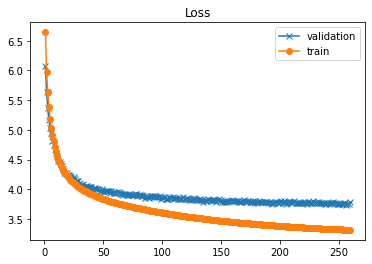

smallest val loss: (256, 3.7383232)
Current Lr:  7.6232885e-05

Time taken for this epoch: 25.31 secs

Epoch 260 Batch 0 Loss 3.2620
Epoch 260 Batch 150 Loss 3.2936
Epoch 260 Batch 300 Loss 3.2965
Epoch 260 Batch 450 Loss 3.3026
Epoch 260 Batch 600 Loss 3.3078
Epoch 260 Batch 750 Loss 3.3163

mcgrath was st to score <UNK> <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7793326377868652 

* Train Loss 3.3164


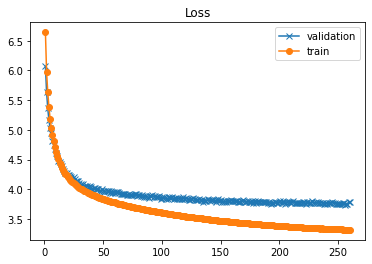

smallest val loss: (256, 3.7383232)
Current Lr:  7.547902e-05

Time taken for this epoch: 25.55 secs

Epoch 261 Batch 0 Loss 3.1257
Epoch 261 Batch 150 Loss 3.2755
Epoch 261 Batch 300 Loss 3.2916
Epoch 261 Batch 450 Loss 3.2980
Epoch 261 Batch 600 Loss 3.3058
Epoch 261 Batch 750 Loss 3.3153

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7682509422302246 

* Train Loss 3.3173


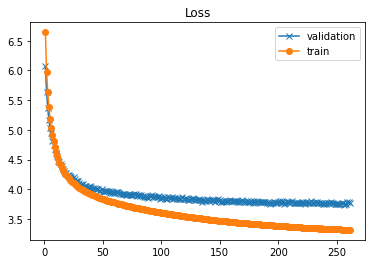

smallest val loss: (256, 3.7383232)
Current Lr:  7.473263e-05

Time taken for this epoch: 25.04 secs

Epoch 262 Batch 0 Loss 3.4328
Epoch 262 Batch 150 Loss 3.2912
Epoch 262 Batch 300 Loss 3.2979
Epoch 262 Batch 450 Loss 3.2994
Epoch 262 Batch 600 Loss 3.3083
Epoch 262 Batch 750 Loss 3.3130

warne was st to score a <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7588324546813965 

* Train Loss 3.3148


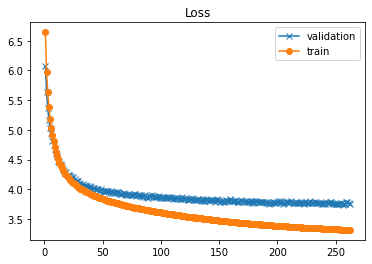

smallest val loss: (256, 3.7383232)
Current Lr:  7.3993615e-05

Time taken for this epoch: 25.11 secs

Epoch 263 Batch 0 Loss 3.1397
Epoch 263 Batch 150 Loss 3.2966
Epoch 263 Batch 300 Loss 3.2983
Epoch 263 Batch 450 Loss 3.3006
Epoch 263 Batch 600 Loss 3.3072
Epoch 263 Batch 750 Loss 3.3115

mcgrath was st to score <UNK> <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.763972282409668 

* Train Loss 3.3117


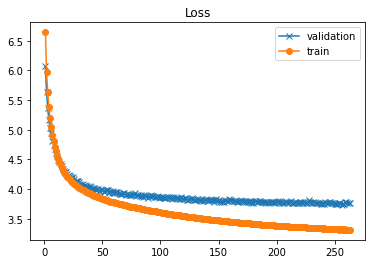

smallest val loss: (256, 3.7383232)
Current Lr:  7.326191e-05

Time taken for this epoch: 25.12 secs

Epoch 264 Batch 0 Loss 3.2127
Epoch 264 Batch 150 Loss 3.2942
Epoch 264 Batch 300 Loss 3.2942
Epoch 264 Batch 450 Loss 3.2967
Epoch 264 Batch 600 Loss 3.3049
Epoch 264 Batch 750 Loss 3.3137

warne was st to score <UNK> <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7441084384918213 

* Train Loss 3.3151


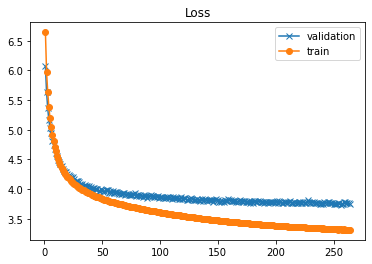

smallest val loss: (256, 3.7383232)
Current Lr:  7.253743e-05

Time taken for this epoch: 25.37 secs

Epoch 265 Batch 0 Loss 3.3250
Epoch 265 Batch 150 Loss 3.2932
Epoch 265 Batch 300 Loss 3.3002
Epoch 265 Batch 450 Loss 3.2980
Epoch 265 Batch 600 Loss 3.3046
Epoch 265 Batch 750 Loss 3.3098

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi thanks <UNK> for <UNK> <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7487175464630127 

* Train Loss 3.3119


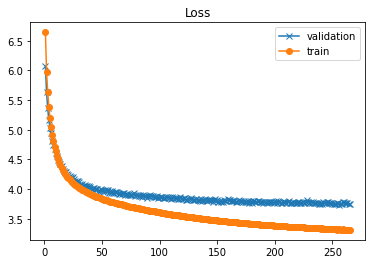

smallest val loss: (256, 3.7383232)
Current Lr:  7.182012e-05

Time taken for this epoch: 24.62 secs

Epoch 266 Batch 0 Loss 3.2632
Epoch 266 Batch 150 Loss 3.2784
Epoch 266 Batch 300 Loss 3.2851
Epoch 266 Batch 450 Loss 3.2936
Epoch 266 Batch 600 Loss 3.3060
Epoch 266 Batch 750 Loss 3.3105

first ever <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> was born on christmas

validation started ...

* Validation loss: 3.780482530593872 

* Train Loss 3.3116


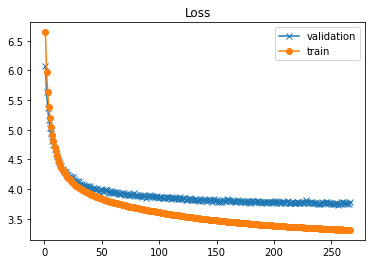

smallest val loss: (256, 3.7383232)
Current Lr:  7.11099e-05

Time taken for this epoch: 24.97 secs

Epoch 267 Batch 0 Loss 3.3236
Epoch 267 Batch 150 Loss 3.2805
Epoch 267 Batch 300 Loss 3.2912
Epoch 267 Batch 450 Loss 3.3012
Epoch 267 Batch 600 Loss 3.3072
Epoch 267 Batch 750 Loss 3.3105

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7564711570739746 

* Train Loss 3.3122


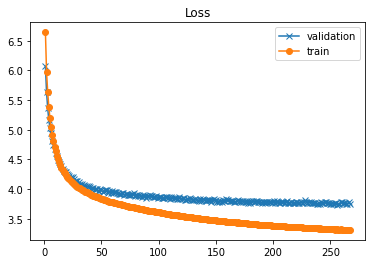

smallest val loss: (256, 3.7383232)
Current Lr:  7.04067e-05

Time taken for this epoch: 25.54 secs

Epoch 268 Batch 0 Loss 3.2022
Epoch 268 Batch 150 Loss 3.2995
Epoch 268 Batch 300 Loss 3.2936
Epoch 268 Batch 450 Loss 3.2949
Epoch 268 Batch 600 Loss 3.3003
Epoch 268 Batch 750 Loss 3.3083

first ever <UNK> <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7851603031158447 

* Train Loss 3.3097


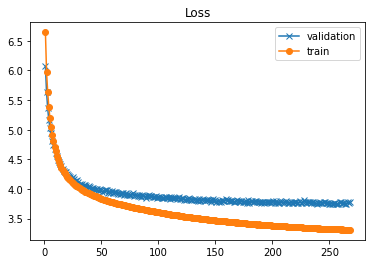

smallest val loss: (256, 3.7383232)
Current Lr:  6.971047e-05

Time taken for this epoch: 24.65 secs

Epoch 269 Batch 0 Loss 3.2492
Epoch 269 Batch 150 Loss 3.2748
Epoch 269 Batch 300 Loss 3.2865
Epoch 269 Batch 450 Loss 3.2970
Epoch 269 Batch 600 Loss 3.3019
Epoch 269 Batch 750 Loss 3.3078

st ever ball was <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7419426441192627 

* Train Loss 3.3080


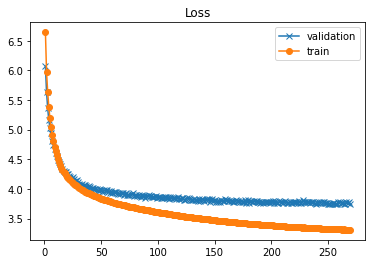

smallest val loss: (256, 3.7383232)
Current Lr:  6.90211e-05

Time taken for this epoch: 25.04 secs

Epoch 270 Batch 0 Loss 3.3719
Epoch 270 Batch 150 Loss 3.2677
Epoch 270 Batch 300 Loss 3.2846
Epoch 270 Batch 450 Loss 3.2929
Epoch 270 Batch 600 Loss 3.3007
Epoch 270 Batch 750 Loss 3.3078

warne was st to score a <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi congratulates modi for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.7662353515625 

* Train Loss 3.3086


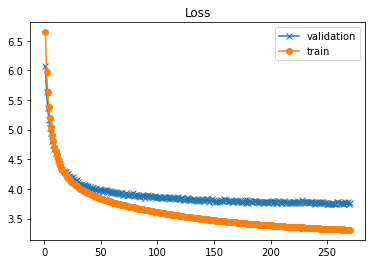

smallest val loss: (256, 3.7383232)
Current Lr:  6.833856e-05

Time taken for this epoch: 24.80 secs

Epoch 271 Batch 0 Loss 3.3234
Epoch 271 Batch 150 Loss 3.2857
Epoch 271 Batch 300 Loss 3.2919
Epoch 271 Batch 450 Loss 3.2955
Epoch 271 Batch 600 Loss 3.3050
Epoch 271 Batch 750 Loss 3.3077

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.756542205810547 

* Train Loss 3.3092


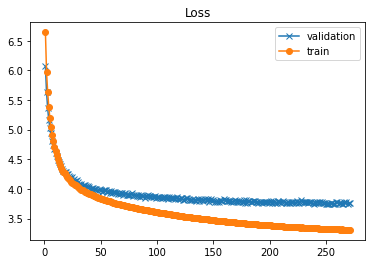

smallest val loss: (256, 3.7383232)
Current Lr:  6.766279e-05

Time taken for this epoch: 24.94 secs

Epoch 272 Batch 0 Loss 3.3587
Epoch 272 Batch 150 Loss 3.2727
Epoch 272 Batch 300 Loss 3.2819
Epoch 272 Batch 450 Loss 3.2837
Epoch 272 Batch 600 Loss 3.2939
Epoch 272 Batch 750 Loss 3.3015

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7735822200775146 

* Train Loss 3.3040


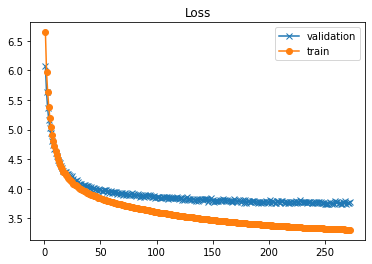

smallest val loss: (256, 3.7383232)
Current Lr:  6.699365e-05

Time taken for this epoch: 25.15 secs

Epoch 273 Batch 0 Loss 3.1519
Epoch 273 Batch 150 Loss 3.2877
Epoch 273 Batch 300 Loss 3.2872
Epoch 273 Batch 450 Loss 3.2969
Epoch 273 Batch 600 Loss 3.2957
Epoch 273 Batch 750 Loss 3.3047

first <UNK> <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7572221755981445 

* Train Loss 3.3063


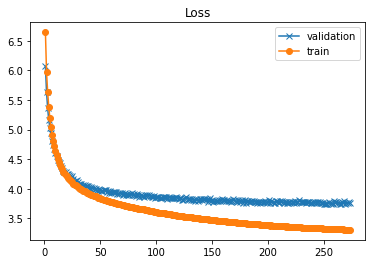

smallest val loss: (256, 3.7383232)
Current Lr:  6.6331166e-05

Time taken for this epoch: 24.94 secs

Epoch 274 Batch 0 Loss 3.2720
Epoch 274 Batch 150 Loss 3.2812
Epoch 274 Batch 300 Loss 3.2844
Epoch 274 Batch 450 Loss 3.2955
Epoch 274 Batch 600 Loss 3.3019
Epoch 274 Batch 750 Loss 3.3053

first <UNK> <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.76552677154541 

* Train Loss 3.3050


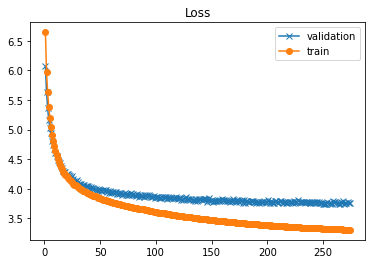

smallest val loss: (256, 3.7383232)
Current Lr:  6.567522e-05

Time taken for this epoch: 24.46 secs

Epoch 275 Batch 0 Loss 3.1780
Epoch 275 Batch 150 Loss 3.2811
Epoch 275 Batch 300 Loss 3.2839
Epoch 275 Batch 450 Loss 3.2895
Epoch 275 Batch 600 Loss 3.2967
Epoch 275 Batch 750 Loss 3.3043

st <UNK> <UNK> <UNK> <UNK> on this day
dhoni <UNK> trending on twitter today
pm modi thanks pm for <UNK> <UNK> to <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7613279819488525 

* Train Loss 3.3060


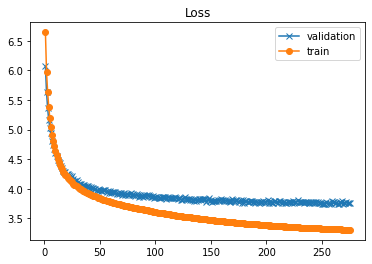

smallest val loss: (256, 3.7383232)
Current Lr:  6.502578e-05

Time taken for this epoch: 25.13 secs

Epoch 276 Batch 0 Loss 3.4529
Epoch 276 Batch 150 Loss 3.2769
Epoch 276 Batch 300 Loss 3.2800
Epoch 276 Batch 450 Loss 3.2920
Epoch 276 Batch 600 Loss 3.2975
Epoch 276 Batch 750 Loss 3.3038

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.771324396133423 

* Train Loss 3.3052


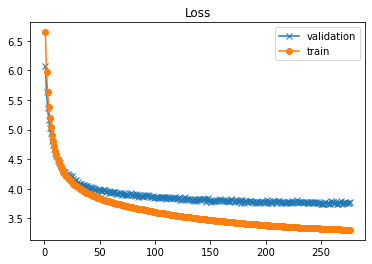

smallest val loss: (256, 3.7383232)
Current Lr:  6.438275e-05

Time taken for this epoch: 25.01 secs

Epoch 277 Batch 0 Loss 3.4437
Epoch 277 Batch 150 Loss 3.2838
Epoch 277 Batch 300 Loss 3.2919
Epoch 277 Batch 450 Loss 3.2964
Epoch 277 Batch 600 Loss 3.3007
Epoch 277 Batch 750 Loss 3.3035

warne was st to score wickets on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7649285793304443 

* Train Loss 3.3048


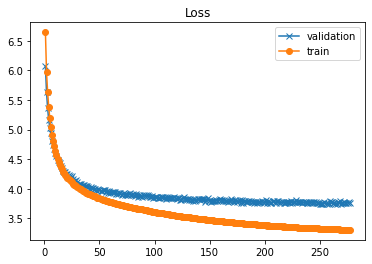

smallest val loss: (256, 3.7383232)
Current Lr:  6.374608e-05

Time taken for this epoch: 25.62 secs

Epoch 278 Batch 0 Loss 3.2676
Epoch 278 Batch 150 Loss 3.2869
Epoch 278 Batch 300 Loss 3.2919
Epoch 278 Batch 450 Loss 3.2932
Epoch 278 Batch 600 Loss 3.2943
Epoch 278 Batch 750 Loss 3.3009

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7398200035095215 

* Train Loss 3.3035


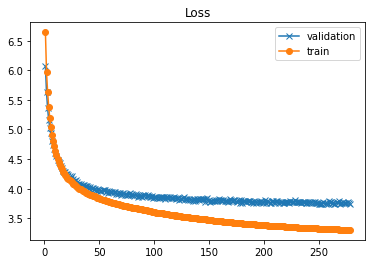

smallest val loss: (256, 3.7383232)
Current Lr:  6.311571e-05

Time taken for this epoch: 24.84 secs

Epoch 279 Batch 0 Loss 3.2904
Epoch 279 Batch 150 Loss 3.2819
Epoch 279 Batch 300 Loss 3.2800
Epoch 279 Batch 450 Loss 3.2886
Epoch 279 Batch 600 Loss 3.2966
Epoch 279 Batch 750 Loss 3.3039

first ever <UNK> bowling was <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7585089206695557 

* Train Loss 3.3030


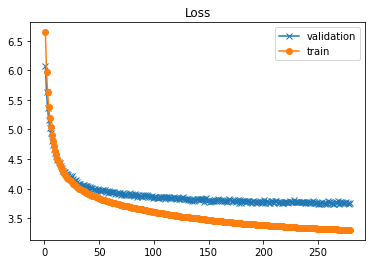

smallest val loss: (256, 3.7383232)
Current Lr:  6.2491556e-05

Time taken for this epoch: 24.90 secs

Epoch 280 Batch 0 Loss 3.2787
Epoch 280 Batch 150 Loss 3.2756
Epoch 280 Batch 300 Loss 3.2840
Epoch 280 Batch 450 Loss 3.2905
Epoch 280 Batch 600 Loss 3.2930
Epoch 280 Batch 750 Loss 3.2999

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.748417615890503 

* Train Loss 3.3020


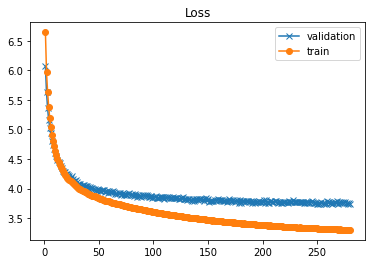

smallest val loss: (256, 3.7383232)
Current Lr:  6.1873594e-05

Time taken for this epoch: 25.14 secs

Epoch 281 Batch 0 Loss 3.3227
Epoch 281 Batch 150 Loss 3.2620
Epoch 281 Batch 300 Loss 3.2853
Epoch 281 Batch 450 Loss 3.2889
Epoch 281 Batch 600 Loss 3.2930
Epoch 281 Batch 750 Loss 3.2989

warne was st to score a <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> for <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.748621940612793 

* Train Loss 3.2980


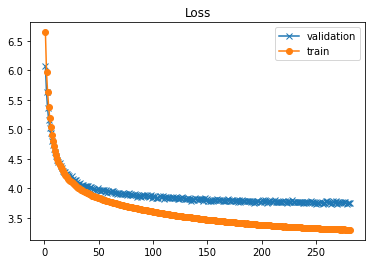

smallest val loss: (256, 3.7383232)
Current Lr:  6.126174e-05

Time taken for this epoch: 25.03 secs

Epoch 282 Batch 0 Loss 3.2913
Epoch 282 Batch 150 Loss 3.2633
Epoch 282 Batch 300 Loss 3.2698
Epoch 282 Batch 450 Loss 3.2857
Epoch 282 Batch 600 Loss 3.2909
Epoch 282 Batch 750 Loss 3.2979

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> toilets on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7482802867889404 

* Train Loss 3.2980


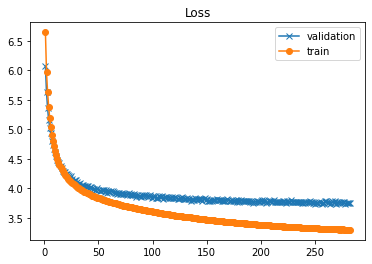

smallest val loss: (256, 3.7383232)
Current Lr:  6.0655926e-05

Time taken for this epoch: 25.03 secs

Epoch 283 Batch 0 Loss 3.2766
Epoch 283 Batch 150 Loss 3.2749
Epoch 283 Batch 300 Loss 3.2832
Epoch 283 Batch 450 Loss 3.2935
Epoch 283 Batch 600 Loss 3.2936
Epoch 283 Batch 750 Loss 3.2988

st ever <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> to <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7681427001953125 

* Train Loss 3.2988


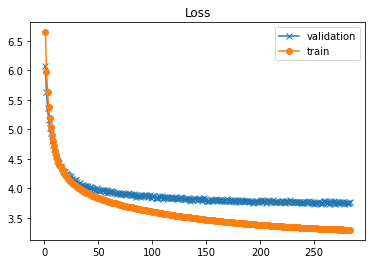

smallest val loss: (256, 3.7383232)
Current Lr:  6.0056114e-05

Time taken for this epoch: 24.79 secs

Epoch 284 Batch 0 Loss 3.3400
Epoch 284 Batch 150 Loss 3.2566
Epoch 284 Batch 300 Loss 3.2767
Epoch 284 Batch 450 Loss 3.2839
Epoch 284 Batch 600 Loss 3.2877
Epoch 284 Batch 750 Loss 3.2956

first <UNK> <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7582223415374756 

* Train Loss 3.2955


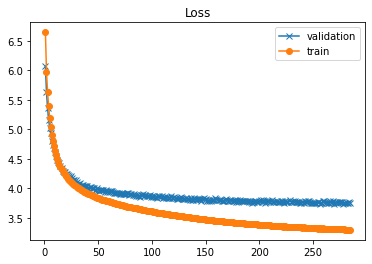

smallest val loss: (256, 3.7383232)
Current Lr:  5.9462203e-05

Time taken for this epoch: 24.78 secs

Epoch 285 Batch 0 Loss 3.3132
Epoch 285 Batch 150 Loss 3.2772
Epoch 285 Batch 300 Loss 3.2812
Epoch 285 Batch 450 Loss 3.2822
Epoch 285 Batch 600 Loss 3.2889
Epoch 285 Batch 750 Loss 3.2946

first <UNK> <UNK> <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi thanks pm for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.748920440673828 

* Train Loss 3.2945


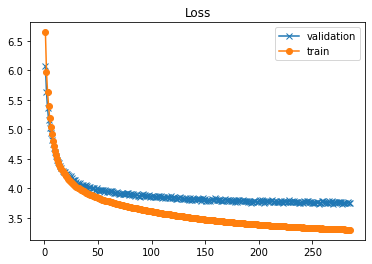

smallest val loss: (256, 3.7383232)
Current Lr:  5.8874197e-05

Time taken for this epoch: 25.45 secs

Epoch 286 Batch 0 Loss 3.2295
Epoch 286 Batch 150 Loss 3.2832
Epoch 286 Batch 300 Loss 3.2919
Epoch 286 Batch 450 Loss 3.2935
Epoch 286 Batch 600 Loss 3.2908
Epoch 286 Batch 750 Loss 3.2950

first <UNK> <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.756401777267456 

* Train Loss 3.2962


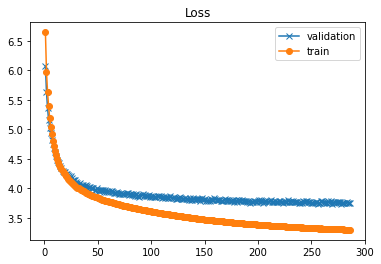

smallest val loss: (256, 3.7383232)
Current Lr:  5.8292004e-05

Time taken for this epoch: 24.58 secs

Epoch 287 Batch 0 Loss 3.2102
Epoch 287 Batch 150 Loss 3.2771
Epoch 287 Batch 300 Loss 3.2793
Epoch 287 Batch 450 Loss 3.2817
Epoch 287 Batch 600 Loss 3.2894
Epoch 287 Batch 750 Loss 3.2935

warne was st ever <UNK> <UNK> in a ball on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
<UNK> korean leader <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 3.760443687438965 

* Train Loss 3.2943


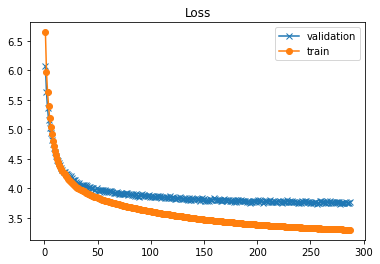

smallest val loss: (256, 3.7383232)
Current Lr:  5.771556e-05

Time taken for this epoch: 25.33 secs

Epoch 288 Batch 0 Loss 3.1495
Epoch 288 Batch 150 Loss 3.2612
Epoch 288 Batch 300 Loss 3.2805
Epoch 288 Batch 450 Loss 3.2838
Epoch 288 Batch 600 Loss 3.2883
Epoch 288 Batch 750 Loss 3.2940

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7641687393188477 

* Train Loss 3.2943


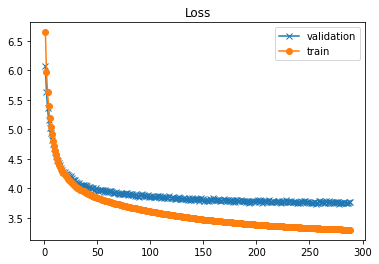

smallest val loss: (256, 3.7383232)
Current Lr:  5.7144818e-05

Time taken for this epoch: 24.92 secs

Epoch 289 Batch 0 Loss 3.1784
Epoch 289 Batch 150 Loss 3.2534
Epoch 289 Batch 300 Loss 3.2675
Epoch 289 Batch 450 Loss 3.2776
Epoch 289 Batch 600 Loss 3.2870
Epoch 289 Batch 750 Loss 3.2912

first ever <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi congratulates modi for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.755495309829712 

* Train Loss 3.2917


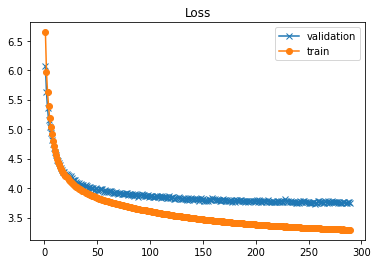

smallest val loss: (256, 3.7383232)
Current Lr:  5.6579724e-05

Time taken for this epoch: 25.06 secs

Epoch 290 Batch 0 Loss 3.2257
Epoch 290 Batch 150 Loss 3.2641
Epoch 290 Batch 300 Loss 3.2716
Epoch 290 Batch 450 Loss 3.2800
Epoch 290 Batch 600 Loss 3.2845
Epoch 290 Batch 750 Loss 3.2911

first ever <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7600114345550537 

* Train Loss 3.2924


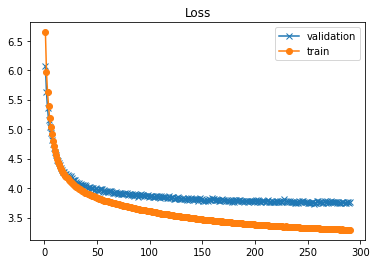

smallest val loss: (256, 3.7383232)
Current Lr:  5.6020217e-05

Time taken for this epoch: 24.59 secs

Epoch 291 Batch 0 Loss 3.2567
Epoch 291 Batch 150 Loss 3.2690
Epoch 291 Batch 300 Loss 3.2787
Epoch 291 Batch 450 Loss 3.2859
Epoch 291 Batch 600 Loss 3.2879
Epoch 291 Batch 750 Loss 3.2928

warne was st ever <UNK> <UNK> <UNK>
dhoni <UNK> trending on twitter today
pm modi congratulates modi for <UNK> toilets
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.7648720741271973 

* Train Loss 3.2921


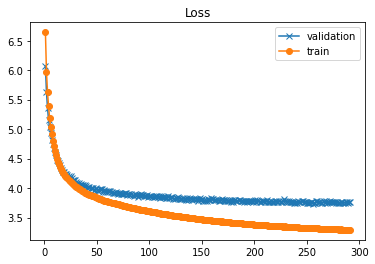

smallest val loss: (256, 3.7383232)
Current Lr:  5.5466244e-05

Time taken for this epoch: 24.71 secs

Epoch 292 Batch 0 Loss 3.1971
Epoch 292 Batch 150 Loss 3.2727
Epoch 292 Batch 300 Loss 3.2841
Epoch 292 Batch 450 Loss 3.2859
Epoch 292 Batch 600 Loss 3.2902
Epoch 292 Batch 750 Loss 3.2933

first ever <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7597780227661133 

* Train Loss 3.2928


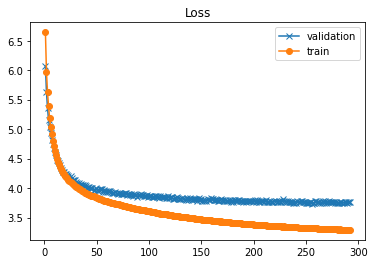

smallest val loss: (256, 3.7383232)
Current Lr:  5.4917742e-05

Time taken for this epoch: 24.99 secs

Epoch 293 Batch 0 Loss 3.3982
Epoch 293 Batch 150 Loss 3.2804
Epoch 293 Batch 300 Loss 3.2806
Epoch 293 Batch 450 Loss 3.2781
Epoch 293 Batch 600 Loss 3.2831
Epoch 293 Batch 750 Loss 3.2883

first ever <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> toilets on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.751584053039551 

* Train Loss 3.2908


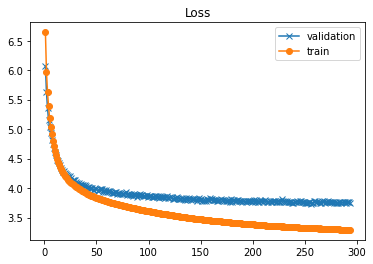

smallest val loss: (256, 3.7383232)
Current Lr:  5.4374676e-05

Time taken for this epoch: 25.08 secs

Epoch 294 Batch 0 Loss 3.0988
Epoch 294 Batch 150 Loss 3.2670
Epoch 294 Batch 300 Loss 3.2759
Epoch 294 Batch 450 Loss 3.2793
Epoch 294 Batch 600 Loss 3.2857
Epoch 294 Batch 750 Loss 3.2882

first ever <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.74824595451355 

* Train Loss 3.2883


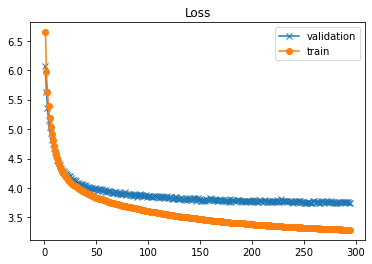

smallest val loss: (256, 3.7383232)
Current Lr:  5.3836968e-05

Time taken for this epoch: 24.95 secs

Epoch 295 Batch 0 Loss 3.3359
Epoch 295 Batch 150 Loss 3.2568
Epoch 295 Batch 300 Loss 3.2675
Epoch 295 Batch 450 Loss 3.2755
Epoch 295 Batch 600 Loss 3.2862
Epoch 295 Batch 750 Loss 3.2891

first ever <UNK> <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.752242088317871 

* Train Loss 3.2894


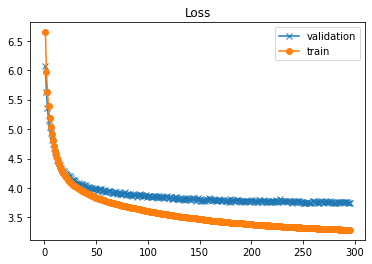

smallest val loss: (256, 3.7383232)
Current Lr:  5.3304582e-05

Time taken for this epoch: 24.69 secs

Epoch 296 Batch 0 Loss 3.3326
Epoch 296 Batch 150 Loss 3.2594
Epoch 296 Batch 300 Loss 3.2705
Epoch 296 Batch 450 Loss 3.2804
Epoch 296 Batch 600 Loss 3.2842
Epoch 296 Batch 750 Loss 3.2881

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> <UNK> <UNK> on christmas

validation started ...

* Validation loss: 3.750277519226074 

* Train Loss 3.2890


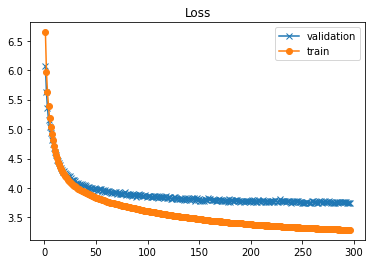

smallest val loss: (256, 3.7383232)
Current Lr:  5.277747e-05

Time taken for this epoch: 25.00 secs

Epoch 297 Batch 0 Loss 3.3172
Epoch 297 Batch 150 Loss 3.2642
Epoch 297 Batch 300 Loss 3.2739
Epoch 297 Batch 450 Loss 3.2800
Epoch 297 Batch 600 Loss 3.2826
Epoch 297 Batch 750 Loss 3.2876

warne was st to score a <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> to <UNK>
kim jongun <UNK> <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.7612524032592773 

* Train Loss 3.2894


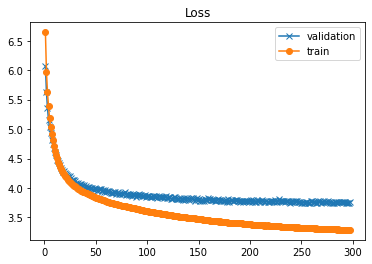

smallest val loss: (256, 3.7383232)
Current Lr:  5.225554e-05

Time taken for this epoch: 25.16 secs

Epoch 298 Batch 0 Loss 3.3553
Epoch 298 Batch 150 Loss 3.2591
Epoch 298 Batch 300 Loss 3.2710
Epoch 298 Batch 450 Loss 3.2839
Epoch 298 Batch 600 Loss 3.2866
Epoch 298 Batch 750 Loss 3.2871

first ever <UNK> <UNK> <UNK> <UNK>
dhoni trending on twitter today
pm modi congratulates modi for <UNK> <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.742948055267334 

* Train Loss 3.2890


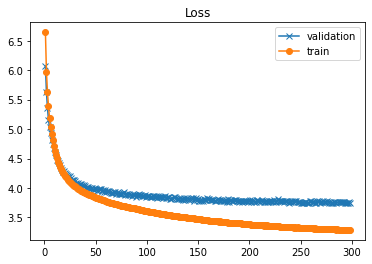

smallest val loss: (256, 3.7383232)
Current Lr:  5.1738796e-05

Time taken for this epoch: 24.73 secs

Epoch 299 Batch 0 Loss 3.0875
Epoch 299 Batch 150 Loss 3.2745
Epoch 299 Batch 300 Loss 3.2808
Epoch 299 Batch 450 Loss 3.2853
Epoch 299 Batch 600 Loss 3.2842
Epoch 299 Batch 750 Loss 3.2877

first ever <UNK> <UNK> <UNK> in tests
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.779980421066284 

* Train Loss 3.2901


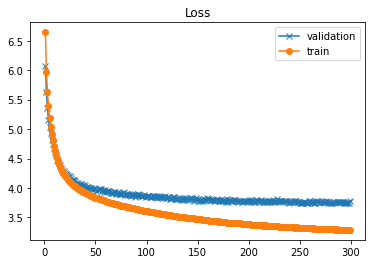

smallest val loss: (256, 3.7383232)
Current Lr:  5.1227158e-05

Time taken for this epoch: 24.52 secs

Epoch 300 Batch 0 Loss 3.3975
Epoch 300 Batch 150 Loss 3.2739
Epoch 300 Batch 300 Loss 3.2727
Epoch 300 Batch 450 Loss 3.2755
Epoch 300 Batch 600 Loss 3.2804
Epoch 300 Batch 750 Loss 3.2851

warne was st to score <UNK> <UNK> on this day
dhoni trending on twitter today
pm modi thanks pm for <UNK> <UNK> on <UNK>
kim jongun <UNK> <UNK> was born on christmas

validation started ...

* Validation loss: 3.781805992126465 

* Train Loss 3.2861


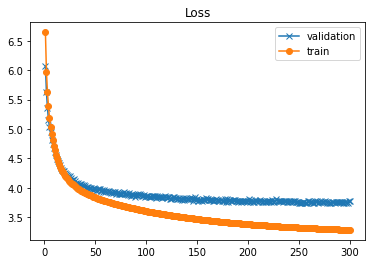

smallest val loss: (256, 3.7383232)
Current Lr:  5.0720588e-05

Time taken for this epoch: 24.78 secs



In [51]:
print(params)
print('#'*40)

for epoch in range(ep,EPOCHS+1):
    ep = epoch
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        
        train_step(inp, tar)
    
        if batch % 150 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch , batch, train_loss.result()))
                  
    print()
    print(summarize(clean_words(longreview_val['long'][i1])))
    print(summarize(clean_words(longreview_val['long'][i2])))
    print(summarize(clean_words(longreview_val['long'][i3])))
    print(summarize(clean_words(longreview_val['long'][i4])))
    print()
    
    val_loss_ = validate().numpy()
    history['val'].append((epoch,val_loss_))
    print ('\n* Train Loss {:.4f}'.format(train_loss.result()))
    history['train'].append((epoch,train_loss.result().numpy()))
    
    
    if best_val_loss-val_loss_ > 0.1:
        ckpt_save_path4 = ckpt_manager4.save()
        print ('\nSaving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path4))  
        best_val_loss = val_loss_
    
    hist(history)
    print('Current Lr: ',optimizer2._decayed_lr('float32').numpy())
    print ('\nTime taken for this epoch: {:.2f} secs\n'.format(time.time() - start))
    print('='*40)

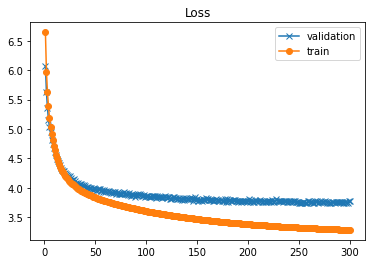

smallest val loss: (256, 3.7383232)


In [52]:
hist(history)

In [53]:
ckpt_save_path4 = ckpt_manager4.save()
print ('\nSaving checkpoint for epoch {} at {}'.format(301, ckpt_save_path4))  


Saving checkpoint for epoch 301 at checkpoints4/ckpt-16


In [54]:
# !tar -zcvf finalModelv2.tar.gz ./checkpoints4
!zip -r model.zip ./checkpoints4

  adding: checkpoints4/ (stored 0%)
  adding: checkpoints4/ckpt-16.index (deflated 81%)
  adding: checkpoints4/ckpt-5.data-00000-of-00001 (deflated 12%)
  adding: checkpoints4/ckpt-12.index (deflated 81%)
  adding: checkpoints4/ckpt-16.data-00000-of-00001 (deflated 12%)
  adding: checkpoints4/ckpt-5.index (deflated 81%)
  adding: checkpoints4/ckpt-4.index (deflated 81%)
  adding: checkpoints4/ckpt-13.index (deflated 81%)
  adding: checkpoints4/ckpt-6.data-00000-of-00001 (deflated 12%)
  adding: checkpoints4/ckpt-12.data-00000-of-00001 (deflated 12%)
  adding: checkpoints4/ckpt-13.data-00000-of-00001 (deflated 12%)
  adding: checkpoints4/ckpt-4.data-00000-of-00001 (deflated 12%)
  adding: checkpoints4/ckpt-14.data-00000-of-00001 (deflated 12%)
  adding: checkpoints4/ckpt-9.data-00000-of-00001 (deflated 12%)
  adding: checkpoints4/ckpt-15.data-00000-of-00001 (deflated 12%)
  adding: checkpoints4/ckpt-11.data-00000-of-00001 (deflated 12%)
  adding: checkpoints4/ckpt-11.index (deflated 81%

In [ ]:
document_tokenizer
summary_tokenizer

In [55]:
import pickle

In [56]:
with open('document_tokenizer.pickle', 'wb') as handle:
    pickle.dump(document_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
with open('summary_tokenizer.pickle', 'wb') as handle:
    pickle.dump(summary_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
one = "NEW DELHI: Starlink, the satellite internet division of billionaire Elon Musk's rocket company SpaceX, will apply early next year for a commercial licence in India to provide broadband and other services, its country head said.We hope to have applied for a commercial license on or before 31st January 2022 (unless we hit some major roadblock), Sanjay Bhargava, Starlink Country Director, India at SpaceX said in a LinkedIn post.If the company can roll out its services by April, it aims to have 200,000 Starlink devices in India by December 2022, it said in a presentation posted by Bhargava. The company has previously said it expects 80% of these devices to be in rural areas.Starlink is one of a growing number of companies launching small satellites as part of a low-Earth orbit network to provide low-latency broadband internet services around the world, with a particular focus on remote areas that terrestrial internet infrastructure struggles to reach."

In [ ]:
two = "leaving his job as an Assistant Manager with Axis Bank, Aditya Bhalla, a native of Gurugram has joined Capgemini wherein he received a 200 per cent hike in his salary. How? By upskilling. Bhalla pursued an online course in artificial intelligence (AI) and Machine Learning (ML). From a CTC of Rs 6 lakhs, his annual income has now raised to Rs 18 lakh.After getting a decent rank in AIEEE, he pursued BTech in ECE from MMU Ambala and a PGDM from Manipal Bangalore. Thereafter, he joined Axis Bank, however, Aditya was not satisfied with his job and decided to do a PG programme in Artificial Intelligence and Machine Learning (PGP AIML) from Great Learning to upgrade his skills."

In [62]:
three = "India’s fifth Omicron case was detected in Delhi as a Tanzania returnee tested positive for the strain. Delhi health minister Satyendar Jain said the patient is currently undergoing treatment at Lok Nayak Hospital. Fifteen suspected patients of Omicron, who flew in the national capital from at risk countries are admitted to the Delhi government’s LNJP hospital, news agency PTI reported."

In [64]:
four = "If there are vacancies and also eligible candidates, why is there no recruitment, BJP MP Varun Gandhi asked today as he targeted the party-led Uttar Pradesh government over a police crackdown on a candlelight march by job seekers in Lucknow. The Pilibhit MP, who has been publicly expressing views that are at odds with the BJP's stand, shared a viral video in which policemen can be seen chasing and cane-charging protesters. Mr Gandhi said these protesters too are Indians and no one is ready to even hear their grievances. He also appealed to the authorities, asking if they would have been able to act in the same manner if their children were part of these protests."

In [67]:
five = "The global crypto market capitalisation is down 5.53 percent over the last 24 hours to stand at $2.3 trillion. The total crypto market volume over the last 24 hours is $203.74 billion, a 48.22 percent increase. The total volume in DeFi is currently $27.96 billion, 13.72 percent of the total crypto market 24-hour volume. The volume of all stable coins is now $162.40 billion, which is 79.71 percent of the total crypto market's 24-hour volume."

In [69]:
six = "Indian badminton ace P V Sindhu settled for a silver medal at the BWF World Tour Finals after going down meekly against Korean teen sensation An Seyoung in the summit clash, here on Sunday.Sindhu, the reigning world champion and two-time Olympic medallist, could neither match the pace nor breach the defence of the world number six Korean, losing 16-21 12-21 in the 40-minute lop-sided clash."

In [61]:
 print(summarize(clean_words(one)))

spacex to allow internet <UNK> from india


In [59]:
 print(summarize(clean_words("leaving his job as an Assistant Manager with Axis Bank, Aditya Bhalla, a native of Gurugram has joined Capgemini wherein he received a 200 per cent hike in his salary. How? By upskilling. Bhalla pursued an online course in artificial intelligence (AI) and Machine Learning (ML). From a CTC of Rs 6 lakhs, his annual income has now raised to Rs 18 lakh.After getting a decent rank in AIEEE, he pursued BTech in ECE from MMU Ambala and a PGDM from Manipal Bangalore. Thereafter, he joined Axis Bank, however, Aditya was not satisfied with his job and decided to do a PG programme in Artificial Intelligence and Machine Learning (PGP AIML) from Great Learning to upgrade his skills.")))

<UNK> manager gets salary of lakh in a job


In [63]:
 print(summarize(clean_words(three)))

delhi hospital case reported <UNK> <UNK>


In [66]:
 print(summarize(clean_words(four)))

dont <UNK> people in up varun gandhi


In [68]:
 print(summarize(clean_words(five)))

global stock <UNK> up to bn in hours


In [70]:
 print(summarize(clean_words(six)))

pv sindhu breaks down after <UNK> world no win


In [73]:
print(summarize(clean_words(" Kindly forward the attached mail to all our students to actively participate in the events going to be conducted during Energy Conservation week.")))

students to host <UNK> to promote <UNK>


In [74]:
print(summarize(clean_words("Humans have an amazing ability to make sense of their surroundings using sound. For example, we routinely deal with situations like the ringing of the telephone in the office, the honking of a horn while driving and the sound made by the contents of a shaken box. Machine listening deals with creating algorithms which can perform similar tasks, and more. With varied applications like self- driving cars, intelligent assistive devices and enhanced human-computer interaction, machine listening brings together various domains like audio signal processing and modelling, artificial intelligence, cognitive science and acoustics.")))

how do we make <UNK> work


In [75]:
print(summarize(clean_words("Finding software solutions to professional technical issues will decide how well we perform in the days to come. Technology for sure is the driver today. In pursuit of such solutions India Police Hackathon 2019 is being organised by Karnataka State Police and co-hosted by RV College of Engineering, Bengaluru, on their campus. IEEE is the Knowledge Partner providing most of the Mentors and Jury. India Police Hackathon 2019 is scheduled to be on 16th and 17th November, a 36-hour Hackathon. It is an Open Hackathon with No Registration Fee and Online Elimination Round. Around 25 teams of 3 to 5 each will participate in the Hackathon, based on the Elimination Round.")))

karnataka police to perform <UNK> in school
